In [1]:
import tensorflow as tf
from tensorflow.keras import backend as KR
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Lambda
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Bits per Symbol
k = 4

# Number of symbols

L = 50

# Channel Use
n = 1

# Effective Throughput
#  (bits per symbol)*( number of symbols) / channel use
R = k / n

# Eb/N0 used for training
train_Eb_dB = 9

# Noise Standard Deviation
noise_sigma = np.sqrt(1 / (2 * R * 10 ** (train_Eb_dB / 10)))

# Number of messages used for training, each size = k*L
batch_size = 64
nb_train_word = batch_size*200

In [3]:
# Generate Binary Sequence
train_data = tf.random.uniform(shape=(nb_train_word, k*L), minval=0, maxval=2, dtype=tf.dtypes.int32)
train_data

<tf.Tensor: shape=(12800, 200), dtype=int32, numpy=
array([[0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 1],
       ...,
       [1, 0, 1, ..., 0, 1, 1],
       [1, 0, 0, ..., 0, 1, 1],
       [1, 0, 1, ..., 1, 1, 1]], dtype=int32)>

In [4]:
# Reshaping into N x L x k (N: number of data messages, L: block length, k: bits/symbol)
train_data = tf.reshape(shape=(nb_train_word, L, k), tensor=train_data)
train_data.shape

TensorShape([12800, 50, 4])

In [5]:
def BitsToInt(bits, k):
    '''Function to transform a binary sequence into integers.'''
    a = 2**np.arange(k)[::-1]
    a = np.reshape(a, newshape=(k,1))
    return bits @ a

tmp = BitsToInt(train_data.numpy(),k)
print('Integers samples Shape:', tmp.shape)
one_hot_train = tf.keras.utils.to_categorical(y=tmp, num_classes=2 ** k)
print('One-Hot TRAINING Shape:', one_hot_train.shape)

Integers samples Shape: (12800, 50, 1)
One-Hot TRAINING Shape: (12800, 50, 16)


In [6]:
one_hot_labels = tf.identity(one_hot_train)
print('One-Hot LABELS Shape:', one_hot_labels.shape)

One-Hot LABELS Shape: (12800, 50, 16)


In [7]:
early_stopping_patience = 100

epochs = 150

optimizer = tf.keras.optimizers.Adam(lr=0.001)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                               patience=early_stopping_patience)


# Learning Rate Control
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=5, min_lr=0.0001)

# Save the best results based on Training Set
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath='./' + 'model_' + str(k) + '_' + str(L) + '_' + str(n) + '_' + str(train_Eb_dB) + 'dB' + ' ' + 'AWGN ' + '.h5',
                                  monitor='loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=True,
                                  mode='auto', save_freq=1)


In [8]:
# Define Power Norm for Tx
def normalization(x):
    mean = KR.mean(x ** 2)
    return x / KR.sqrt(2 * mean)  # 2 = I and Q channels


# Define Channel Layers including AWGN and Flat Rayleigh fading
#  x: input data
#  sigma: noise std
def AWGN_channel(x, sigma):

    return x + tf.keras.backend.random_normal(tf.keras.backend.shape(x), mean=0.0, stddev=sigma)


model_input = Input(batch_shape=(batch_size, L, 2 ** k), name='input_bits')

e = Conv1D(filters=256, strides=1, kernel_size=1, name='e_1')(model_input)
e = BatchNormalization(name='e_2')(e)
e = Activation('elu', name='e_3')(e)

e = Conv1D(filters=256, strides=1, kernel_size=1, name='e_7')(e)
e = BatchNormalization(name='e_8')(e)
e = Activation('elu', name='e_9')(e)

e = Conv1D(filters=2 * n, strides=1, kernel_size=1, name='e_10')(e)  # 2 = I and Q channels
e = BatchNormalization(name='e_11')(e)
e = Activation('linear', name='e_12')(e)

e = Lambda(normalization, name='power_norm')(e)

# AWGN channel
y_h = Lambda(channel_layer, arguments={'sigma': noise_sigma}, name='channel_layer')(e)

# Define Decoder Layers (Receiver)
d = Conv1D(filters=256, strides=1, kernel_size=1, name='d_1')(y_h)
d = BatchNormalization(name='d_2')(d)
d = Activation('elu', name='d_3')(d)

d = Conv1D(filters=256, strides=1, kernel_size=1, name='d_7')(d)
d = BatchNormalization(name='d_8')(d)
d = Activation('elu', name='d_9')(d)

# Output One hot vector and use Softmax to soft decoding
model_output = Conv1D(filters=2 ** k, strides=1, kernel_size=1, name='d_10', activation='softmax')(d)

# Build System Model
sys_model = Model(model_input, model_output)
encoder = Model(model_input, e)

# encoder.summary()
# import time
# time.sleep(500)
# Print Model Architecture
sys_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_bits (InputLayer)      [(64, 50, 16)]            0         
_________________________________________________________________
e_1 (Conv1D)                 (64, 50, 256)             4352      
_________________________________________________________________
e_2 (BatchNormalization)     (64, 50, 256)             1024      
_________________________________________________________________
e_3 (Activation)             (64, 50, 256)             0         
_________________________________________________________________
e_7 (Conv1D)                 (64, 50, 256)             65792     
_________________________________________________________________
e_8 (BatchNormalization)     (64, 50, 256)             1024      
_________________________________________________________________
e_9 (Activation)             (64, 50, 256)             0     

In [9]:
# Compile Model
sys_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# print('encoder output:', '\n', encoder.predict(vec_one_hot, batch_size=batch_size))

print('starting train the NN...')
start = time.clock()

# TRAINING
mod_history = sys_model.fit(one_hot_train, one_hot_labels,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_split=0.3, callbacks=[modelcheckpoint,reduce_lr])

end = time.clock()

print('The NN has trained ' + str(end - start) + ' s')


starting train the NN...
Train on 8960 samples, validate on 3840 samples
Epoch 1/150

Epoch 00001: loss improved from inf to 0.24723, saving model to ./model_4_50_1_9dB AWGN .h5
  64/8960 [..............................] - ETA: 3:01 - loss: 0.2472 - accuracy: 0.9365
Epoch 00001: loss improved from 0.24723 to 0.17909, saving model to ./model_4_50_1_9dB AWGN .h5
 128/8960 [..............................] - ETA: 1:37 - loss: 0.2132 - accuracy: 0.9385
Epoch 00001: loss improved from 0.17909 to 0.16246, saving model to ./model_4_50_1_9dB AWGN .h5
 192/8960 [..............................] - ETA: 1:09 - loss: 0.1963 - accuracy: 0.9406
Epoch 00001: loss improved from 0.16246 to 0.14192, saving model to ./model_4_50_1_9dB AWGN .h5
 256/8960 [..............................] - ETA: 56s - loss: 0.1827 - accuracy: 0.9440 
Epoch 00001: loss improved from 0.14192 to 0.12527, saving model to ./model_4_50_1_9dB AWGN .h5
 320/8960 [>.............................] - ETA: 47s - loss: 0.1712 - accuracy: 0

2880/8960 [========>.....................] - ETA: 12s - loss: 0.0666 - accuracy: 0.9788
Epoch 00001: loss improved from 0.02657 to 0.02588, saving model to ./model_4_50_1_9dB AWGN .h5
2944/8960 [========>.....................] - ETA: 12s - loss: 0.0657 - accuracy: 0.9792
Epoch 00001: loss improved from 0.02588 to 0.02406, saving model to ./model_4_50_1_9dB AWGN .h5
3008/8960 [=========>....................] - ETA: 12s - loss: 0.0648 - accuracy: 0.9796
Epoch 00001: loss improved from 0.02406 to 0.02344, saving model to ./model_4_50_1_9dB AWGN .h5
3072/8960 [=========>....................] - ETA: 12s - loss: 0.0640 - accuracy: 0.9799
Epoch 00001: loss improved from 0.02344 to 0.02341, saving model to ./model_4_50_1_9dB AWGN .h5
3136/8960 [=========>....................] - ETA: 12s - loss: 0.0632 - accuracy: 0.9803
Epoch 00001: loss improved from 0.02341 to 0.02258, saving model to ./model_4_50_1_9dB AWGN .h5
3200/8960 [=========>....................] - ETA: 11s - loss: 0.0623 - accuracy:

6144/8960 [===================>..........] - ETA: 5s - loss: 0.0403 - accuracy: 0.9885
Epoch 00001: loss improved from 0.01248 to 0.01193, saving model to ./model_4_50_1_9dB AWGN .h5
6208/8960 [===================>..........] - ETA: 4s - loss: 0.0400 - accuracy: 0.9886
Epoch 00001: loss improved from 0.01193 to 0.01186, saving model to ./model_4_50_1_9dB AWGN .h5
6272/8960 [====================>.........] - ETA: 4s - loss: 0.0397 - accuracy: 0.9887
Epoch 00001: loss did not improve from 0.01186
6336/8960 [====================>.........] - ETA: 4s - loss: 0.0394 - accuracy: 0.9888
Epoch 00001: loss improved from 0.01186 to 0.01184, saving model to ./model_4_50_1_9dB AWGN .h5
6400/8960 [====================>.........] - ETA: 4s - loss: 0.0392 - accuracy: 0.9889
Epoch 00001: loss improved from 0.01184 to 0.01159, saving model to ./model_4_50_1_9dB AWGN .h5
6464/8960 [====================>.........] - ETA: 4s - loss: 0.0389 - accuracy: 0.9889
Epoch 00001: loss did not improve from 0.01159


 768/8960 [=>............................] - ETA: 10s - loss: 0.0098 - accuracy: 0.9976
Epoch 00002: loss did not improve from 0.00905
 832/8960 [=>............................] - ETA: 10s - loss: 0.0097 - accuracy: 0.9976
Epoch 00002: loss did not improve from 0.00905
 896/8960 [==>...........................] - ETA: 10s - loss: 0.0097 - accuracy: 0.9976
Epoch 00002: loss did not improve from 0.00905
 960/8960 [==>...........................] - ETA: 10s - loss: 0.0097 - accuracy: 0.9976
Epoch 00002: loss did not improve from 0.00905
1024/8960 [==>...........................] - ETA: 10s - loss: 0.0098 - accuracy: 0.9976
Epoch 00002: loss improved from 0.00905 to 0.00872, saving model to ./model_4_50_1_9dB AWGN .h5
1088/8960 [==>...........................] - ETA: 10s - loss: 0.0098 - accuracy: 0.9976
Epoch 00002: loss did not improve from 0.00872
1152/8960 [==>...........................] - ETA: 10s - loss: 0.0099 - accuracy: 0.9975
Epoch 00002: loss did not improve from 0.00872
1216/8

4544/8960 [==============>...............] - ETA: 6s - loss: 0.0092 - accuracy: 0.9976
Epoch 00002: loss did not improve from 0.00752
4608/8960 [==============>...............] - ETA: 6s - loss: 0.0092 - accuracy: 0.9976
Epoch 00002: loss did not improve from 0.00752
4672/8960 [==============>...............] - ETA: 6s - loss: 0.0092 - accuracy: 0.9976
Epoch 00002: loss did not improve from 0.00752
4736/8960 [==============>...............] - ETA: 6s - loss: 0.0092 - accuracy: 0.9976
Epoch 00002: loss improved from 0.00752 to 0.00699, saving model to ./model_4_50_1_9dB AWGN .h5
4800/8960 [===============>..............] - ETA: 6s - loss: 0.0092 - accuracy: 0.9976
Epoch 00002: loss did not improve from 0.00699
4864/8960 [===============>..............] - ETA: 5s - loss: 0.0091 - accuracy: 0.9976
Epoch 00002: loss did not improve from 0.00699
4928/8960 [===============>..............] - ETA: 5s - loss: 0.0091 - accuracy: 0.9976
Epoch 00002: loss did not improve from 0.00699
4992/8960 [==

8384/8960 [===========================>..] - ETA: 0s - loss: 0.0085 - accuracy: 0.9977
Epoch 00002: loss did not improve from 0.00641
8448/8960 [===========================>..] - ETA: 0s - loss: 0.0085 - accuracy: 0.9977
Epoch 00002: loss did not improve from 0.00641
8512/8960 [===========================>..] - ETA: 0s - loss: 0.0085 - accuracy: 0.9977
Epoch 00002: loss did not improve from 0.00641
8576/8960 [===========================>..] - ETA: 0s - loss: 0.0085 - accuracy: 0.9977
Epoch 00002: loss did not improve from 0.00641
8640/8960 [===========================>..] - ETA: 0s - loss: 0.0085 - accuracy: 0.9977
Epoch 00002: loss did not improve from 0.00641
8704/8960 [============================>.] - ETA: 0s - loss: 0.0085 - accuracy: 0.9977
Epoch 00002: loss did not improve from 0.00641
8768/8960 [============================>.] - ETA: 0s - loss: 0.0085 - accuracy: 0.9977
Epoch 00002: loss did not improve from 0.00641
8832/8960 [============================>.] - ETA: 0s - loss: 0

3200/8960 [=========>....................] - ETA: 7s - loss: 0.0068 - accuracy: 0.9980
Epoch 00003: loss did not improve from 0.00511
3264/8960 [=========>....................] - ETA: 7s - loss: 0.0068 - accuracy: 0.9980
Epoch 00003: loss did not improve from 0.00511
3328/8960 [==========>...................] - ETA: 7s - loss: 0.0068 - accuracy: 0.9980
Epoch 00003: loss did not improve from 0.00511
3392/8960 [==========>...................] - ETA: 7s - loss: 0.0068 - accuracy: 0.9980
Epoch 00003: loss did not improve from 0.00511
3456/8960 [==========>...................] - ETA: 7s - loss: 0.0068 - accuracy: 0.9980
Epoch 00003: loss did not improve from 0.00511
3520/8960 [==========>...................] - ETA: 7s - loss: 0.0068 - accuracy: 0.9980
Epoch 00003: loss did not improve from 0.00511
3584/8960 [===========>..................] - ETA: 7s - loss: 0.0068 - accuracy: 0.9980
Epoch 00003: loss did not improve from 0.00511
3648/8960 [===========>..................] - ETA: 7s - loss: 0

7104/8960 [======================>.......] - ETA: 2s - loss: 0.0067 - accuracy: 0.9980
Epoch 00003: loss did not improve from 0.00511
7168/8960 [=======================>......] - ETA: 2s - loss: 0.0067 - accuracy: 0.9980
Epoch 00003: loss did not improve from 0.00511
7232/8960 [=======================>......] - ETA: 2s - loss: 0.0067 - accuracy: 0.9980
Epoch 00003: loss did not improve from 0.00511
7296/8960 [=======================>......] - ETA: 2s - loss: 0.0067 - accuracy: 0.9980
Epoch 00003: loss did not improve from 0.00511
7360/8960 [=======================>......] - ETA: 2s - loss: 0.0067 - accuracy: 0.9980
Epoch 00003: loss did not improve from 0.00511
7424/8960 [=======================>......] - ETA: 2s - loss: 0.0067 - accuracy: 0.9980
Epoch 00003: loss did not improve from 0.00511
7488/8960 [========================>.....] - ETA: 2s - loss: 0.0067 - accuracy: 0.9980
Epoch 00003: loss did not improve from 0.00511
7552/8960 [========================>.....] - ETA: 2s - loss: 0

1984/8960 [=====>........................] - ETA: 9s - loss: 0.0065 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00509
2048/8960 [=====>........................] - ETA: 9s - loss: 0.0065 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00509
2112/8960 [======>.......................] - ETA: 9s - loss: 0.0066 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00509
2176/8960 [======>.......................] - ETA: 9s - loss: 0.0066 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00509
2240/8960 [======>.......................] - ETA: 8s - loss: 0.0066 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00509
2304/8960 [======>.......................] - ETA: 8s - loss: 0.0065 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00509
2368/8960 [======>.......................] - ETA: 8s - loss: 0.0065 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00509
2432/8960 [=======>......................] - ETA: 8s - loss: 0

5888/8960 [==================>...........] - ETA: 4s - loss: 0.0064 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00509
5952/8960 [==================>...........] - ETA: 4s - loss: 0.0064 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00509
6016/8960 [===================>..........] - ETA: 3s - loss: 0.0064 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00509
6080/8960 [===================>..........] - ETA: 3s - loss: 0.0064 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00509
6144/8960 [===================>..........] - ETA: 3s - loss: 0.0064 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00509
6208/8960 [===================>..........] - ETA: 3s - loss: 0.0064 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00509
6272/8960 [====================>.........] - ETA: 3s - loss: 0.0064 - accuracy: 0.9979
Epoch 00004: loss did not improve from 0.00509
6336/8960 [====================>.........] - ETA: 3s - loss: 0

 768/8960 [=>............................] - ETA: 10s - loss: 0.0059 - accuracy: 0.9980
Epoch 00005: loss did not improve from 0.00428
 832/8960 [=>............................] - ETA: 10s - loss: 0.0059 - accuracy: 0.9980
Epoch 00005: loss did not improve from 0.00428
 896/8960 [==>...........................] - ETA: 10s - loss: 0.0059 - accuracy: 0.9980
Epoch 00005: loss did not improve from 0.00428
 960/8960 [==>...........................] - ETA: 10s - loss: 0.0059 - accuracy: 0.9980
Epoch 00005: loss did not improve from 0.00428
1024/8960 [==>...........................] - ETA: 10s - loss: 0.0059 - accuracy: 0.9980
Epoch 00005: loss did not improve from 0.00428
1088/8960 [==>...........................] - ETA: 10s - loss: 0.0059 - accuracy: 0.9980
Epoch 00005: loss did not improve from 0.00428
1152/8960 [==>...........................] - ETA: 10s - loss: 0.0059 - accuracy: 0.9980
Epoch 00005: loss did not improve from 0.00428
1216/8960 [===>..........................] - ETA: 10s -

4672/8960 [==============>...............] - ETA: 5s - loss: 0.0060 - accuracy: 0.9980
Epoch 00005: loss did not improve from 0.00428
4736/8960 [==============>...............] - ETA: 5s - loss: 0.0060 - accuracy: 0.9980
Epoch 00005: loss did not improve from 0.00428
4800/8960 [===============>..............] - ETA: 5s - loss: 0.0060 - accuracy: 0.9980
Epoch 00005: loss did not improve from 0.00428
4864/8960 [===============>..............] - ETA: 5s - loss: 0.0060 - accuracy: 0.9980
Epoch 00005: loss did not improve from 0.00428
4928/8960 [===============>..............] - ETA: 5s - loss: 0.0061 - accuracy: 0.9980
Epoch 00005: loss did not improve from 0.00428
4992/8960 [===============>..............] - ETA: 5s - loss: 0.0061 - accuracy: 0.9980
Epoch 00005: loss did not improve from 0.00428
5056/8960 [===============>..............] - ETA: 5s - loss: 0.0061 - accuracy: 0.9980
Epoch 00005: loss did not improve from 0.00428
5120/8960 [================>.............] - ETA: 5s - loss: 0

8576/8960 [===========================>..] - ETA: 0s - loss: 0.0059 - accuracy: 0.9980
Epoch 00005: loss did not improve from 0.00428
8640/8960 [===========================>..] - ETA: 0s - loss: 0.0059 - accuracy: 0.9980
Epoch 00005: loss did not improve from 0.00428
8704/8960 [============================>.] - ETA: 0s - loss: 0.0059 - accuracy: 0.9980
Epoch 00005: loss did not improve from 0.00428
8768/8960 [============================>.] - ETA: 0s - loss: 0.0059 - accuracy: 0.9980
Epoch 00005: loss did not improve from 0.00428
8832/8960 [============================>.] - ETA: 0s - loss: 0.0059 - accuracy: 0.9980
Epoch 00005: loss did not improve from 0.00428
8896/8960 [============================>.] - ETA: 0s - loss: 0.0059 - accuracy: 0.9980
Epoch 00005: loss did not improve from 0.00428
8960/8960 [==============================] - 14s 2ms/sample - loss: 0.0059 - accuracy: 0.9980 - val_loss: 0.0064 - val_accuracy: 0.9978
Epoch 6/150

Epoch 00006: loss did not improve from 0.00428


3456/8960 [==========>...................] - ETA: 7s - loss: 0.0058 - accuracy: 0.9980
Epoch 00006: loss did not improve from 0.00428
3520/8960 [==========>...................] - ETA: 7s - loss: 0.0058 - accuracy: 0.9980
Epoch 00006: loss did not improve from 0.00428
3584/8960 [===========>..................] - ETA: 7s - loss: 0.0058 - accuracy: 0.9980
Epoch 00006: loss did not improve from 0.00428
3648/8960 [===========>..................] - ETA: 7s - loss: 0.0058 - accuracy: 0.9980
Epoch 00006: loss did not improve from 0.00428
3712/8960 [===========>..................] - ETA: 7s - loss: 0.0058 - accuracy: 0.9980
Epoch 00006: loss did not improve from 0.00428
3776/8960 [===========>..................] - ETA: 7s - loss: 0.0058 - accuracy: 0.9980
Epoch 00006: loss did not improve from 0.00428
3840/8960 [===========>..................] - ETA: 7s - loss: 0.0058 - accuracy: 0.9980
Epoch 00006: loss did not improve from 0.00428
3904/8960 [============>.................] - ETA: 7s - loss: 0

7360/8960 [=======================>......] - ETA: 2s - loss: 0.0058 - accuracy: 0.9980
Epoch 00006: loss did not improve from 0.00428
7424/8960 [=======================>......] - ETA: 2s - loss: 0.0057 - accuracy: 0.9980
Epoch 00006: loss did not improve from 0.00428
7488/8960 [========================>.....] - ETA: 2s - loss: 0.0057 - accuracy: 0.9980
Epoch 00006: loss did not improve from 0.00428
7552/8960 [========================>.....] - ETA: 1s - loss: 0.0057 - accuracy: 0.9980
Epoch 00006: loss did not improve from 0.00428
7616/8960 [========================>.....] - ETA: 1s - loss: 0.0057 - accuracy: 0.9980
Epoch 00006: loss did not improve from 0.00428
7680/8960 [========================>.....] - ETA: 1s - loss: 0.0057 - accuracy: 0.9980
Epoch 00006: loss did not improve from 0.00428
7744/8960 [========================>.....] - ETA: 1s - loss: 0.0057 - accuracy: 0.9980
Epoch 00006: loss did not improve from 0.00428
7808/8960 [=========================>....] - ETA: 1s - loss: 0

2240/8960 [======>.......................] - ETA: 8s - loss: 0.0058 - accuracy: 0.9980
Epoch 00007: loss did not improve from 0.00428
2304/8960 [======>.......................] - ETA: 8s - loss: 0.0058 - accuracy: 0.9980
Epoch 00007: loss did not improve from 0.00428
2368/8960 [======>.......................] - ETA: 8s - loss: 0.0058 - accuracy: 0.9980
Epoch 00007: loss did not improve from 0.00428
2432/8960 [=======>......................] - ETA: 8s - loss: 0.0058 - accuracy: 0.9980
Epoch 00007: loss did not improve from 0.00428
2496/8960 [=======>......................] - ETA: 8s - loss: 0.0059 - accuracy: 0.9980
Epoch 00007: loss did not improve from 0.00428
2560/8960 [=======>......................] - ETA: 8s - loss: 0.0059 - accuracy: 0.9980
Epoch 00007: loss did not improve from 0.00428
2624/8960 [=======>......................] - ETA: 8s - loss: 0.0059 - accuracy: 0.9980
Epoch 00007: loss did not improve from 0.00428
2688/8960 [========>.....................] - ETA: 8s - loss: 0

6144/8960 [===================>..........] - ETA: 3s - loss: 0.0057 - accuracy: 0.9980
Epoch 00007: loss did not improve from 0.00428
6208/8960 [===================>..........] - ETA: 3s - loss: 0.0057 - accuracy: 0.9980
Epoch 00007: loss improved from 0.00428 to 0.00382, saving model to ./model_4_50_1_9dB AWGN .h5
6272/8960 [====================>.........] - ETA: 3s - loss: 0.0057 - accuracy: 0.9980
Epoch 00007: loss did not improve from 0.00382
6336/8960 [====================>.........] - ETA: 3s - loss: 0.0057 - accuracy: 0.9980
Epoch 00007: loss did not improve from 0.00382
6400/8960 [====================>.........] - ETA: 3s - loss: 0.0057 - accuracy: 0.9980
Epoch 00007: loss did not improve from 0.00382
6464/8960 [====================>.........] - ETA: 3s - loss: 0.0057 - accuracy: 0.9980
Epoch 00007: loss did not improve from 0.00382
6528/8960 [====================>.........] - ETA: 3s - loss: 0.0057 - accuracy: 0.9980
Epoch 00007: loss did not improve from 0.00382
6592/8960 [==

1024/8960 [==>...........................] - ETA: 10s - loss: 0.0059 - accuracy: 0.9979
Epoch 00008: loss did not improve from 0.00382
1088/8960 [==>...........................] - ETA: 10s - loss: 0.0059 - accuracy: 0.9979
Epoch 00008: loss did not improve from 0.00382
1152/8960 [==>...........................] - ETA: 10s - loss: 0.0059 - accuracy: 0.9979
Epoch 00008: loss did not improve from 0.00382
1216/8960 [===>..........................] - ETA: 10s - loss: 0.0059 - accuracy: 0.9979
Epoch 00008: loss did not improve from 0.00382
1280/8960 [===>..........................] - ETA: 10s - loss: 0.0058 - accuracy: 0.9979
Epoch 00008: loss did not improve from 0.00382
1344/8960 [===>..........................] - ETA: 10s - loss: 0.0059 - accuracy: 0.9979
Epoch 00008: loss did not improve from 0.00382
1408/8960 [===>..........................] - ETA: 9s - loss: 0.0059 - accuracy: 0.9979 
Epoch 00008: loss did not improve from 0.00382
1472/8960 [===>..........................] - ETA: 9s - 

4928/8960 [===============>..............] - ETA: 5s - loss: 0.0055 - accuracy: 0.9981
Epoch 00008: loss did not improve from 0.00382
4992/8960 [===============>..............] - ETA: 5s - loss: 0.0055 - accuracy: 0.9981
Epoch 00008: loss did not improve from 0.00382
5056/8960 [===============>..............] - ETA: 5s - loss: 0.0055 - accuracy: 0.9981
Epoch 00008: loss did not improve from 0.00382
5120/8960 [================>.............] - ETA: 5s - loss: 0.0055 - accuracy: 0.9980
Epoch 00008: loss did not improve from 0.00382
5184/8960 [================>.............] - ETA: 5s - loss: 0.0055 - accuracy: 0.9980
Epoch 00008: loss did not improve from 0.00382
5248/8960 [================>.............] - ETA: 5s - loss: 0.0055 - accuracy: 0.9980
Epoch 00008: loss did not improve from 0.00382
5312/8960 [================>.............] - ETA: 4s - loss: 0.0055 - accuracy: 0.9980
Epoch 00008: loss did not improve from 0.00382
5376/8960 [=================>............] - ETA: 4s - loss: 0

8832/8960 [============================>.] - ETA: 0s - loss: 0.0055 - accuracy: 0.9981
Epoch 00008: loss did not improve from 0.00382
8896/8960 [============================>.] - ETA: 0s - loss: 0.0055 - accuracy: 0.9981
Epoch 00008: loss did not improve from 0.00382
8960/8960 [==============================] - 14s 2ms/sample - loss: 0.0055 - accuracy: 0.9981 - val_loss: 0.0052 - val_accuracy: 0.9981
Epoch 9/150

Epoch 00009: loss did not improve from 0.00382
  64/8960 [..............................] - ETA: 18s - loss: 0.0057 - accuracy: 0.9979
Epoch 00009: loss did not improve from 0.00382
 128/8960 [..............................] - ETA: 16s - loss: 0.0057 - accuracy: 0.9979
Epoch 00009: loss did not improve from 0.00382
 192/8960 [..............................] - ETA: 15s - loss: 0.0058 - accuracy: 0.9979
Epoch 00009: loss did not improve from 0.00382
 256/8960 [..............................] - ETA: 15s - loss: 0.0056 - accuracy: 0.9980
Epoch 00009: loss did not improve from 0.00

3712/8960 [===========>..................] - ETA: 7s - loss: 0.0054 - accuracy: 0.9981
Epoch 00009: loss did not improve from 0.00366
3776/8960 [===========>..................] - ETA: 7s - loss: 0.0054 - accuracy: 0.9981
Epoch 00009: loss did not improve from 0.00366
3840/8960 [===========>..................] - ETA: 7s - loss: 0.0054 - accuracy: 0.9981
Epoch 00009: loss did not improve from 0.00366
3904/8960 [============>.................] - ETA: 7s - loss: 0.0054 - accuracy: 0.9981
Epoch 00009: loss did not improve from 0.00366
3968/8960 [============>.................] - ETA: 6s - loss: 0.0054 - accuracy: 0.9981
Epoch 00009: loss did not improve from 0.00366
4032/8960 [============>.................] - ETA: 6s - loss: 0.0054 - accuracy: 0.9981
Epoch 00009: loss did not improve from 0.00366
4096/8960 [============>.................] - ETA: 6s - loss: 0.0054 - accuracy: 0.9981
Epoch 00009: loss did not improve from 0.00366
4160/8960 [============>.................] - ETA: 6s - loss: 0

7616/8960 [========================>.....] - ETA: 1s - loss: 0.0052 - accuracy: 0.9982
Epoch 00009: loss did not improve from 0.00366
7680/8960 [========================>.....] - ETA: 1s - loss: 0.0052 - accuracy: 0.9982
Epoch 00009: loss did not improve from 0.00366
7744/8960 [========================>.....] - ETA: 1s - loss: 0.0052 - accuracy: 0.9982
Epoch 00009: loss did not improve from 0.00366
7808/8960 [=========================>....] - ETA: 1s - loss: 0.0052 - accuracy: 0.9982
Epoch 00009: loss did not improve from 0.00366
7872/8960 [=========================>....] - ETA: 1s - loss: 0.0052 - accuracy: 0.9982
Epoch 00009: loss did not improve from 0.00366
7936/8960 [=========================>....] - ETA: 1s - loss: 0.0052 - accuracy: 0.9982
Epoch 00009: loss did not improve from 0.00366
8000/8960 [=========================>....] - ETA: 1s - loss: 0.0052 - accuracy: 0.9982
Epoch 00009: loss did not improve from 0.00366
8064/8960 [==========================>...] - ETA: 1s - loss: 0

2496/8960 [=======>......................] - ETA: 10s - loss: 0.0052 - accuracy: 0.9981
Epoch 00010: loss did not improve from 0.00366
2560/8960 [=======>......................] - ETA: 10s - loss: 0.0052 - accuracy: 0.9981
Epoch 00010: loss did not improve from 0.00366
2624/8960 [=======>......................] - ETA: 9s - loss: 0.0052 - accuracy: 0.9981 
Epoch 00010: loss did not improve from 0.00366
2688/8960 [========>.....................] - ETA: 9s - loss: 0.0052 - accuracy: 0.9981
Epoch 00010: loss did not improve from 0.00366
2752/8960 [========>.....................] - ETA: 9s - loss: 0.0052 - accuracy: 0.9981
Epoch 00010: loss did not improve from 0.00366
2816/8960 [========>.....................] - ETA: 9s - loss: 0.0052 - accuracy: 0.9981
Epoch 00010: loss did not improve from 0.00366
2880/8960 [========>.....................] - ETA: 9s - loss: 0.0052 - accuracy: 0.9981
Epoch 00010: loss did not improve from 0.00366
2944/8960 [========>.....................] - ETA: 9s - loss

6400/8960 [====================>.........] - ETA: 3s - loss: 0.0053 - accuracy: 0.9981
Epoch 00010: loss did not improve from 0.00366
6464/8960 [====================>.........] - ETA: 3s - loss: 0.0053 - accuracy: 0.9981
Epoch 00010: loss did not improve from 0.00366
6528/8960 [====================>.........] - ETA: 3s - loss: 0.0053 - accuracy: 0.9981
Epoch 00010: loss did not improve from 0.00366
6592/8960 [=====================>........] - ETA: 3s - loss: 0.0053 - accuracy: 0.9981
Epoch 00010: loss did not improve from 0.00366
6656/8960 [=====================>........] - ETA: 3s - loss: 0.0053 - accuracy: 0.9981
Epoch 00010: loss did not improve from 0.00366
6720/8960 [=====================>........] - ETA: 3s - loss: 0.0053 - accuracy: 0.9981
Epoch 00010: loss did not improve from 0.00366
6784/8960 [=====================>........] - ETA: 3s - loss: 0.0053 - accuracy: 0.9981
Epoch 00010: loss did not improve from 0.00366
6848/8960 [=====================>........] - ETA: 3s - loss: 0

1280/8960 [===>..........................] - ETA: 11s - loss: 0.0055 - accuracy: 0.9980
Epoch 00011: loss did not improve from 0.00366
1344/8960 [===>..........................] - ETA: 11s - loss: 0.0055 - accuracy: 0.9980
Epoch 00011: loss did not improve from 0.00366
1408/8960 [===>..........................] - ETA: 11s - loss: 0.0055 - accuracy: 0.9980
Epoch 00011: loss did not improve from 0.00366
1472/8960 [===>..........................] - ETA: 10s - loss: 0.0055 - accuracy: 0.9981
Epoch 00011: loss did not improve from 0.00366
1536/8960 [====>.........................] - ETA: 10s - loss: 0.0055 - accuracy: 0.9980
Epoch 00011: loss did not improve from 0.00366
1600/8960 [====>.........................] - ETA: 10s - loss: 0.0055 - accuracy: 0.9981
Epoch 00011: loss did not improve from 0.00366
1664/8960 [====>.........................] - ETA: 10s - loss: 0.0054 - accuracy: 0.9981
Epoch 00011: loss did not improve from 0.00366
1728/8960 [====>.........................] - ETA: 10s -

5184/8960 [================>.............] - ETA: 5s - loss: 0.0051 - accuracy: 0.9982
Epoch 00011: loss did not improve from 0.00366
5248/8960 [================>.............] - ETA: 5s - loss: 0.0051 - accuracy: 0.9982
Epoch 00011: loss did not improve from 0.00366
5312/8960 [================>.............] - ETA: 5s - loss: 0.0051 - accuracy: 0.9982
Epoch 00011: loss did not improve from 0.00366
5376/8960 [=================>............] - ETA: 5s - loss: 0.0051 - accuracy: 0.9982
Epoch 00011: loss did not improve from 0.00366
5440/8960 [=================>............] - ETA: 5s - loss: 0.0051 - accuracy: 0.9982
Epoch 00011: loss did not improve from 0.00366
5504/8960 [=================>............] - ETA: 5s - loss: 0.0051 - accuracy: 0.9981
Epoch 00011: loss did not improve from 0.00366
5568/8960 [=================>............] - ETA: 4s - loss: 0.0051 - accuracy: 0.9981
Epoch 00011: loss did not improve from 0.00366
5632/8960 [=================>............] - ETA: 4s - loss: 0

 128/8960 [..............................] - ETA: 13s - loss: 0.0050 - accuracy: 0.9980
Epoch 00012: loss did not improve from 0.00366
 192/8960 [..............................] - ETA: 13s - loss: 0.0051 - accuracy: 0.9981
Epoch 00012: loss did not improve from 0.00366
 256/8960 [..............................] - ETA: 12s - loss: 0.0049 - accuracy: 0.9982
Epoch 00012: loss did not improve from 0.00366
 320/8960 [>.............................] - ETA: 12s - loss: 0.0050 - accuracy: 0.9982
Epoch 00012: loss did not improve from 0.00366
 384/8960 [>.............................] - ETA: 12s - loss: 0.0049 - accuracy: 0.9982
Epoch 00012: loss did not improve from 0.00366
 448/8960 [>.............................] - ETA: 12s - loss: 0.0049 - accuracy: 0.9982
Epoch 00012: loss did not improve from 0.00366
 512/8960 [>.............................] - ETA: 12s - loss: 0.0052 - accuracy: 0.9981
Epoch 00012: loss did not improve from 0.00366
 576/8960 [>.............................] - ETA: 13s -

4032/8960 [============>.................] - ETA: 7s - loss: 0.0051 - accuracy: 0.9982
Epoch 00012: loss did not improve from 0.00366
4096/8960 [============>.................] - ETA: 7s - loss: 0.0051 - accuracy: 0.9982
Epoch 00012: loss did not improve from 0.00366
4160/8960 [============>.................] - ETA: 7s - loss: 0.0051 - accuracy: 0.9982
Epoch 00012: loss did not improve from 0.00366
4224/8960 [=============>................] - ETA: 7s - loss: 0.0051 - accuracy: 0.9982
Epoch 00012: loss did not improve from 0.00366
4288/8960 [=============>................] - ETA: 6s - loss: 0.0051 - accuracy: 0.9982
Epoch 00012: loss did not improve from 0.00366
4352/8960 [=============>................] - ETA: 6s - loss: 0.0051 - accuracy: 0.9982
Epoch 00012: loss did not improve from 0.00366
4416/8960 [=============>................] - ETA: 6s - loss: 0.0051 - accuracy: 0.9982
Epoch 00012: loss did not improve from 0.00366
4480/8960 [==============>...............] - ETA: 6s - loss: 0

7936/8960 [=========================>....] - ETA: 1s - loss: 0.0052 - accuracy: 0.9981
Epoch 00012: loss did not improve from 0.00366
8000/8960 [=========================>....] - ETA: 1s - loss: 0.0052 - accuracy: 0.9981
Epoch 00012: loss did not improve from 0.00366
8064/8960 [==========================>...] - ETA: 1s - loss: 0.0052 - accuracy: 0.9981
Epoch 00012: loss did not improve from 0.00366
8128/8960 [==========================>...] - ETA: 1s - loss: 0.0051 - accuracy: 0.9981
Epoch 00012: loss did not improve from 0.00366
8192/8960 [==========================>...] - ETA: 1s - loss: 0.0052 - accuracy: 0.9981
Epoch 00012: loss did not improve from 0.00366
8256/8960 [==========================>...] - ETA: 1s - loss: 0.0051 - accuracy: 0.9981
Epoch 00012: loss did not improve from 0.00366
8320/8960 [==========================>...] - ETA: 0s - loss: 0.0051 - accuracy: 0.9981
Epoch 00012: loss did not improve from 0.00366
8384/8960 [===========================>..] - ETA: 0s - loss: 0

2816/8960 [========>.....................] - ETA: 8s - loss: 0.0052 - accuracy: 0.9982
Epoch 00013: loss did not improve from 0.00366
2880/8960 [========>.....................] - ETA: 8s - loss: 0.0052 - accuracy: 0.9982
Epoch 00013: loss did not improve from 0.00366
2944/8960 [========>.....................] - ETA: 8s - loss: 0.0052 - accuracy: 0.9982
Epoch 00013: loss did not improve from 0.00366
3008/8960 [=========>....................] - ETA: 8s - loss: 0.0052 - accuracy: 0.9982
Epoch 00013: loss did not improve from 0.00366
3072/8960 [=========>....................] - ETA: 8s - loss: 0.0052 - accuracy: 0.9982
Epoch 00013: loss did not improve from 0.00366
3136/8960 [=========>....................] - ETA: 8s - loss: 0.0052 - accuracy: 0.9982
Epoch 00013: loss did not improve from 0.00366
3200/8960 [=========>....................] - ETA: 8s - loss: 0.0052 - accuracy: 0.9982
Epoch 00013: loss did not improve from 0.00366
3264/8960 [=========>....................] - ETA: 8s - loss: 0

6720/8960 [=====================>........] - ETA: 3s - loss: 0.0051 - accuracy: 0.9982
Epoch 00013: loss did not improve from 0.00366
6784/8960 [=====================>........] - ETA: 3s - loss: 0.0051 - accuracy: 0.9982
Epoch 00013: loss did not improve from 0.00366
6848/8960 [=====================>........] - ETA: 3s - loss: 0.0051 - accuracy: 0.9982
Epoch 00013: loss did not improve from 0.00366
6912/8960 [======================>.......] - ETA: 2s - loss: 0.0051 - accuracy: 0.9982
Epoch 00013: loss did not improve from 0.00366
6976/8960 [======================>.......] - ETA: 2s - loss: 0.0051 - accuracy: 0.9982
Epoch 00013: loss did not improve from 0.00366
7040/8960 [======================>.......] - ETA: 2s - loss: 0.0051 - accuracy: 0.9982
Epoch 00013: loss did not improve from 0.00366
7104/8960 [======================>.......] - ETA: 2s - loss: 0.0051 - accuracy: 0.9982
Epoch 00013: loss did not improve from 0.00366
7168/8960 [=======================>......] - ETA: 2s - loss: 0

1600/8960 [====>.........................] - ETA: 10s - loss: 0.0050 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00339
1664/8960 [====>.........................] - ETA: 10s - loss: 0.0049 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00339
1728/8960 [====>.........................] - ETA: 10s - loss: 0.0050 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00339
1792/8960 [=====>........................] - ETA: 10s - loss: 0.0050 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00339
1856/8960 [=====>........................] - ETA: 10s - loss: 0.0050 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00339
1920/8960 [=====>........................] - ETA: 10s - loss: 0.0050 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00339
1984/8960 [=====>........................] - ETA: 10s - loss: 0.0050 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00339
2048/8960 [=====>........................] - ETA: 10s -

5504/8960 [=================>............] - ETA: 5s - loss: 0.0051 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00339
5568/8960 [=================>............] - ETA: 5s - loss: 0.0051 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00339
5632/8960 [=================>............] - ETA: 4s - loss: 0.0051 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00339
5696/8960 [==================>...........] - ETA: 4s - loss: 0.0051 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00339
5760/8960 [==================>...........] - ETA: 4s - loss: 0.0051 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00339
5824/8960 [==================>...........] - ETA: 4s - loss: 0.0051 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00339
5888/8960 [==================>...........] - ETA: 4s - loss: 0.0051 - accuracy: 0.9982
Epoch 00014: loss did not improve from 0.00339
5952/8960 [==================>...........] - ETA: 4s - loss: 0

 384/8960 [>.............................] - ETA: 11s - loss: 0.0049 - accuracy: 0.9984
Epoch 00015: loss did not improve from 0.00339
 448/8960 [>.............................] - ETA: 11s - loss: 0.0050 - accuracy: 0.9983
Epoch 00015: loss did not improve from 0.00339
 512/8960 [>.............................] - ETA: 11s - loss: 0.0049 - accuracy: 0.9984
Epoch 00015: loss did not improve from 0.00339
 576/8960 [>.............................] - ETA: 11s - loss: 0.0049 - accuracy: 0.9984
Epoch 00015: loss did not improve from 0.00339
 640/8960 [=>............................] - ETA: 10s - loss: 0.0049 - accuracy: 0.9983
Epoch 00015: loss did not improve from 0.00339
 704/8960 [=>............................] - ETA: 10s - loss: 0.0050 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00339
 768/8960 [=>............................] - ETA: 10s - loss: 0.0049 - accuracy: 0.9983
Epoch 00015: loss did not improve from 0.00339
 832/8960 [=>............................] - ETA: 10s -

4288/8960 [=============>................] - ETA: 6s - loss: 0.0050 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00339
4352/8960 [=============>................] - ETA: 6s - loss: 0.0051 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00339
4416/8960 [=============>................] - ETA: 6s - loss: 0.0051 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00339
4480/8960 [==============>...............] - ETA: 6s - loss: 0.0051 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00339
4544/8960 [==============>...............] - ETA: 5s - loss: 0.0051 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00339
4608/8960 [==============>...............] - ETA: 5s - loss: 0.0050 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00339
4672/8960 [==============>...............] - ETA: 5s - loss: 0.0051 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00339
4736/8960 [==============>...............] - ETA: 5s - loss: 0

8192/8960 [==========================>...] - ETA: 1s - loss: 0.0050 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00339
8256/8960 [==========================>...] - ETA: 0s - loss: 0.0050 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00339
8320/8960 [==========================>...] - ETA: 0s - loss: 0.0050 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00339
8384/8960 [===========================>..] - ETA: 0s - loss: 0.0050 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00339
8448/8960 [===========================>..] - ETA: 0s - loss: 0.0050 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00339
8512/8960 [===========================>..] - ETA: 0s - loss: 0.0050 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00339
8576/8960 [===========================>..] - ETA: 0s - loss: 0.0050 - accuracy: 0.9982
Epoch 00015: loss did not improve from 0.00339
8640/8960 [===========================>..] - ETA: 0s - loss: 0

3072/8960 [=========>....................] - ETA: 8s - loss: 0.0051 - accuracy: 0.9982
Epoch 00016: loss did not improve from 0.00339
3136/8960 [=========>....................] - ETA: 8s - loss: 0.0051 - accuracy: 0.9982
Epoch 00016: loss did not improve from 0.00339
3200/8960 [=========>....................] - ETA: 8s - loss: 0.0051 - accuracy: 0.9982
Epoch 00016: loss did not improve from 0.00339
3264/8960 [=========>....................] - ETA: 7s - loss: 0.0051 - accuracy: 0.9982
Epoch 00016: loss did not improve from 0.00339
3328/8960 [==========>...................] - ETA: 7s - loss: 0.0051 - accuracy: 0.9982
Epoch 00016: loss did not improve from 0.00339
3392/8960 [==========>...................] - ETA: 7s - loss: 0.0050 - accuracy: 0.9982
Epoch 00016: loss did not improve from 0.00339
3456/8960 [==========>...................] - ETA: 7s - loss: 0.0050 - accuracy: 0.9982
Epoch 00016: loss did not improve from 0.00339
3520/8960 [==========>...................] - ETA: 7s - loss: 0

6976/8960 [======================>.......] - ETA: 2s - loss: 0.0051 - accuracy: 0.9982
Epoch 00016: loss did not improve from 0.00339
7040/8960 [======================>.......] - ETA: 2s - loss: 0.0051 - accuracy: 0.9982
Epoch 00016: loss did not improve from 0.00339
7104/8960 [======================>.......] - ETA: 2s - loss: 0.0051 - accuracy: 0.9982
Epoch 00016: loss did not improve from 0.00339
7168/8960 [=======================>......] - ETA: 2s - loss: 0.0050 - accuracy: 0.9982
Epoch 00016: loss did not improve from 0.00339
7232/8960 [=======================>......] - ETA: 2s - loss: 0.0050 - accuracy: 0.9982
Epoch 00016: loss did not improve from 0.00339
7296/8960 [=======================>......] - ETA: 2s - loss: 0.0051 - accuracy: 0.9982
Epoch 00016: loss did not improve from 0.00339
7360/8960 [=======================>......] - ETA: 2s - loss: 0.0051 - accuracy: 0.9982
Epoch 00016: loss did not improve from 0.00339
7424/8960 [=======================>......] - ETA: 2s - loss: 0

1856/8960 [=====>........................] - ETA: 10s - loss: 0.0052 - accuracy: 0.9981
Epoch 00017: loss did not improve from 0.00339
1920/8960 [=====>........................] - ETA: 10s - loss: 0.0052 - accuracy: 0.9981
Epoch 00017: loss did not improve from 0.00339
1984/8960 [=====>........................] - ETA: 10s - loss: 0.0052 - accuracy: 0.9981
Epoch 00017: loss did not improve from 0.00339
2048/8960 [=====>........................] - ETA: 10s - loss: 0.0052 - accuracy: 0.9982
Epoch 00017: loss did not improve from 0.00339
2112/8960 [======>.......................] - ETA: 10s - loss: 0.0052 - accuracy: 0.9982
Epoch 00017: loss did not improve from 0.00339
2176/8960 [======>.......................] - ETA: 10s - loss: 0.0052 - accuracy: 0.9982
Epoch 00017: loss did not improve from 0.00339
2240/8960 [======>.......................] - ETA: 10s - loss: 0.0052 - accuracy: 0.9982
Epoch 00017: loss did not improve from 0.00339
2304/8960 [======>.......................] - ETA: 10s -

5760/8960 [==================>...........] - ETA: 4s - loss: 0.0051 - accuracy: 0.9981
Epoch 00017: loss did not improve from 0.00339
5824/8960 [==================>...........] - ETA: 4s - loss: 0.0051 - accuracy: 0.9981
Epoch 00017: loss did not improve from 0.00339
5888/8960 [==================>...........] - ETA: 4s - loss: 0.0051 - accuracy: 0.9981
Epoch 00017: loss did not improve from 0.00339
5952/8960 [==================>...........] - ETA: 4s - loss: 0.0051 - accuracy: 0.9981
Epoch 00017: loss did not improve from 0.00339
6016/8960 [===================>..........] - ETA: 4s - loss: 0.0051 - accuracy: 0.9981
Epoch 00017: loss did not improve from 0.00339
6080/8960 [===================>..........] - ETA: 4s - loss: 0.0052 - accuracy: 0.9981
Epoch 00017: loss did not improve from 0.00339
6144/8960 [===================>..........] - ETA: 4s - loss: 0.0052 - accuracy: 0.9981
Epoch 00017: loss did not improve from 0.00339
6208/8960 [===================>..........] - ETA: 3s - loss: 0

 640/8960 [=>............................] - ETA: 11s - loss: 0.0049 - accuracy: 0.9982
Epoch 00018: loss did not improve from 0.00339
 704/8960 [=>............................] - ETA: 11s - loss: 0.0048 - accuracy: 0.9982
Epoch 00018: loss did not improve from 0.00339
 768/8960 [=>............................] - ETA: 11s - loss: 0.0048 - accuracy: 0.9982
Epoch 00018: loss did not improve from 0.00339
 832/8960 [=>............................] - ETA: 11s - loss: 0.0049 - accuracy: 0.9982
Epoch 00018: loss did not improve from 0.00339
 896/8960 [==>...........................] - ETA: 11s - loss: 0.0050 - accuracy: 0.9982
Epoch 00018: loss did not improve from 0.00339
 960/8960 [==>...........................] - ETA: 11s - loss: 0.0050 - accuracy: 0.9982
Epoch 00018: loss did not improve from 0.00339
1024/8960 [==>...........................] - ETA: 12s - loss: 0.0050 - accuracy: 0.9982
Epoch 00018: loss did not improve from 0.00339
1088/8960 [==>...........................] - ETA: 11s -

4544/8960 [==============>...............] - ETA: 6s - loss: 0.0052 - accuracy: 0.9981
Epoch 00018: loss did not improve from 0.00339
4608/8960 [==============>...............] - ETA: 6s - loss: 0.0052 - accuracy: 0.9981
Epoch 00018: loss did not improve from 0.00339
4672/8960 [==============>...............] - ETA: 6s - loss: 0.0052 - accuracy: 0.9981
Epoch 00018: loss did not improve from 0.00339
4736/8960 [==============>...............] - ETA: 5s - loss: 0.0052 - accuracy: 0.9981
Epoch 00018: loss did not improve from 0.00339
4800/8960 [===============>..............] - ETA: 5s - loss: 0.0052 - accuracy: 0.9981
Epoch 00018: loss did not improve from 0.00339
4864/8960 [===============>..............] - ETA: 5s - loss: 0.0052 - accuracy: 0.9981
Epoch 00018: loss did not improve from 0.00339
4928/8960 [===============>..............] - ETA: 5s - loss: 0.0052 - accuracy: 0.9981
Epoch 00018: loss did not improve from 0.00339
4992/8960 [===============>..............] - ETA: 5s - loss: 0

8448/8960 [===========================>..] - ETA: 0s - loss: 0.0051 - accuracy: 0.9981
Epoch 00018: loss did not improve from 0.00339
8512/8960 [===========================>..] - ETA: 0s - loss: 0.0051 - accuracy: 0.9981
Epoch 00018: loss did not improve from 0.00339
8576/8960 [===========================>..] - ETA: 0s - loss: 0.0051 - accuracy: 0.9981
Epoch 00018: loss did not improve from 0.00339
8640/8960 [===========================>..] - ETA: 0s - loss: 0.0051 - accuracy: 0.9981
Epoch 00018: loss did not improve from 0.00339
8704/8960 [============================>.] - ETA: 0s - loss: 0.0051 - accuracy: 0.9981
Epoch 00018: loss did not improve from 0.00339
8768/8960 [============================>.] - ETA: 0s - loss: 0.0051 - accuracy: 0.9981
Epoch 00018: loss did not improve from 0.00339
8832/8960 [============================>.] - ETA: 0s - loss: 0.0051 - accuracy: 0.9981
Epoch 00018: loss did not improve from 0.00339
8896/8960 [============================>.] - ETA: 0s - loss: 0

3328/8960 [==========>...................] - ETA: 8s - loss: 0.0048 - accuracy: 0.9983
Epoch 00019: loss did not improve from 0.00339
3392/8960 [==========>...................] - ETA: 8s - loss: 0.0048 - accuracy: 0.9983
Epoch 00019: loss did not improve from 0.00339
3456/8960 [==========>...................] - ETA: 8s - loss: 0.0048 - accuracy: 0.9983
Epoch 00019: loss did not improve from 0.00339
3520/8960 [==========>...................] - ETA: 8s - loss: 0.0048 - accuracy: 0.9983
Epoch 00019: loss did not improve from 0.00339
3584/8960 [===========>..................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9983
Epoch 00019: loss improved from 0.00339 to 0.00312, saving model to ./model_4_50_1_9dB AWGN .h5
3648/8960 [===========>..................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9983
Epoch 00019: loss did not improve from 0.00312
3712/8960 [===========>..................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9983
Epoch 00019: loss did not improve from 0.00312
3776/8960 [==

7232/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00019: loss did not improve from 0.00312
7296/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00019: loss did not improve from 0.00312
7360/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00019: loss did not improve from 0.00312
7424/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00019: loss did not improve from 0.00312
7488/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00019: loss did not improve from 0.00312
7552/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00019: loss did not improve from 0.00312
7616/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00019: loss did not improve from 0.00312
7680/8960 [========================>.....] - ETA: 1s - loss: 0

2112/8960 [======>.......................] - ETA: 9s - loss: 0.0043 - accuracy: 0.9985
Epoch 00020: loss did not improve from 0.00312
2176/8960 [======>.......................] - ETA: 9s - loss: 0.0044 - accuracy: 0.9985
Epoch 00020: loss did not improve from 0.00312
2240/8960 [======>.......................] - ETA: 9s - loss: 0.0044 - accuracy: 0.9984
Epoch 00020: loss did not improve from 0.00312
2304/8960 [======>.......................] - ETA: 9s - loss: 0.0044 - accuracy: 0.9984
Epoch 00020: loss did not improve from 0.00312
2368/8960 [======>.......................] - ETA: 9s - loss: 0.0044 - accuracy: 0.9984
Epoch 00020: loss did not improve from 0.00312
2432/8960 [=======>......................] - ETA: 9s - loss: 0.0044 - accuracy: 0.9984
Epoch 00020: loss did not improve from 0.00312
2496/8960 [=======>......................] - ETA: 9s - loss: 0.0044 - accuracy: 0.9984
Epoch 00020: loss did not improve from 0.00312
2560/8960 [=======>......................] - ETA: 9s - loss: 0

6016/8960 [===================>..........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00020: loss did not improve from 0.00312
6080/8960 [===================>..........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00020: loss did not improve from 0.00312
6144/8960 [===================>..........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00020: loss did not improve from 0.00312
6208/8960 [===================>..........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00020: loss did not improve from 0.00312
6272/8960 [====================>.........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00020: loss did not improve from 0.00312
6336/8960 [====================>.........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00020: loss did not improve from 0.00312
6400/8960 [====================>.........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00020: loss did not improve from 0.00312
6464/8960 [====================>.........] - ETA: 3s - loss: 0

 896/8960 [==>...........................] - ETA: 10s - loss: 0.0048 - accuracy: 0.9982
Epoch 00021: loss did not improve from 0.00312
 960/8960 [==>...........................] - ETA: 10s - loss: 0.0048 - accuracy: 0.9982
Epoch 00021: loss did not improve from 0.00312
1024/8960 [==>...........................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00312
1088/8960 [==>...........................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00312
1152/8960 [==>...........................] - ETA: 10s - loss: 0.0048 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00312
1216/8960 [===>..........................] - ETA: 10s - loss: 0.0048 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00312
1280/8960 [===>..........................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00312
1344/8960 [===>..........................] - ETA: 10s -

4800/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00312
4864/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00312
4928/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00312
4992/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00312
5056/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00312
5120/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00312
5184/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00021: loss did not improve from 0.00312
5248/8960 [================>.............] - ETA: 5s - loss: 0

8704/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00021: loss did not improve from 0.00312
8768/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00021: loss did not improve from 0.00312
8832/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00021: loss did not improve from 0.00312
8896/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00021: loss did not improve from 0.00312
8960/8960 [==============================] - 14s 2ms/sample - loss: 0.0046 - accuracy: 0.9984 - val_loss: 0.0044 - val_accuracy: 0.9984
Epoch 22/150

Epoch 00022: loss did not improve from 0.00312
  64/8960 [..............................] - ETA: 12s - loss: 0.0042 - accuracy: 0.9983
Epoch 00022: loss did not improve from 0.00312
 128/8960 [..............................] - ETA: 12s - loss: 0.0039 - accuracy: 0.9986
Epoch 00022: loss did not improve from 0.003

3584/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00022: loss did not improve from 0.00312
3648/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00022: loss did not improve from 0.00312
3712/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00022: loss did not improve from 0.00312
3776/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00022: loss did not improve from 0.00312
3840/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00022: loss did not improve from 0.00312
3904/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00022: loss did not improve from 0.00312
3968/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00022: loss did not improve from 0.00312
4032/8960 [============>.................] - ETA: 7s - loss: 0

7488/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00022: loss did not improve from 0.00312
7552/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00022: loss did not improve from 0.00312
7616/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00022: loss did not improve from 0.00312
7680/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00022: loss did not improve from 0.00312
7744/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00022: loss did not improve from 0.00312
7808/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00022: loss did not improve from 0.00312
7872/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00022: loss did not improve from 0.00312
7936/8960 [=========================>....] - ETA: 1s - loss: 0

2368/8960 [======>.......................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9984
Epoch 00023: loss did not improve from 0.00290
2432/8960 [=======>......................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9984
Epoch 00023: loss did not improve from 0.00290
2496/8960 [=======>......................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9984
Epoch 00023: loss did not improve from 0.00290
2560/8960 [=======>......................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00023: loss did not improve from 0.00290
2624/8960 [=======>......................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00023: loss did not improve from 0.00290
2688/8960 [========>.....................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9984 
Epoch 00023: loss did not improve from 0.00290
2752/8960 [========>.....................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9984
Epoch 00023: loss did not improve from 0.00290
2816/8960 [========>.....................] - ETA: 9s - l

6272/8960 [====================>.........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00023: loss did not improve from 0.00290
6336/8960 [====================>.........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00023: loss did not improve from 0.00290
6400/8960 [====================>.........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00023: loss did not improve from 0.00290
6464/8960 [====================>.........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00023: loss did not improve from 0.00290
6528/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00023: loss did not improve from 0.00290
6592/8960 [=====================>........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00023: loss did not improve from 0.00290
6656/8960 [=====================>........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00023: loss did not improve from 0.00290
6720/8960 [=====================>........] - ETA: 3s - loss: 0

1152/8960 [==>...........................] - ETA: 12s - loss: 0.0044 - accuracy: 0.9984
Epoch 00024: loss did not improve from 0.00290
1216/8960 [===>..........................] - ETA: 12s - loss: 0.0044 - accuracy: 0.9984
Epoch 00024: loss did not improve from 0.00290
1280/8960 [===>..........................] - ETA: 12s - loss: 0.0044 - accuracy: 0.9984
Epoch 00024: loss did not improve from 0.00290
1344/8960 [===>..........................] - ETA: 12s - loss: 0.0044 - accuracy: 0.9984
Epoch 00024: loss did not improve from 0.00290
1408/8960 [===>..........................] - ETA: 12s - loss: 0.0044 - accuracy: 0.9984
Epoch 00024: loss did not improve from 0.00290
1472/8960 [===>..........................] - ETA: 12s - loss: 0.0044 - accuracy: 0.9984
Epoch 00024: loss did not improve from 0.00290
1536/8960 [====>.........................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9984
Epoch 00024: loss did not improve from 0.00290
1600/8960 [====>.........................] - ETA: 11s -

5056/8960 [===============>..............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00024: loss did not improve from 0.00290
5120/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00024: loss did not improve from 0.00290
5184/8960 [================>.............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00024: loss did not improve from 0.00290
5248/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00024: loss did not improve from 0.00290
5312/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00024: loss did not improve from 0.00290
5376/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00024: loss did not improve from 0.00290
5440/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00024: loss did not improve from 0.00290
5504/8960 [=================>............] - ETA: 5s - loss: 0

Epoch 25/150

Epoch 00025: loss did not improve from 0.00290
  64/8960 [..............................] - ETA: 13s - loss: 0.0048 - accuracy: 0.9984
Epoch 00025: loss did not improve from 0.00290
 128/8960 [..............................] - ETA: 13s - loss: 0.0050 - accuracy: 0.9984
Epoch 00025: loss did not improve from 0.00290
 192/8960 [..............................] - ETA: 13s - loss: 0.0045 - accuracy: 0.9984
Epoch 00025: loss did not improve from 0.00290
 256/8960 [..............................] - ETA: 12s - loss: 0.0048 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
 320/8960 [>.............................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
 384/8960 [>.............................] - ETA: 12s - loss: 0.0045 - accuracy: 0.9984
Epoch 00025: loss did not improve from 0.00290
 448/8960 [>.............................] - ETA: 12s - loss: 0.0045 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.

3904/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
3968/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
4032/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
4096/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
4160/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
4224/8960 [=============>................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
4288/8960 [=============>................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
4352/8960 [=============>................] - ETA: 7s - loss: 0

7808/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
7872/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
7936/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
8000/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
8064/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
8128/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
8192/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00025: loss did not improve from 0.00290
8256/8960 [==========================>...] - ETA: 1s - loss: 0

2688/8960 [========>.....................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9983
Epoch 00026: loss did not improve from 0.00290
2752/8960 [========>.....................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9983
Epoch 00026: loss did not improve from 0.00290
2816/8960 [========>.....................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9983
Epoch 00026: loss did not improve from 0.00290
2880/8960 [========>.....................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9983
Epoch 00026: loss did not improve from 0.00290
2944/8960 [========>.....................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9983
Epoch 00026: loss did not improve from 0.00290
3008/8960 [=========>....................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9983
Epoch 00026: loss did not improve from 0.00290
3072/8960 [=========>....................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9983
Epoch 00026: loss did not improve from 0.00290
3136/8960 [=========>....................] - ETA: 8s - loss: 0

6592/8960 [=====================>........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00026: loss did not improve from 0.00290
6656/8960 [=====================>........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00026: loss did not improve from 0.00290
6720/8960 [=====================>........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00026: loss did not improve from 0.00290
6784/8960 [=====================>........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00026: loss did not improve from 0.00290
6848/8960 [=====================>........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00026: loss did not improve from 0.00290
6912/8960 [======================>.......] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00026: loss did not improve from 0.00290
6976/8960 [======================>.......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00026: loss did not improve from 0.00290
7040/8960 [======================>.......] - ETA: 2s - loss: 0

1472/8960 [===>..........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00027: loss did not improve from 0.00290
1536/8960 [====>.........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00027: loss did not improve from 0.00290
1600/8960 [====>.........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00027: loss did not improve from 0.00290
1664/8960 [====>.........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00027: loss did not improve from 0.00290
1728/8960 [====>.........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00027: loss did not improve from 0.00290
1792/8960 [=====>........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00027: loss did not improve from 0.00290
1856/8960 [=====>........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00027: loss did not improve from 0.00290
1920/8960 [=====>........................] - ETA: 10s -

5376/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00027: loss did not improve from 0.00290
5440/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00027: loss did not improve from 0.00290
5504/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00027: loss did not improve from 0.00290
5568/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00027: loss did not improve from 0.00290
5632/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00027: loss did not improve from 0.00290
5696/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00027: loss did not improve from 0.00290
5760/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00027: loss did not improve from 0.00290
5824/8960 [==================>...........] - ETA: 4s - loss: 0

 256/8960 [..............................] - ETA: 13s - loss: 0.0043 - accuracy: 0.9984
Epoch 00028: loss did not improve from 0.00290
 320/8960 [>.............................] - ETA: 13s - loss: 0.0045 - accuracy: 0.9984
Epoch 00028: loss did not improve from 0.00290
 384/8960 [>.............................] - ETA: 13s - loss: 0.0045 - accuracy: 0.9984
Epoch 00028: loss did not improve from 0.00290
 448/8960 [>.............................] - ETA: 13s - loss: 0.0043 - accuracy: 0.9984
Epoch 00028: loss did not improve from 0.00290
 512/8960 [>.............................] - ETA: 12s - loss: 0.0043 - accuracy: 0.9984
Epoch 00028: loss did not improve from 0.00290
 576/8960 [>.............................] - ETA: 12s - loss: 0.0043 - accuracy: 0.9984
Epoch 00028: loss did not improve from 0.00290
 640/8960 [=>............................] - ETA: 12s - loss: 0.0045 - accuracy: 0.9984
Epoch 00028: loss did not improve from 0.00290
 704/8960 [=>............................] - ETA: 12s -

4160/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00028: loss did not improve from 0.00290
4224/8960 [=============>................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00028: loss did not improve from 0.00290
4288/8960 [=============>................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9983
Epoch 00028: loss did not improve from 0.00290
4352/8960 [=============>................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9983
Epoch 00028: loss did not improve from 0.00290
4416/8960 [=============>................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00028: loss did not improve from 0.00290
4480/8960 [==============>...............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00028: loss did not improve from 0.00290
4544/8960 [==============>...............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9984
Epoch 00028: loss did not improve from 0.00290
4608/8960 [==============>...............] - ETA: 6s - loss: 0

8064/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00028: loss did not improve from 0.00290
8128/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00028: loss did not improve from 0.00290
8192/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00028: loss did not improve from 0.00290
8256/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00028: loss did not improve from 0.00290
8320/8960 [==========================>...] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00028: loss did not improve from 0.00290
8384/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00028: loss did not improve from 0.00290
8448/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00028: loss did not improve from 0.00290
8512/8960 [===========================>..] - ETA: 0s - loss: 0

2944/8960 [========>.....................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9984
Epoch 00029: loss did not improve from 0.00290
3008/8960 [=========>....................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9984
Epoch 00029: loss did not improve from 0.00290
3072/8960 [=========>....................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9984
Epoch 00029: loss did not improve from 0.00290
3136/8960 [=========>....................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9984
Epoch 00029: loss did not improve from 0.00290
3200/8960 [=========>....................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00029: loss did not improve from 0.00290
3264/8960 [=========>....................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00029: loss did not improve from 0.00290
3328/8960 [==========>...................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00029: loss did not improve from 0.00290
3392/8960 [==========>...................] - ETA: 8s - loss: 0

6848/8960 [=====================>........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00029: loss did not improve from 0.00290
6912/8960 [======================>.......] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00029: loss did not improve from 0.00290
6976/8960 [======================>.......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00029: loss did not improve from 0.00290
7040/8960 [======================>.......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00029: loss did not improve from 0.00290
7104/8960 [======================>.......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00029: loss did not improve from 0.00290
7168/8960 [=======================>......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00029: loss did not improve from 0.00290
7232/8960 [=======================>......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00029: loss did not improve from 0.00290
7296/8960 [=======================>......] - ETA: 2s - loss: 0

1728/8960 [====>.........................] - ETA: 13s - loss: 0.0047 - accuracy: 0.9983
Epoch 00030: loss did not improve from 0.00290
1792/8960 [=====>........................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9983
Epoch 00030: loss did not improve from 0.00290
1856/8960 [=====>........................] - ETA: 12s - loss: 0.0046 - accuracy: 0.9983
Epoch 00030: loss did not improve from 0.00290
1920/8960 [=====>........................] - ETA: 12s - loss: 0.0046 - accuracy: 0.9983
Epoch 00030: loss did not improve from 0.00290
1984/8960 [=====>........................] - ETA: 12s - loss: 0.0046 - accuracy: 0.9983
Epoch 00030: loss did not improve from 0.00290
2048/8960 [=====>........................] - ETA: 12s - loss: 0.0046 - accuracy: 0.9983
Epoch 00030: loss did not improve from 0.00290
2112/8960 [======>.......................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00030: loss did not improve from 0.00290
2176/8960 [======>.......................] - ETA: 11s -

5632/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00030: loss did not improve from 0.00290
5696/8960 [==================>...........] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00030: loss did not improve from 0.00290
5760/8960 [==================>...........] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00030: loss did not improve from 0.00290
5824/8960 [==================>...........] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00030: loss did not improve from 0.00290
5888/8960 [==================>...........] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00030: loss did not improve from 0.00290
5952/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00030: loss did not improve from 0.00290
6016/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00030: loss did not improve from 0.00290
6080/8960 [===================>..........] - ETA: 4s - loss: 0

 512/8960 [>.............................] - ETA: 16s - loss: 0.0045 - accuracy: 0.9983
Epoch 00031: loss did not improve from 0.00290
 576/8960 [>.............................] - ETA: 16s - loss: 0.0045 - accuracy: 0.9983
Epoch 00031: loss did not improve from 0.00290
 640/8960 [=>............................] - ETA: 16s - loss: 0.0047 - accuracy: 0.9983
Epoch 00031: loss did not improve from 0.00290
 704/8960 [=>............................] - ETA: 16s - loss: 0.0047 - accuracy: 0.9982
Epoch 00031: loss did not improve from 0.00290
 768/8960 [=>............................] - ETA: 16s - loss: 0.0047 - accuracy: 0.9982
Epoch 00031: loss did not improve from 0.00290
 832/8960 [=>............................] - ETA: 16s - loss: 0.0046 - accuracy: 0.9982
Epoch 00031: loss did not improve from 0.00290
 896/8960 [==>...........................] - ETA: 15s - loss: 0.0047 - accuracy: 0.9983
Epoch 00031: loss did not improve from 0.00290
 960/8960 [==>...........................] - ETA: 15s -

4416/8960 [=============>................] - ETA: 7s - loss: 0.0048 - accuracy: 0.9983
Epoch 00031: loss did not improve from 0.00290
4480/8960 [==============>...............] - ETA: 7s - loss: 0.0048 - accuracy: 0.9983
Epoch 00031: loss did not improve from 0.00290
4544/8960 [==============>...............] - ETA: 7s - loss: 0.0048 - accuracy: 0.9983
Epoch 00031: loss did not improve from 0.00290
4608/8960 [==============>...............] - ETA: 7s - loss: 0.0047 - accuracy: 0.9983
Epoch 00031: loss did not improve from 0.00290
4672/8960 [==============>...............] - ETA: 7s - loss: 0.0048 - accuracy: 0.9983
Epoch 00031: loss did not improve from 0.00290
4736/8960 [==============>...............] - ETA: 7s - loss: 0.0048 - accuracy: 0.9983
Epoch 00031: loss did not improve from 0.00290
4800/8960 [===============>..............] - ETA: 6s - loss: 0.0048 - accuracy: 0.9983
Epoch 00031: loss did not improve from 0.00290
4864/8960 [===============>..............] - ETA: 6s - loss: 0

8320/8960 [==========================>...] - ETA: 1s - loss: 0.0047 - accuracy: 0.9983
Epoch 00031: loss did not improve from 0.00290
8384/8960 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00031: loss did not improve from 0.00290
8448/8960 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00031: loss did not improve from 0.00290
8512/8960 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00031: loss did not improve from 0.00290
8576/8960 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00031: loss did not improve from 0.00290
8640/8960 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00031: loss did not improve from 0.00290
8704/8960 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00031: loss did not improve from 0.00290
8768/8960 [============================>.] - ETA: 0s - loss: 0

3200/8960 [=========>....................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9984
Epoch 00032: loss did not improve from 0.00290
3264/8960 [=========>....................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9984
Epoch 00032: loss did not improve from 0.00290
3328/8960 [==========>...................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00032: loss did not improve from 0.00290
3392/8960 [==========>...................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9984
Epoch 00032: loss did not improve from 0.00290
3456/8960 [==========>...................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00032: loss did not improve from 0.00290
3520/8960 [==========>...................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00032: loss did not improve from 0.00290
3584/8960 [===========>..................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00032: loss did not improve from 0.00290
3648/8960 [===========>..................] - ETA: 7s - loss: 0

7104/8960 [======================>.......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00032: loss did not improve from 0.00290
7168/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00032: loss did not improve from 0.00290
7232/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00032: loss did not improve from 0.00290
7296/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00032: loss did not improve from 0.00290
7360/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00032: loss did not improve from 0.00290
7424/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00032: loss did not improve from 0.00290
7488/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00032: loss did not improve from 0.00290
7552/8960 [========================>.....] - ETA: 1s - loss: 0

1984/8960 [=====>........................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00033: loss did not improve from 0.00290
2048/8960 [=====>........................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00033: loss did not improve from 0.00290
2112/8960 [======>.......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00033: loss did not improve from 0.00290
2176/8960 [======>.......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00033: loss did not improve from 0.00290
2240/8960 [======>.......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00033: loss did not improve from 0.00290
2304/8960 [======>.......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00033: loss did not improve from 0.00290
2368/8960 [======>.......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00033: loss did not improve from 0.00290
2432/8960 [=======>......................] - ETA: 8s - loss: 0

5888/8960 [==================>...........] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00033: loss did not improve from 0.00290
5952/8960 [==================>...........] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00033: loss did not improve from 0.00290
6016/8960 [===================>..........] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00033: loss did not improve from 0.00290
6080/8960 [===================>..........] - ETA: 3s - loss: 0.0047 - accuracy: 0.9983
Epoch 00033: loss did not improve from 0.00290
6144/8960 [===================>..........] - ETA: 3s - loss: 0.0047 - accuracy: 0.9983
Epoch 00033: loss did not improve from 0.00290
6208/8960 [===================>..........] - ETA: 3s - loss: 0.0047 - accuracy: 0.9983
Epoch 00033: loss did not improve from 0.00290
6272/8960 [====================>.........] - ETA: 3s - loss: 0.0047 - accuracy: 0.9983
Epoch 00033: loss did not improve from 0.00290
6336/8960 [====================>.........] - ETA: 3s - loss: 0

 768/8960 [=>............................] - ETA: 12s - loss: 0.0045 - accuracy: 0.9984
Epoch 00034: loss did not improve from 0.00290
 832/8960 [=>............................] - ETA: 12s - loss: 0.0045 - accuracy: 0.9985
Epoch 00034: loss did not improve from 0.00290
 896/8960 [==>...........................] - ETA: 12s - loss: 0.0044 - accuracy: 0.9985
Epoch 00034: loss did not improve from 0.00290
 960/8960 [==>...........................] - ETA: 12s - loss: 0.0044 - accuracy: 0.9984
Epoch 00034: loss did not improve from 0.00290
1024/8960 [==>...........................] - ETA: 11s - loss: 0.0044 - accuracy: 0.9984
Epoch 00034: loss did not improve from 0.00290
1088/8960 [==>...........................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9984
Epoch 00034: loss did not improve from 0.00290
1152/8960 [==>...........................] - ETA: 11s - loss: 0.0044 - accuracy: 0.9984
Epoch 00034: loss did not improve from 0.00290
1216/8960 [===>..........................] - ETA: 11s -

4672/8960 [==============>...............] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00034: loss did not improve from 0.00290
4736/8960 [==============>...............] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00034: loss did not improve from 0.00290
4800/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00034: loss did not improve from 0.00290
4864/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00034: loss did not improve from 0.00290
4928/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00034: loss did not improve from 0.00290
4992/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00034: loss did not improve from 0.00290
5056/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00034: loss did not improve from 0.00290
5120/8960 [================>.............] - ETA: 5s - loss: 0

8576/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00034: loss did not improve from 0.00290
8640/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00034: loss did not improve from 0.00290
8704/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00034: loss did not improve from 0.00290
8768/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00034: loss did not improve from 0.00290
8832/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00034: loss did not improve from 0.00290
8896/8960 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00034: loss did not improve from 0.00290
8960/8960 [==============================] - 14s 2ms/sample - loss: 0.0045 - accuracy: 0.9984 - val_loss: 0.0044 - val_accuracy: 0.9984
Epoch 35/150

Epoch 00035: loss did not improve from 0.00290

3456/8960 [==========>...................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00035: loss did not improve from 0.00290
3520/8960 [==========>...................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00035: loss did not improve from 0.00290
3584/8960 [===========>..................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00035: loss did not improve from 0.00290
3648/8960 [===========>..................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00035: loss did not improve from 0.00290
3712/8960 [===========>..................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00035: loss did not improve from 0.00290
3776/8960 [===========>..................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00035: loss did not improve from 0.00290
3840/8960 [===========>..................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00035: loss did not improve from 0.00290
3904/8960 [============>.................] - ETA: 8s - loss: 0

7360/8960 [=======================>......] - ETA: 2s - loss: 0.0047 - accuracy: 0.9983
Epoch 00035: loss did not improve from 0.00290
7424/8960 [=======================>......] - ETA: 2s - loss: 0.0047 - accuracy: 0.9983
Epoch 00035: loss did not improve from 0.00290
7488/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00035: loss did not improve from 0.00290
7552/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00035: loss did not improve from 0.00290
7616/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00035: loss did not improve from 0.00290
7680/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00035: loss did not improve from 0.00290
7744/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00035: loss did not improve from 0.00290
7808/8960 [=========================>....] - ETA: 1s - loss: 0

2240/8960 [======>.......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9984
Epoch 00036: loss did not improve from 0.00290
2304/8960 [======>.......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00036: loss did not improve from 0.00290
2368/8960 [======>.......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9984
Epoch 00036: loss did not improve from 0.00290
2432/8960 [=======>......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9984
Epoch 00036: loss did not improve from 0.00290
2496/8960 [=======>......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9984
Epoch 00036: loss did not improve from 0.00290
2560/8960 [=======>......................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9984
Epoch 00036: loss did not improve from 0.00290
2624/8960 [=======>......................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00036: loss did not improve from 0.00290
2688/8960 [========>.....................] - ETA: 8s - loss: 0

6144/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00036: loss did not improve from 0.00290
6208/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00036: loss did not improve from 0.00290
6272/8960 [====================>.........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00036: loss did not improve from 0.00290
6336/8960 [====================>.........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00036: loss did not improve from 0.00290
6400/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00036: loss did not improve from 0.00290
6464/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00036: loss did not improve from 0.00290
6528/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00036: loss did not improve from 0.00290
6592/8960 [=====================>........] - ETA: 3s - loss: 0

1024/8960 [==>...........................] - ETA: 20s - loss: 0.0045 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00290
1088/8960 [==>...........................] - ETA: 20s - loss: 0.0045 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00290
1152/8960 [==>...........................] - ETA: 20s - loss: 0.0045 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00290
1216/8960 [===>..........................] - ETA: 20s - loss: 0.0045 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00290
1280/8960 [===>..........................] - ETA: 19s - loss: 0.0045 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00290
1344/8960 [===>..........................] - ETA: 19s - loss: 0.0046 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00290
1408/8960 [===>..........................] - ETA: 19s - loss: 0.0046 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00290
1472/8960 [===>..........................] - ETA: 18s -

4928/8960 [===============>..............] - ETA: 9s - loss: 0.0046 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00290
4992/8960 [===============>..............] - ETA: 8s - loss: 0.0046 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00290
5056/8960 [===============>..............] - ETA: 8s - loss: 0.0046 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00290
5120/8960 [================>.............] - ETA: 8s - loss: 0.0046 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00290
5184/8960 [================>.............] - ETA: 8s - loss: 0.0046 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00290
5248/8960 [================>.............] - ETA: 8s - loss: 0.0046 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00290
5312/8960 [================>.............] - ETA: 8s - loss: 0.0046 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00290
5376/8960 [=================>............] - ETA: 8s - loss: 0

8832/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00285
8896/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00037: loss did not improve from 0.00285
8960/8960 [==============================] - 19s 2ms/sample - loss: 0.0046 - accuracy: 0.9984 - val_loss: 0.0046 - val_accuracy: 0.9983
Epoch 38/150

Epoch 00038: loss did not improve from 0.00285
  64/8960 [..............................] - ETA: 14s - loss: 0.0046 - accuracy: 0.9983
Epoch 00038: loss did not improve from 0.00285
 128/8960 [..............................] - ETA: 13s - loss: 0.0045 - accuracy: 0.9983
Epoch 00038: loss did not improve from 0.00285
 192/8960 [..............................] - ETA: 13s - loss: 0.0043 - accuracy: 0.9984
Epoch 00038: loss did not improve from 0.00285
 256/8960 [..............................] - ETA: 13s - loss: 0.0044 - accuracy: 0.9984
Epoch 00038: loss did not improve from 0.0

3712/8960 [===========>..................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00038: loss did not improve from 0.00285
3776/8960 [===========>..................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00038: loss did not improve from 0.00285
3840/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00038: loss did not improve from 0.00285
3904/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00038: loss did not improve from 0.00285
3968/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00038: loss did not improve from 0.00285
4032/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00038: loss did not improve from 0.00285
4096/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00038: loss did not improve from 0.00285
4160/8960 [============>.................] - ETA: 7s - loss: 0

7616/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00038: loss did not improve from 0.00285
7680/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00038: loss did not improve from 0.00285
7744/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00038: loss did not improve from 0.00285
7808/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00038: loss did not improve from 0.00285
7872/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00038: loss did not improve from 0.00285
7936/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00038: loss did not improve from 0.00285
8000/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00038: loss did not improve from 0.00285
8064/8960 [==========================>...] - ETA: 1s - loss: 0

2496/8960 [=======>......................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00285
2560/8960 [=======>......................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00285
2624/8960 [=======>......................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00285
2688/8960 [========>.....................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00285
2752/8960 [========>.....................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00285
2816/8960 [========>.....................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00285
2880/8960 [========>.....................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00285
2944/8960 [========>.....................] - ETA: 8s - loss: 0

6400/8960 [====================>.........] - ETA: 3s - loss: 0.0047 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00285
6464/8960 [====================>.........] - ETA: 3s - loss: 0.0047 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00285
6528/8960 [====================>.........] - ETA: 3s - loss: 0.0047 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00285
6592/8960 [=====================>........] - ETA: 3s - loss: 0.0047 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00285
6656/8960 [=====================>........] - ETA: 3s - loss: 0.0047 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00285
6720/8960 [=====================>........] - ETA: 3s - loss: 0.0047 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00285
6784/8960 [=====================>........] - ETA: 3s - loss: 0.0047 - accuracy: 0.9983
Epoch 00039: loss did not improve from 0.00285
6848/8960 [=====================>........] - ETA: 3s - loss: 0

1280/8960 [===>..........................] - ETA: 11s - loss: 0.0048 - accuracy: 0.9983
Epoch 00040: loss did not improve from 0.00285
1344/8960 [===>..........................] - ETA: 11s - loss: 0.0048 - accuracy: 0.9983
Epoch 00040: loss did not improve from 0.00285
1408/8960 [===>..........................] - ETA: 11s - loss: 0.0049 - accuracy: 0.9983
Epoch 00040: loss did not improve from 0.00285
1472/8960 [===>..........................] - ETA: 11s - loss: 0.0049 - accuracy: 0.9983
Epoch 00040: loss did not improve from 0.00285
1536/8960 [====>.........................] - ETA: 11s - loss: 0.0049 - accuracy: 0.9983
Epoch 00040: loss did not improve from 0.00285
1600/8960 [====>.........................] - ETA: 11s - loss: 0.0049 - accuracy: 0.9983
Epoch 00040: loss did not improve from 0.00285
1664/8960 [====>.........................] - ETA: 11s - loss: 0.0049 - accuracy: 0.9982
Epoch 00040: loss did not improve from 0.00285
1728/8960 [====>.........................] - ETA: 11s -

5184/8960 [================>.............] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00040: loss did not improve from 0.00285
5248/8960 [================>.............] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00040: loss did not improve from 0.00285
5312/8960 [================>.............] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00040: loss did not improve from 0.00285
5376/8960 [=================>............] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00040: loss did not improve from 0.00285
5440/8960 [=================>............] - ETA: 5s - loss: 0.0047 - accuracy: 0.9983
Epoch 00040: loss did not improve from 0.00285
5504/8960 [=================>............] - ETA: 5s - loss: 0.0047 - accuracy: 0.9983
Epoch 00040: loss did not improve from 0.00285
5568/8960 [=================>............] - ETA: 5s - loss: 0.0047 - accuracy: 0.9983
Epoch 00040: loss did not improve from 0.00285
5632/8960 [=================>............] - ETA: 5s - loss: 0

 128/8960 [..............................] - ETA: 12s - loss: 0.0045 - accuracy: 0.9984
Epoch 00041: loss did not improve from 0.00285
 192/8960 [..............................] - ETA: 12s - loss: 0.0048 - accuracy: 0.9983
Epoch 00041: loss did not improve from 0.00285
 256/8960 [..............................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9983
Epoch 00041: loss did not improve from 0.00285
 320/8960 [>.............................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9983
Epoch 00041: loss did not improve from 0.00285
 384/8960 [>.............................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9983
Epoch 00041: loss did not improve from 0.00285
 448/8960 [>.............................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9983
Epoch 00041: loss did not improve from 0.00285
 512/8960 [>.............................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9983
Epoch 00041: loss did not improve from 0.00285
 576/8960 [>.............................] - ETA: 12s -

4032/8960 [============>.................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00041: loss did not improve from 0.00285
4096/8960 [============>.................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00041: loss did not improve from 0.00285
4160/8960 [============>.................] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00041: loss did not improve from 0.00285
4224/8960 [=============>................] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00041: loss did not improve from 0.00285
4288/8960 [=============>................] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00041: loss did not improve from 0.00285
4352/8960 [=============>................] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00041: loss did not improve from 0.00285
4416/8960 [=============>................] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00041: loss did not improve from 0.00285
4480/8960 [==============>...............] - ETA: 6s - loss: 0

7936/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00041: loss did not improve from 0.00285
8000/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00041: loss did not improve from 0.00285
8064/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00041: loss did not improve from 0.00285
8128/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00041: loss did not improve from 0.00285
8192/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00041: loss did not improve from 0.00285
8256/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00041: loss did not improve from 0.00285
8320/8960 [==========================>...] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00041: loss did not improve from 0.00285
8384/8960 [===========================>..] - ETA: 0s - loss: 0

2816/8960 [========>.....................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9984
Epoch 00042: loss did not improve from 0.00285
2880/8960 [========>.....................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9984
Epoch 00042: loss did not improve from 0.00285
2944/8960 [========>.....................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9984
Epoch 00042: loss did not improve from 0.00285
3008/8960 [=========>....................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00042: loss did not improve from 0.00285
3072/8960 [=========>....................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00042: loss did not improve from 0.00285
3136/8960 [=========>....................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00042: loss did not improve from 0.00285
3200/8960 [=========>....................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00042: loss did not improve from 0.00285
3264/8960 [=========>....................] - ETA: 10s -

6720/8960 [=====================>........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00042: loss did not improve from 0.00285
6784/8960 [=====================>........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00042: loss did not improve from 0.00285
6848/8960 [=====================>........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00042: loss did not improve from 0.00285
6912/8960 [======================>.......] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00042: loss did not improve from 0.00285
6976/8960 [======================>.......] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00042: loss did not improve from 0.00285
7040/8960 [======================>.......] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00042: loss did not improve from 0.00285
7104/8960 [======================>.......] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00042: loss did not improve from 0.00285
7168/8960 [=======================>......] - ETA: 3s - loss: 0

1600/8960 [====>.........................] - ETA: 13s - loss: 0.0045 - accuracy: 0.9984
Epoch 00043: loss did not improve from 0.00285
1664/8960 [====>.........................] - ETA: 13s - loss: 0.0045 - accuracy: 0.9984
Epoch 00043: loss did not improve from 0.00285
1728/8960 [====>.........................] - ETA: 12s - loss: 0.0045 - accuracy: 0.9984
Epoch 00043: loss did not improve from 0.00285
1792/8960 [=====>........................] - ETA: 12s - loss: 0.0045 - accuracy: 0.9984
Epoch 00043: loss did not improve from 0.00285
1856/8960 [=====>........................] - ETA: 12s - loss: 0.0045 - accuracy: 0.9984
Epoch 00043: loss did not improve from 0.00285
1920/8960 [=====>........................] - ETA: 12s - loss: 0.0045 - accuracy: 0.9984
Epoch 00043: loss did not improve from 0.00285
1984/8960 [=====>........................] - ETA: 12s - loss: 0.0044 - accuracy: 0.9984
Epoch 00043: loss did not improve from 0.00285
2048/8960 [=====>........................] - ETA: 11s -

5504/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00043: loss did not improve from 0.00285
5568/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00043: loss did not improve from 0.00285
5632/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00043: loss did not improve from 0.00285
5696/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00043: loss did not improve from 0.00285
5760/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00043: loss did not improve from 0.00285
5824/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00043: loss did not improve from 0.00285
5888/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00043: loss did not improve from 0.00285
5952/8960 [==================>...........] - ETA: 4s - loss: 0

 384/8960 [>.............................] - ETA: 14s - loss: 0.0047 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00285
 448/8960 [>.............................] - ETA: 14s - loss: 0.0047 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00285
 512/8960 [>.............................] - ETA: 13s - loss: 0.0046 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00285
 576/8960 [>.............................] - ETA: 14s - loss: 0.0045 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00285
 640/8960 [=>............................] - ETA: 14s - loss: 0.0046 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00285
 704/8960 [=>............................] - ETA: 14s - loss: 0.0046 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00285
 768/8960 [=>............................] - ETA: 14s - loss: 0.0046 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00285
 832/8960 [=>............................] - ETA: 13s -

4288/8960 [=============>................] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00285
4352/8960 [=============>................] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00285
4416/8960 [=============>................] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00285
4480/8960 [==============>...............] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00285
4544/8960 [==============>...............] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00285
4608/8960 [==============>...............] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00285
4672/8960 [==============>...............] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00285
4736/8960 [==============>...............] - ETA: 6s - loss: 0

8192/8960 [==========================>...] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00285
8256/8960 [==========================>...] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00285
8320/8960 [==========================>...] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00285
8384/8960 [===========================>..] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00285
8448/8960 [===========================>..] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00285
8512/8960 [===========================>..] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00285
8576/8960 [===========================>..] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00044: loss did not improve from 0.00285
8640/8960 [===========================>..] - ETA: 0s - loss: 0

3072/8960 [=========>....................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00285
3136/8960 [=========>....................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00285
3200/8960 [=========>....................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00285
3264/8960 [=========>....................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00285
3328/8960 [==========>...................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00285
3392/8960 [==========>...................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00285
3456/8960 [==========>...................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00285
3520/8960 [==========>...................] - ETA: 8s - loss: 0

6976/8960 [======================>.......] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00285
7040/8960 [======================>.......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00285
7104/8960 [======================>.......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00285
7168/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00285
7232/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00285
7296/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00285
7360/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00045: loss did not improve from 0.00285
7424/8960 [=======================>......] - ETA: 2s - loss: 0

1856/8960 [=====>........................] - ETA: 10s - loss: 0.0048 - accuracy: 0.9983
Epoch 00046: loss did not improve from 0.00285
1920/8960 [=====>........................] - ETA: 10s - loss: 0.0048 - accuracy: 0.9983
Epoch 00046: loss did not improve from 0.00285
1984/8960 [=====>........................] - ETA: 10s - loss: 0.0049 - accuracy: 0.9983
Epoch 00046: loss did not improve from 0.00285
2048/8960 [=====>........................] - ETA: 10s - loss: 0.0049 - accuracy: 0.9983
Epoch 00046: loss did not improve from 0.00285
2112/8960 [======>.......................] - ETA: 10s - loss: 0.0049 - accuracy: 0.9983
Epoch 00046: loss did not improve from 0.00285
2176/8960 [======>.......................] - ETA: 9s - loss: 0.0049 - accuracy: 0.9983 
Epoch 00046: loss did not improve from 0.00285
2240/8960 [======>.......................] - ETA: 9s - loss: 0.0049 - accuracy: 0.9983
Epoch 00046: loss did not improve from 0.00285
2304/8960 [======>.......................] - ETA: 9s - l

5760/8960 [==================>...........] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00046: loss did not improve from 0.00285
5824/8960 [==================>...........] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00046: loss did not improve from 0.00285
5888/8960 [==================>...........] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00046: loss did not improve from 0.00285
5952/8960 [==================>...........] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00046: loss did not improve from 0.00285
6016/8960 [===================>..........] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00046: loss did not improve from 0.00285
6080/8960 [===================>..........] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00046: loss did not improve from 0.00285
6144/8960 [===================>..........] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00046: loss did not improve from 0.00285
6208/8960 [===================>..........] - ETA: 4s - loss: 0

 640/8960 [=>............................] - ETA: 11s - loss: 0.0043 - accuracy: 0.9985
Epoch 00047: loss did not improve from 0.00285
 704/8960 [=>............................] - ETA: 11s - loss: 0.0044 - accuracy: 0.9984
Epoch 00047: loss did not improve from 0.00285
 768/8960 [=>............................] - ETA: 11s - loss: 0.0044 - accuracy: 0.9985
Epoch 00047: loss did not improve from 0.00285
 832/8960 [=>............................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9984
Epoch 00047: loss did not improve from 0.00285
 896/8960 [==>...........................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9984
Epoch 00047: loss did not improve from 0.00285
 960/8960 [==>...........................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9984
Epoch 00047: loss did not improve from 0.00285
1024/8960 [==>...........................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9984
Epoch 00047: loss did not improve from 0.00285
1088/8960 [==>...........................] - ETA: 10s -

4544/8960 [==============>...............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00047: loss did not improve from 0.00285
4608/8960 [==============>...............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00047: loss did not improve from 0.00285
4672/8960 [==============>...............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00047: loss did not improve from 0.00285
4736/8960 [==============>...............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00047: loss did not improve from 0.00285
4800/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00047: loss did not improve from 0.00285
4864/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00047: loss did not improve from 0.00285
4928/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00047: loss did not improve from 0.00285
4992/8960 [===============>..............] - ETA: 5s - loss: 0

8448/8960 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00047: loss did not improve from 0.00285
8512/8960 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00047: loss did not improve from 0.00285
8576/8960 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00047: loss did not improve from 0.00285
8640/8960 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00047: loss did not improve from 0.00285
8704/8960 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00047: loss did not improve from 0.00285
8768/8960 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00047: loss did not improve from 0.00285
8832/8960 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00047: loss did not improve from 0.00285
8896/8960 [============================>.] - ETA: 0s - loss: 0

3328/8960 [==========>...................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00285
3392/8960 [==========>...................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00285
3456/8960 [==========>...................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00285
3520/8960 [==========>...................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00285
3584/8960 [===========>..................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00285
3648/8960 [===========>..................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00285
3712/8960 [===========>..................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00285
3776/8960 [===========>..................] - ETA: 7s - loss: 0

7232/8960 [=======================>......] - ETA: 2s - loss: 0.0047 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00285
7296/8960 [=======================>......] - ETA: 2s - loss: 0.0047 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00285
7360/8960 [=======================>......] - ETA: 2s - loss: 0.0047 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00285
7424/8960 [=======================>......] - ETA: 2s - loss: 0.0047 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00285
7488/8960 [========================>.....] - ETA: 2s - loss: 0.0047 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00285
7552/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00285
7616/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00048: loss did not improve from 0.00285
7680/8960 [========================>.....] - ETA: 1s - loss: 0

2112/8960 [======>.......................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9984
Epoch 00049: loss did not improve from 0.00285
2176/8960 [======>.......................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9984
Epoch 00049: loss did not improve from 0.00285
2240/8960 [======>.......................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9984
Epoch 00049: loss did not improve from 0.00285
2304/8960 [======>.......................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9984
Epoch 00049: loss did not improve from 0.00285
2368/8960 [======>.......................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00049: loss did not improve from 0.00285
2432/8960 [=======>......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983 
Epoch 00049: loss did not improve from 0.00285
2496/8960 [=======>......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9984
Epoch 00049: loss did not improve from 0.00285
2560/8960 [=======>......................] - ETA: 9s - l

6016/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00049: loss did not improve from 0.00285
6080/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00049: loss did not improve from 0.00285
6144/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00049: loss did not improve from 0.00285
6208/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00049: loss did not improve from 0.00285
6272/8960 [====================>.........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00049: loss did not improve from 0.00285
6336/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00049: loss did not improve from 0.00285
6400/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00049: loss did not improve from 0.00285
6464/8960 [====================>.........] - ETA: 3s - loss: 0

 896/8960 [==>...........................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00285
 960/8960 [==>...........................] - ETA: 11s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00285
1024/8960 [==>...........................] - ETA: 11s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00285
1088/8960 [==>...........................] - ETA: 11s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00285
1152/8960 [==>...........................] - ETA: 11s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00285
1216/8960 [===>..........................] - ETA: 11s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00285
1280/8960 [===>..........................] - ETA: 11s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00285
1344/8960 [===>..........................] - ETA: 11s -

4800/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00285
4864/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00285
4928/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00285
4992/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00285
5056/8960 [===============>..............] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00285
5120/8960 [================>.............] - ETA: 5s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00285
5184/8960 [================>.............] - ETA: 5s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00285
5248/8960 [================>.............] - ETA: 5s - loss: 0

8704/8960 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00277
8768/8960 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00277
8832/8960 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00277
8896/8960 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00050: loss did not improve from 0.00277
8960/8960 [==============================] - 15s 2ms/sample - loss: 0.0047 - accuracy: 0.9983 - val_loss: 0.0042 - val_accuracy: 0.9985
Epoch 51/150

Epoch 00051: loss did not improve from 0.00277
  64/8960 [..............................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9986
Epoch 00051: loss did not improve from 0.00277
 128/8960 [..............................] - ETA: 11s - loss: 0.0044 - accuracy: 0.9986
Epoch 00051: loss did not improve from 0.002

3584/8960 [===========>..................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00051: loss did not improve from 0.00277
3648/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00051: loss did not improve from 0.00277
3712/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00051: loss did not improve from 0.00277
3776/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00051: loss did not improve from 0.00277
3840/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00051: loss did not improve from 0.00277
3904/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9984
Epoch 00051: loss did not improve from 0.00277
3968/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00051: loss did not improve from 0.00277
4032/8960 [============>.................] - ETA: 7s - loss: 0

7488/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00051: loss did not improve from 0.00277
7552/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00051: loss did not improve from 0.00277
7616/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00051: loss did not improve from 0.00277
7680/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00051: loss did not improve from 0.00277
7744/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00051: loss did not improve from 0.00277
7808/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00051: loss did not improve from 0.00277
7872/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00051: loss did not improve from 0.00277
7936/8960 [=========================>....] - ETA: 1s - loss: 0

2368/8960 [======>.......................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9984
Epoch 00052: loss did not improve from 0.00277
2432/8960 [=======>......................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9984
Epoch 00052: loss did not improve from 0.00277
2496/8960 [=======>......................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9984
Epoch 00052: loss did not improve from 0.00277
2560/8960 [=======>......................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9984
Epoch 00052: loss did not improve from 0.00277
2624/8960 [=======>......................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9984
Epoch 00052: loss did not improve from 0.00277
2688/8960 [========>.....................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9984
Epoch 00052: loss did not improve from 0.00277
2752/8960 [========>.....................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9984
Epoch 00052: loss did not improve from 0.00277
2816/8960 [========>.....................] - ETA: 9s - 

6272/8960 [====================>.........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00052: loss did not improve from 0.00277
6336/8960 [====================>.........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00052: loss did not improve from 0.00277
6400/8960 [====================>.........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00052: loss did not improve from 0.00277
6464/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00052: loss did not improve from 0.00277
6528/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00052: loss did not improve from 0.00277
6592/8960 [=====================>........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00052: loss did not improve from 0.00277
6656/8960 [=====================>........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00052: loss did not improve from 0.00277
6720/8960 [=====================>........] - ETA: 3s - loss: 0

1152/8960 [==>...........................] - ETA: 12s - loss: 0.0045 - accuracy: 0.9983
Epoch 00053: loss did not improve from 0.00277
1216/8960 [===>..........................] - ETA: 12s - loss: 0.0045 - accuracy: 0.9983
Epoch 00053: loss did not improve from 0.00277
1280/8960 [===>..........................] - ETA: 12s - loss: 0.0045 - accuracy: 0.9983
Epoch 00053: loss did not improve from 0.00277
1344/8960 [===>..........................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9983
Epoch 00053: loss did not improve from 0.00277
1408/8960 [===>..........................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9983
Epoch 00053: loss did not improve from 0.00277
1472/8960 [===>..........................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9983
Epoch 00053: loss did not improve from 0.00277
1536/8960 [====>.........................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9983
Epoch 00053: loss did not improve from 0.00277
1600/8960 [====>.........................] - ETA: 11s -

5056/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00053: loss did not improve from 0.00277
5120/8960 [================>.............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9984
Epoch 00053: loss did not improve from 0.00277
5184/8960 [================>.............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9984
Epoch 00053: loss did not improve from 0.00277
5248/8960 [================>.............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9984
Epoch 00053: loss did not improve from 0.00277
5312/8960 [================>.............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00053: loss did not improve from 0.00277
5376/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00053: loss did not improve from 0.00277
5440/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00053: loss did not improve from 0.00277
5504/8960 [=================>............] - ETA: 5s - loss: 0

Epoch 54/150

Epoch 00054: loss did not improve from 0.00277
  64/8960 [..............................] - ETA: 13s - loss: 0.0042 - accuracy: 0.9983
Epoch 00054: loss did not improve from 0.00277
 128/8960 [..............................] - ETA: 13s - loss: 0.0050 - accuracy: 0.9982
Epoch 00054: loss did not improve from 0.00277
 192/8960 [..............................] - ETA: 13s - loss: 0.0051 - accuracy: 0.9981
Epoch 00054: loss did not improve from 0.00277
 256/8960 [..............................] - ETA: 12s - loss: 0.0048 - accuracy: 0.9982
Epoch 00054: loss did not improve from 0.00277
 320/8960 [>.............................] - ETA: 12s - loss: 0.0045 - accuracy: 0.9984
Epoch 00054: loss did not improve from 0.00277
 384/8960 [>.............................] - ETA: 12s - loss: 0.0046 - accuracy: 0.9984
Epoch 00054: loss did not improve from 0.00277
 448/8960 [>.............................] - ETA: 13s - loss: 0.0045 - accuracy: 0.9983
Epoch 00054: loss did not improve from 0.

3904/8960 [============>.................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00054: loss did not improve from 0.00277
3968/8960 [============>.................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00054: loss did not improve from 0.00277
4032/8960 [============>.................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00054: loss did not improve from 0.00277
4096/8960 [============>.................] - ETA: 7s - loss: 0.0044 - accuracy: 0.9984
Epoch 00054: loss did not improve from 0.00277
4160/8960 [============>.................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00054: loss did not improve from 0.00277
4224/8960 [=============>................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00054: loss did not improve from 0.00277
4288/8960 [=============>................] - ETA: 7s - loss: 0.0044 - accuracy: 0.9984
Epoch 00054: loss did not improve from 0.00277
4352/8960 [=============>................] - ETA: 7s - loss: 0

7808/8960 [=========================>....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9983
Epoch 00054: loss did not improve from 0.00277
7872/8960 [=========================>....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9983
Epoch 00054: loss did not improve from 0.00277
7936/8960 [=========================>....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9983
Epoch 00054: loss did not improve from 0.00277
8000/8960 [=========================>....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00054: loss did not improve from 0.00277
8064/8960 [==========================>...] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00054: loss did not improve from 0.00277
8128/8960 [==========================>...] - ETA: 1s - loss: 0.0045 - accuracy: 0.9983
Epoch 00054: loss did not improve from 0.00277
8192/8960 [==========================>...] - ETA: 1s - loss: 0.0045 - accuracy: 0.9983
Epoch 00054: loss did not improve from 0.00277
8256/8960 [==========================>...] - ETA: 1s - loss: 0

2688/8960 [========>.....................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9984
Epoch 00055: loss did not improve from 0.00277
2752/8960 [========>.....................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9984
Epoch 00055: loss did not improve from 0.00277
2816/8960 [========>.....................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00055: loss did not improve from 0.00277
2880/8960 [========>.....................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00055: loss did not improve from 0.00277
2944/8960 [========>.....................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00055: loss did not improve from 0.00277
3008/8960 [=========>....................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00055: loss did not improve from 0.00277
3072/8960 [=========>....................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00055: loss did not improve from 0.00277
3136/8960 [=========>....................] - ETA: 8s - loss: 0

6592/8960 [=====================>........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00055: loss did not improve from 0.00277
6656/8960 [=====================>........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00055: loss did not improve from 0.00277
6720/8960 [=====================>........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00055: loss did not improve from 0.00277
6784/8960 [=====================>........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00055: loss did not improve from 0.00277
6848/8960 [=====================>........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00055: loss did not improve from 0.00277
6912/8960 [======================>.......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00055: loss did not improve from 0.00277
6976/8960 [======================>.......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00055: loss did not improve from 0.00277
7040/8960 [======================>.......] - ETA: 2s - loss: 0

1472/8960 [===>..........................] - ETA: 11s - loss: 0.0047 - accuracy: 0.9983
Epoch 00056: loss did not improve from 0.00277
1536/8960 [====>.........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00056: loss did not improve from 0.00277
1600/8960 [====>.........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00056: loss did not improve from 0.00277
1664/8960 [====>.........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00056: loss did not improve from 0.00277
1728/8960 [====>.........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00056: loss did not improve from 0.00277
1792/8960 [=====>........................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9983
Epoch 00056: loss did not improve from 0.00277
1856/8960 [=====>........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00056: loss did not improve from 0.00277
1920/8960 [=====>........................] - ETA: 11s -

5376/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00056: loss did not improve from 0.00277
5440/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00056: loss did not improve from 0.00277
5504/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00056: loss did not improve from 0.00277
5568/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00056: loss did not improve from 0.00277
5632/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00056: loss did not improve from 0.00277
5696/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00056: loss did not improve from 0.00277
5760/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00056: loss did not improve from 0.00277
5824/8960 [==================>...........] - ETA: 4s - loss: 0

 256/8960 [..............................] - ETA: 13s - loss: 0.0045 - accuracy: 0.9985
Epoch 00057: loss did not improve from 0.00277
 320/8960 [>.............................] - ETA: 12s - loss: 0.0046 - accuracy: 0.9985
Epoch 00057: loss did not improve from 0.00277
 384/8960 [>.............................] - ETA: 12s - loss: 0.0045 - accuracy: 0.9985
Epoch 00057: loss did not improve from 0.00277
 448/8960 [>.............................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9985
Epoch 00057: loss did not improve from 0.00277
 512/8960 [>.............................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9984
Epoch 00057: loss did not improve from 0.00277
 576/8960 [>.............................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9984
Epoch 00057: loss did not improve from 0.00277
 640/8960 [=>............................] - ETA: 12s - loss: 0.0046 - accuracy: 0.9984
Epoch 00057: loss did not improve from 0.00277
 704/8960 [=>............................] - ETA: 12s -

4096/8960 [============>.................] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00057: loss did not improve from 0.00277
4160/8960 [============>.................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00057: loss did not improve from 0.00277
4224/8960 [=============>................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00057: loss did not improve from 0.00277
4288/8960 [=============>................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9984
Epoch 00057: loss did not improve from 0.00277
4352/8960 [=============>................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9984
Epoch 00057: loss did not improve from 0.00277
4416/8960 [=============>................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9984
Epoch 00057: loss did not improve from 0.00277
4480/8960 [==============>...............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9984
Epoch 00057: loss did not improve from 0.00277
4544/8960 [==============>...............] - ETA: 6s - loss: 0

8000/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00057: loss did not improve from 0.00277
8064/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00057: loss did not improve from 0.00277
8128/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00057: loss did not improve from 0.00277
8192/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00057: loss did not improve from 0.00277
8256/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00057: loss did not improve from 0.00277
8320/8960 [==========================>...] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00057: loss did not improve from 0.00277
8384/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00057: loss did not improve from 0.00277
8448/8960 [===========================>..] - ETA: 0s - loss: 0

2880/8960 [========>.....................] - ETA: 8s - loss: 0.0044 - accuracy: 0.9984
Epoch 00058: loss did not improve from 0.00277
2944/8960 [========>.....................] - ETA: 8s - loss: 0.0044 - accuracy: 0.9984
Epoch 00058: loss did not improve from 0.00277
3008/8960 [=========>....................] - ETA: 8s - loss: 0.0044 - accuracy: 0.9984
Epoch 00058: loss did not improve from 0.00277
3072/8960 [=========>....................] - ETA: 8s - loss: 0.0044 - accuracy: 0.9984
Epoch 00058: loss did not improve from 0.00277
3136/8960 [=========>....................] - ETA: 8s - loss: 0.0044 - accuracy: 0.9984
Epoch 00058: loss did not improve from 0.00277
3200/8960 [=========>....................] - ETA: 8s - loss: 0.0044 - accuracy: 0.9984
Epoch 00058: loss did not improve from 0.00277
3264/8960 [=========>....................] - ETA: 8s - loss: 0.0044 - accuracy: 0.9984
Epoch 00058: loss did not improve from 0.00277
3328/8960 [==========>...................] - ETA: 7s - loss: 0

6784/8960 [=====================>........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00058: loss did not improve from 0.00277
6848/8960 [=====================>........] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00058: loss did not improve from 0.00277
6912/8960 [======================>.......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00058: loss did not improve from 0.00277
6976/8960 [======================>.......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00058: loss did not improve from 0.00277
7040/8960 [======================>.......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00058: loss did not improve from 0.00277
7104/8960 [======================>.......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00058: loss did not improve from 0.00277
7168/8960 [=======================>......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00058: loss did not improve from 0.00277
7232/8960 [=======================>......] - ETA: 2s - loss: 0

1664/8960 [====>.........................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9985
Epoch 00059: loss did not improve from 0.00277
1728/8960 [====>.........................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9985
Epoch 00059: loss did not improve from 0.00277
1792/8960 [=====>........................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9984
Epoch 00059: loss did not improve from 0.00277
1856/8960 [=====>........................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9984
Epoch 00059: loss did not improve from 0.00277
1920/8960 [=====>........................] - ETA: 9s - loss: 0.0044 - accuracy: 0.9984 
Epoch 00059: loss did not improve from 0.00277
1984/8960 [=====>........................] - ETA: 9s - loss: 0.0044 - accuracy: 0.9984
Epoch 00059: loss did not improve from 0.00277
2048/8960 [=====>........................] - ETA: 9s - loss: 0.0044 - accuracy: 0.9984
Epoch 00059: loss did not improve from 0.00277
2112/8960 [======>.......................] - ETA: 9s - lo

5568/8960 [=================>............] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00059: loss did not improve from 0.00277
5632/8960 [=================>............] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00059: loss did not improve from 0.00277
5696/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00059: loss did not improve from 0.00277
5760/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00059: loss did not improve from 0.00277
5824/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00059: loss did not improve from 0.00277
5888/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00059: loss did not improve from 0.00277
5952/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00059: loss did not improve from 0.00277
6016/8960 [===================>..........] - ETA: 4s - loss: 0

 448/8960 [>.............................] - ETA: 14s - loss: 0.0046 - accuracy: 0.9983
Epoch 00060: loss did not improve from 0.00277
 512/8960 [>.............................] - ETA: 14s - loss: 0.0046 - accuracy: 0.9983
Epoch 00060: loss did not improve from 0.00277
 576/8960 [>.............................] - ETA: 14s - loss: 0.0045 - accuracy: 0.9983
Epoch 00060: loss did not improve from 0.00277
 640/8960 [=>............................] - ETA: 14s - loss: 0.0045 - accuracy: 0.9983
Epoch 00060: loss did not improve from 0.00277
 704/8960 [=>............................] - ETA: 14s - loss: 0.0045 - accuracy: 0.9983
Epoch 00060: loss did not improve from 0.00277
 768/8960 [=>............................] - ETA: 13s - loss: 0.0045 - accuracy: 0.9983
Epoch 00060: loss did not improve from 0.00277
 832/8960 [=>............................] - ETA: 13s - loss: 0.0045 - accuracy: 0.9983
Epoch 00060: loss did not improve from 0.00277
 896/8960 [==>...........................] - ETA: 13s -

4352/8960 [=============>................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00060: loss did not improve from 0.00277
4416/8960 [=============>................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00060: loss did not improve from 0.00277
4480/8960 [==============>...............] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00060: loss did not improve from 0.00277
4544/8960 [==============>...............] - ETA: 7s - loss: 0.0046 - accuracy: 0.9984
Epoch 00060: loss did not improve from 0.00277
4608/8960 [==============>...............] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00060: loss did not improve from 0.00277
4672/8960 [==============>...............] - ETA: 7s - loss: 0.0046 - accuracy: 0.9984
Epoch 00060: loss did not improve from 0.00277
4736/8960 [==============>...............] - ETA: 7s - loss: 0.0046 - accuracy: 0.9984
Epoch 00060: loss did not improve from 0.00277
4800/8960 [===============>..............] - ETA: 7s - loss: 0

8256/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00060: loss did not improve from 0.00277
8320/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00060: loss did not improve from 0.00277
8384/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00060: loss did not improve from 0.00277
8448/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00060: loss did not improve from 0.00277
8512/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00060: loss did not improve from 0.00277
8576/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00060: loss did not improve from 0.00277
8640/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00060: loss did not improve from 0.00277
8704/8960 [============================>.] - ETA: 0s - loss: 0

3136/8960 [=========>....................] - ETA: 8s - loss: 0.0044 - accuracy: 0.9984
Epoch 00061: loss did not improve from 0.00277
3200/8960 [=========>....................] - ETA: 8s - loss: 0.0044 - accuracy: 0.9984
Epoch 00061: loss did not improve from 0.00277
3264/8960 [=========>....................] - ETA: 7s - loss: 0.0044 - accuracy: 0.9984
Epoch 00061: loss did not improve from 0.00277
3328/8960 [==========>...................] - ETA: 7s - loss: 0.0044 - accuracy: 0.9984
Epoch 00061: loss did not improve from 0.00277
3392/8960 [==========>...................] - ETA: 7s - loss: 0.0044 - accuracy: 0.9984
Epoch 00061: loss did not improve from 0.00277
3456/8960 [==========>...................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00061: loss did not improve from 0.00277
3520/8960 [==========>...................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00061: loss did not improve from 0.00277
3584/8960 [===========>..................] - ETA: 7s - loss: 0

7040/8960 [======================>.......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00061: loss did not improve from 0.00277
7104/8960 [======================>.......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00061: loss did not improve from 0.00277
7168/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00061: loss did not improve from 0.00277
7232/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00061: loss did not improve from 0.00277
7296/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00061: loss did not improve from 0.00277
7360/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00061: loss did not improve from 0.00277
7424/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00061: loss did not improve from 0.00277
7488/8960 [========================>.....] - ETA: 2s - loss: 0

1920/8960 [=====>........................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9984
Epoch 00062: loss did not improve from 0.00277
1984/8960 [=====>........................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9984
Epoch 00062: loss did not improve from 0.00277
2048/8960 [=====>........................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9984
Epoch 00062: loss did not improve from 0.00277
2112/8960 [======>.......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9984 
Epoch 00062: loss did not improve from 0.00277
2176/8960 [======>.......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9984
Epoch 00062: loss did not improve from 0.00277
2240/8960 [======>.......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9984
Epoch 00062: loss did not improve from 0.00277
2304/8960 [======>.......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9984
Epoch 00062: loss did not improve from 0.00277
2368/8960 [======>.......................] - ETA: 9s - los

5824/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00062: loss did not improve from 0.00277
5888/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00062: loss did not improve from 0.00277
5952/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00062: loss did not improve from 0.00277
6016/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00062: loss did not improve from 0.00277
6080/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00062: loss did not improve from 0.00277
6144/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00062: loss did not improve from 0.00277
6208/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00062: loss did not improve from 0.00277
6272/8960 [====================>.........] - ETA: 3s - loss: 0

 704/8960 [=>............................] - ETA: 15s - loss: 0.0046 - accuracy: 0.9983
Epoch 00063: loss did not improve from 0.00277
 768/8960 [=>............................] - ETA: 14s - loss: 0.0046 - accuracy: 0.9983
Epoch 00063: loss did not improve from 0.00277
 832/8960 [=>............................] - ETA: 14s - loss: 0.0047 - accuracy: 0.9983
Epoch 00063: loss did not improve from 0.00277
 896/8960 [==>...........................] - ETA: 14s - loss: 0.0046 - accuracy: 0.9983
Epoch 00063: loss did not improve from 0.00277
 960/8960 [==>...........................] - ETA: 13s - loss: 0.0047 - accuracy: 0.9983
Epoch 00063: loss did not improve from 0.00277
1024/8960 [==>...........................] - ETA: 13s - loss: 0.0046 - accuracy: 0.9983
Epoch 00063: loss did not improve from 0.00277
1088/8960 [==>...........................] - ETA: 13s - loss: 0.0046 - accuracy: 0.9983
Epoch 00063: loss did not improve from 0.00277
1152/8960 [==>...........................] - ETA: 12s -

4608/8960 [==============>...............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00063: loss did not improve from 0.00277
4672/8960 [==============>...............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00063: loss did not improve from 0.00277
4736/8960 [==============>...............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00063: loss did not improve from 0.00277
4800/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00063: loss did not improve from 0.00277
4864/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00063: loss did not improve from 0.00277
4928/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00063: loss did not improve from 0.00277
4992/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00063: loss did not improve from 0.00277
5056/8960 [===============>..............] - ETA: 5s - loss: 0

8512/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00063: loss did not improve from 0.00277
8576/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00063: loss did not improve from 0.00277
8640/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00063: loss did not improve from 0.00277
8704/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00063: loss did not improve from 0.00277
8768/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00063: loss did not improve from 0.00277
8832/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00063: loss did not improve from 0.00277
8896/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00063: loss did not improve from 0.00277
8960/8960 [==============================] - 15s 2ms/sample - 

3392/8960 [==========>...................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00064: loss did not improve from 0.00277
3456/8960 [==========>...................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00064: loss did not improve from 0.00277
3520/8960 [==========>...................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00064: loss did not improve from 0.00277
3584/8960 [===========>..................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00064: loss did not improve from 0.00277
3648/8960 [===========>..................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00064: loss did not improve from 0.00277
3712/8960 [===========>..................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00064: loss did not improve from 0.00277
3776/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00064: loss did not improve from 0.00277
3840/8960 [===========>..................] - ETA: 7s - loss: 0

7296/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00064: loss did not improve from 0.00277
7360/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00064: loss did not improve from 0.00277
7424/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00064: loss did not improve from 0.00277
7488/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00064: loss did not improve from 0.00277
7552/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00064: loss did not improve from 0.00277
7616/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00064: loss did not improve from 0.00277
7680/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00064: loss did not improve from 0.00277
7744/8960 [========================>.....] - ETA: 1s - loss: 0

2176/8960 [======>.......................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9983
Epoch 00065: loss did not improve from 0.00277
2240/8960 [======>.......................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983 
Epoch 00065: loss did not improve from 0.00277
2304/8960 [======>.......................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00065: loss did not improve from 0.00277
2368/8960 [======>.......................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00065: loss did not improve from 0.00277
2432/8960 [=======>......................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00065: loss did not improve from 0.00277
2496/8960 [=======>......................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00065: loss did not improve from 0.00277
2560/8960 [=======>......................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00065: loss did not improve from 0.00277
2624/8960 [=======>......................] - ETA: 9s - loss:

6080/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00065: loss did not improve from 0.00277
6144/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00065: loss did not improve from 0.00277
6208/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00065: loss did not improve from 0.00277
6272/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00065: loss did not improve from 0.00277
6336/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00065: loss did not improve from 0.00277
6400/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00065: loss did not improve from 0.00277
6464/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00065: loss did not improve from 0.00277
6528/8960 [====================>.........] - ETA: 3s - loss: 0

 960/8960 [==>...........................] - ETA: 15s - loss: 0.0048 - accuracy: 0.9983
Epoch 00066: loss did not improve from 0.00277
1024/8960 [==>...........................] - ETA: 15s - loss: 0.0048 - accuracy: 0.9983
Epoch 00066: loss did not improve from 0.00277
1088/8960 [==>...........................] - ETA: 15s - loss: 0.0047 - accuracy: 0.9983
Epoch 00066: loss did not improve from 0.00277
1152/8960 [==>...........................] - ETA: 15s - loss: 0.0047 - accuracy: 0.9983
Epoch 00066: loss did not improve from 0.00277
1216/8960 [===>..........................] - ETA: 15s - loss: 0.0047 - accuracy: 0.9983
Epoch 00066: loss did not improve from 0.00277
1280/8960 [===>..........................] - ETA: 15s - loss: 0.0047 - accuracy: 0.9983
Epoch 00066: loss did not improve from 0.00277
1344/8960 [===>..........................] - ETA: 15s - loss: 0.0047 - accuracy: 0.9983
Epoch 00066: loss did not improve from 0.00277
1408/8960 [===>..........................] - ETA: 15s -

4864/8960 [===============>..............] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00066: loss did not improve from 0.00277
4928/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00066: loss did not improve from 0.00277
4992/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00066: loss did not improve from 0.00277
5056/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00066: loss did not improve from 0.00277
5120/8960 [================>.............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00066: loss did not improve from 0.00277
5184/8960 [================>.............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00066: loss did not improve from 0.00277
5248/8960 [================>.............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00066: loss did not improve from 0.00277
5312/8960 [================>.............] - ETA: 6s - loss: 0

8768/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00066: loss did not improve from 0.00277
8832/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00066: loss did not improve from 0.00277
8896/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00066: loss did not improve from 0.00277
8960/8960 [==============================] - 16s 2ms/sample - loss: 0.0046 - accuracy: 0.9983 - val_loss: 0.0044 - val_accuracy: 0.9984
Epoch 67/150

Epoch 00067: loss did not improve from 0.00277
  64/8960 [..............................] - ETA: 12s - loss: 0.0041 - accuracy: 0.9984
Epoch 00067: loss did not improve from 0.00277
 128/8960 [..............................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9984
Epoch 00067: loss did not improve from 0.00277
 192/8960 [..............................] - ETA: 11s - loss: 0.0047 - accuracy: 0.9984
Epoch 00067: loss did not improve from 0.00

3648/8960 [===========>..................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00067: loss did not improve from 0.00277
3712/8960 [===========>..................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00067: loss did not improve from 0.00277
3776/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00067: loss did not improve from 0.00277
3840/8960 [===========>..................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9983
Epoch 00067: loss did not improve from 0.00277
3904/8960 [============>.................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9983
Epoch 00067: loss did not improve from 0.00277
3968/8960 [============>.................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9983
Epoch 00067: loss did not improve from 0.00277
4032/8960 [============>.................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9983
Epoch 00067: loss did not improve from 0.00277
4096/8960 [============>.................] - ETA: 7s - loss: 0

7552/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00067: loss did not improve from 0.00277
7616/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00067: loss did not improve from 0.00277
7680/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00067: loss did not improve from 0.00277
7744/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00067: loss did not improve from 0.00277
7808/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00067: loss did not improve from 0.00277
7872/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00067: loss did not improve from 0.00277
7936/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00067: loss did not improve from 0.00277
8000/8960 [=========================>....] - ETA: 1s - loss: 0

2432/8960 [=======>......................] - ETA: 9s - loss: 0.0044 - accuracy: 0.9984
Epoch 00068: loss did not improve from 0.00277
2496/8960 [=======>......................] - ETA: 9s - loss: 0.0044 - accuracy: 0.9984
Epoch 00068: loss did not improve from 0.00277
2560/8960 [=======>......................] - ETA: 9s - loss: 0.0044 - accuracy: 0.9984
Epoch 00068: loss did not improve from 0.00277
2624/8960 [=======>......................] - ETA: 9s - loss: 0.0044 - accuracy: 0.9984
Epoch 00068: loss did not improve from 0.00277
2688/8960 [========>.....................] - ETA: 9s - loss: 0.0044 - accuracy: 0.9984
Epoch 00068: loss did not improve from 0.00277
2752/8960 [========>.....................] - ETA: 8s - loss: 0.0044 - accuracy: 0.9984
Epoch 00068: loss did not improve from 0.00277
2816/8960 [========>.....................] - ETA: 8s - loss: 0.0044 - accuracy: 0.9984
Epoch 00068: loss did not improve from 0.00277
2880/8960 [========>.....................] - ETA: 8s - loss: 0

6336/8960 [====================>.........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00068: loss did not improve from 0.00277
6400/8960 [====================>.........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00068: loss did not improve from 0.00277
6464/8960 [====================>.........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00068: loss did not improve from 0.00277
6528/8960 [====================>.........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00068: loss did not improve from 0.00277
6592/8960 [=====================>........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00068: loss did not improve from 0.00277
6656/8960 [=====================>........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00068: loss did not improve from 0.00277
6720/8960 [=====================>........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00068: loss did not improve from 0.00277
6784/8960 [=====================>........] - ETA: 3s - loss: 0

1216/8960 [===>..........................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9984
Epoch 00069: loss did not improve from 0.00277
1280/8960 [===>..........................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9983
Epoch 00069: loss did not improve from 0.00277
1344/8960 [===>..........................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9983
Epoch 00069: loss did not improve from 0.00277
1408/8960 [===>..........................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9983
Epoch 00069: loss did not improve from 0.00277
1472/8960 [===>..........................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9983
Epoch 00069: loss did not improve from 0.00277
1536/8960 [====>.........................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00069: loss did not improve from 0.00277
1600/8960 [====>.........................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00069: loss did not improve from 0.00277
1664/8960 [====>.........................] - ETA: 10s -

5120/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00069: loss did not improve from 0.00277
5184/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00069: loss did not improve from 0.00277
5248/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00069: loss did not improve from 0.00277
5312/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00069: loss did not improve from 0.00277
5376/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00069: loss did not improve from 0.00277
5440/8960 [=================>............] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00069: loss did not improve from 0.00277
5504/8960 [=================>............] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00069: loss did not improve from 0.00277
5568/8960 [=================>............] - ETA: 4s - loss: 0

  64/8960 [..............................] - ETA: 12s - loss: 0.0060 - accuracy: 0.9980
Epoch 00070: loss did not improve from 0.00277
 128/8960 [..............................] - ETA: 13s - loss: 0.0055 - accuracy: 0.9980
Epoch 00070: loss did not improve from 0.00277
 192/8960 [..............................] - ETA: 13s - loss: 0.0052 - accuracy: 0.9982
Epoch 00070: loss did not improve from 0.00277
 256/8960 [..............................] - ETA: 12s - loss: 0.0049 - accuracy: 0.9982
Epoch 00070: loss did not improve from 0.00277
 320/8960 [>.............................] - ETA: 12s - loss: 0.0050 - accuracy: 0.9982
Epoch 00070: loss did not improve from 0.00277
 384/8960 [>.............................] - ETA: 12s - loss: 0.0050 - accuracy: 0.9982
Epoch 00070: loss did not improve from 0.00277
 448/8960 [>.............................] - ETA: 11s - loss: 0.0049 - accuracy: 0.9983
Epoch 00070: loss did not improve from 0.00277
 512/8960 [>.............................] - ETA: 11s -

3968/8960 [============>.................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00070: loss did not improve from 0.00277
4032/8960 [============>.................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00070: loss did not improve from 0.00277
4096/8960 [============>.................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00070: loss did not improve from 0.00277
4160/8960 [============>.................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00070: loss did not improve from 0.00277
4224/8960 [=============>................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00070: loss did not improve from 0.00277
4288/8960 [=============>................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00070: loss did not improve from 0.00277
4352/8960 [=============>................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00070: loss did not improve from 0.00277
4416/8960 [=============>................] - ETA: 6s - loss: 0

7872/8960 [=========================>....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00070: loss did not improve from 0.00277
7936/8960 [=========================>....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00070: loss did not improve from 0.00277
8000/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00070: loss did not improve from 0.00277
8064/8960 [==========================>...] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00070: loss did not improve from 0.00277
8128/8960 [==========================>...] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00070: loss did not improve from 0.00277
8192/8960 [==========================>...] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00070: loss did not improve from 0.00277
8256/8960 [==========================>...] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00070: loss did not improve from 0.00277
8320/8960 [==========================>...] - ETA: 0s - loss: 0

2752/8960 [========>.....................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00071: loss did not improve from 0.00277
2816/8960 [========>.....................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00071: loss did not improve from 0.00277
2880/8960 [========>.....................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00071: loss did not improve from 0.00277
2944/8960 [========>.....................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00071: loss did not improve from 0.00277
3008/8960 [=========>....................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00071: loss did not improve from 0.00277
3072/8960 [=========>....................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00071: loss did not improve from 0.00277
3136/8960 [=========>....................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00071: loss did not improve from 0.00277
3200/8960 [=========>....................] - ETA: 8s - loss: 0

6656/8960 [=====================>........] - ETA: 3s - loss: 0.0047 - accuracy: 0.9983
Epoch 00071: loss did not improve from 0.00277
6720/8960 [=====================>........] - ETA: 3s - loss: 0.0047 - accuracy: 0.9983
Epoch 00071: loss did not improve from 0.00277
6784/8960 [=====================>........] - ETA: 3s - loss: 0.0047 - accuracy: 0.9983
Epoch 00071: loss did not improve from 0.00277
6848/8960 [=====================>........] - ETA: 3s - loss: 0.0047 - accuracy: 0.9983
Epoch 00071: loss did not improve from 0.00277
6912/8960 [======================>.......] - ETA: 3s - loss: 0.0047 - accuracy: 0.9983
Epoch 00071: loss did not improve from 0.00277
6976/8960 [======================>.......] - ETA: 2s - loss: 0.0047 - accuracy: 0.9983
Epoch 00071: loss did not improve from 0.00277
7040/8960 [======================>.......] - ETA: 2s - loss: 0.0047 - accuracy: 0.9983
Epoch 00071: loss did not improve from 0.00277
7104/8960 [======================>.......] - ETA: 2s - loss: 0

1536/8960 [====>.........................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9984
Epoch 00072: loss did not improve from 0.00277
1600/8960 [====>.........................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9984
Epoch 00072: loss did not improve from 0.00277
1664/8960 [====>.........................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9984
Epoch 00072: loss did not improve from 0.00277
1728/8960 [====>.........................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00072: loss did not improve from 0.00277
1792/8960 [=====>........................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00072: loss did not improve from 0.00277
1856/8960 [=====>........................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00072: loss did not improve from 0.00277
1920/8960 [=====>........................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00072: loss did not improve from 0.00277
1984/8960 [=====>........................] - ETA: 10s -

5440/8960 [=================>............] - ETA: 5s - loss: 0.0044 - accuracy: 0.9984
Epoch 00072: loss did not improve from 0.00277
5504/8960 [=================>............] - ETA: 4s - loss: 0.0044 - accuracy: 0.9984
Epoch 00072: loss did not improve from 0.00277
5568/8960 [=================>............] - ETA: 4s - loss: 0.0044 - accuracy: 0.9984
Epoch 00072: loss did not improve from 0.00277
5632/8960 [=================>............] - ETA: 4s - loss: 0.0044 - accuracy: 0.9984
Epoch 00072: loss did not improve from 0.00277
5696/8960 [==================>...........] - ETA: 4s - loss: 0.0044 - accuracy: 0.9984
Epoch 00072: loss did not improve from 0.00277
5760/8960 [==================>...........] - ETA: 4s - loss: 0.0044 - accuracy: 0.9984
Epoch 00072: loss did not improve from 0.00277
5824/8960 [==================>...........] - ETA: 4s - loss: 0.0044 - accuracy: 0.9984
Epoch 00072: loss did not improve from 0.00277
5888/8960 [==================>...........] - ETA: 4s - loss: 0

 320/8960 [>.............................] - ETA: 13s - loss: 0.0049 - accuracy: 0.9983
Epoch 00073: loss did not improve from 0.00277
 384/8960 [>.............................] - ETA: 13s - loss: 0.0049 - accuracy: 0.9982
Epoch 00073: loss did not improve from 0.00277
 448/8960 [>.............................] - ETA: 14s - loss: 0.0049 - accuracy: 0.9982
Epoch 00073: loss did not improve from 0.00277
 512/8960 [>.............................] - ETA: 14s - loss: 0.0050 - accuracy: 0.9982
Epoch 00073: loss did not improve from 0.00277
 576/8960 [>.............................] - ETA: 14s - loss: 0.0048 - accuracy: 0.9983
Epoch 00073: loss did not improve from 0.00277
 640/8960 [=>............................] - ETA: 14s - loss: 0.0049 - accuracy: 0.9983
Epoch 00073: loss did not improve from 0.00277
 704/8960 [=>............................] - ETA: 13s - loss: 0.0048 - accuracy: 0.9983
Epoch 00073: loss did not improve from 0.00277
 768/8960 [=>............................] - ETA: 13s -

4224/8960 [=============>................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9984
Epoch 00073: loss did not improve from 0.00277
4288/8960 [=============>................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9984
Epoch 00073: loss did not improve from 0.00277
4352/8960 [=============>................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9984
Epoch 00073: loss did not improve from 0.00277
4416/8960 [=============>................] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00073: loss did not improve from 0.00277
4480/8960 [==============>...............] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00073: loss did not improve from 0.00277
4544/8960 [==============>...............] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00073: loss did not improve from 0.00277
4608/8960 [==============>...............] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00073: loss did not improve from 0.00277
4672/8960 [==============>...............] - ETA: 6s - loss: 0

8128/8960 [==========================>...] - ETA: 1s - loss: 0.0047 - accuracy: 0.9983
Epoch 00073: loss did not improve from 0.00277
8192/8960 [==========================>...] - ETA: 1s - loss: 0.0047 - accuracy: 0.9983
Epoch 00073: loss did not improve from 0.00277
8256/8960 [==========================>...] - ETA: 1s - loss: 0.0047 - accuracy: 0.9983
Epoch 00073: loss did not improve from 0.00277
8320/8960 [==========================>...] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00073: loss did not improve from 0.00277
8384/8960 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00073: loss did not improve from 0.00277
8448/8960 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00073: loss did not improve from 0.00277
8512/8960 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00073: loss did not improve from 0.00277
8576/8960 [===========================>..] - ETA: 0s - loss: 0

3008/8960 [=========>....................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00074: loss did not improve from 0.00277
3072/8960 [=========>....................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00074: loss did not improve from 0.00277
3136/8960 [=========>....................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9984
Epoch 00074: loss did not improve from 0.00277
3200/8960 [=========>....................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9984
Epoch 00074: loss did not improve from 0.00277
3264/8960 [=========>....................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9984
Epoch 00074: loss did not improve from 0.00277
3328/8960 [==========>...................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9984
Epoch 00074: loss did not improve from 0.00277
3392/8960 [==========>...................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9984
Epoch 00074: loss did not improve from 0.00277
3456/8960 [==========>...................] - ETA: 7s - loss: 0

6912/8960 [======================>.......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00074: loss did not improve from 0.00277
6976/8960 [======================>.......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00074: loss did not improve from 0.00277
7040/8960 [======================>.......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00074: loss did not improve from 0.00277
7104/8960 [======================>.......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00074: loss did not improve from 0.00277
7168/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00074: loss did not improve from 0.00277
7232/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00074: loss did not improve from 0.00277
7296/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00074: loss did not improve from 0.00277
7360/8960 [=======================>......] - ETA: 2s - loss: 0

1792/8960 [=====>........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00075: loss did not improve from 0.00277
1856/8960 [=====>........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00075: loss did not improve from 0.00277
1920/8960 [=====>........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00075: loss did not improve from 0.00277
1984/8960 [=====>........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00075: loss did not improve from 0.00277
2048/8960 [=====>........................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983 
Epoch 00075: loss did not improve from 0.00277
2112/8960 [======>.......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00075: loss did not improve from 0.00277
2176/8960 [======>.......................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00075: loss did not improve from 0.00277
2240/8960 [======>.......................] - ETA: 9s - lo

5696/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00075: loss did not improve from 0.00277
5760/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00075: loss did not improve from 0.00277
5824/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00075: loss did not improve from 0.00277
5888/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00075: loss did not improve from 0.00277
5952/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00075: loss did not improve from 0.00277
6016/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00075: loss did not improve from 0.00277
6080/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00075: loss did not improve from 0.00277
6144/8960 [===================>..........] - ETA: 4s - loss: 0

 576/8960 [>.............................] - ETA: 12s - loss: 0.0046 - accuracy: 0.9984
Epoch 00076: loss did not improve from 0.00277
 640/8960 [=>............................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9984
Epoch 00076: loss did not improve from 0.00277
 704/8960 [=>............................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9984
Epoch 00076: loss did not improve from 0.00277
 768/8960 [=>............................] - ETA: 12s - loss: 0.0046 - accuracy: 0.9984
Epoch 00076: loss did not improve from 0.00277
 832/8960 [=>............................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9984
Epoch 00076: loss did not improve from 0.00277
 896/8960 [==>...........................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9984
Epoch 00076: loss did not improve from 0.00277
 960/8960 [==>...........................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9984
Epoch 00076: loss did not improve from 0.00277
1024/8960 [==>...........................] - ETA: 12s -

4480/8960 [==============>...............] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00076: loss did not improve from 0.00277
4544/8960 [==============>...............] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00076: loss did not improve from 0.00277
4608/8960 [==============>...............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00076: loss did not improve from 0.00277
4672/8960 [==============>...............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00076: loss did not improve from 0.00277
4736/8960 [==============>...............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9984
Epoch 00076: loss did not improve from 0.00277
4800/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9984
Epoch 00076: loss did not improve from 0.00277
4864/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00076: loss did not improve from 0.00277
4928/8960 [===============>..............] - ETA: 6s - loss: 0

8384/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00076: loss did not improve from 0.00277
8448/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00076: loss did not improve from 0.00277
8512/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00076: loss did not improve from 0.00277
8576/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00076: loss did not improve from 0.00277
8640/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00076: loss did not improve from 0.00277
8704/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00076: loss did not improve from 0.00277
8768/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00076: loss did not improve from 0.00277
8832/8960 [============================>.] - ETA: 0s - loss: 0

3264/8960 [=========>....................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9983
Epoch 00077: loss did not improve from 0.00277
3328/8960 [==========>...................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9983
Epoch 00077: loss did not improve from 0.00277
3392/8960 [==========>...................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9983
Epoch 00077: loss did not improve from 0.00277
3456/8960 [==========>...................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9983
Epoch 00077: loss did not improve from 0.00277
3520/8960 [==========>...................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00077: loss did not improve from 0.00277
3584/8960 [===========>..................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00077: loss did not improve from 0.00277
3648/8960 [===========>..................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00077: loss did not improve from 0.00277
3712/8960 [===========>..................] - ETA: 6s - loss: 0

7168/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00077: loss did not improve from 0.00277
7232/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00077: loss did not improve from 0.00277
7296/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00077: loss did not improve from 0.00277
7360/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00077: loss did not improve from 0.00277
7424/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00077: loss did not improve from 0.00277
7488/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00077: loss did not improve from 0.00277
7552/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00077: loss did not improve from 0.00277
7616/8960 [========================>.....] - ETA: 1s - loss: 0

2048/8960 [=====>........................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9984
Epoch 00078: loss did not improve from 0.00277
2112/8960 [======>.......................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00078: loss did not improve from 0.00277
2176/8960 [======>.......................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9984
Epoch 00078: loss did not improve from 0.00277
2240/8960 [======>.......................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9984
Epoch 00078: loss did not improve from 0.00277
2304/8960 [======>.......................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9984
Epoch 00078: loss did not improve from 0.00277
2368/8960 [======>.......................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9984
Epoch 00078: loss did not improve from 0.00277
2432/8960 [=======>......................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00078: loss did not improve from 0.00277
2496/8960 [=======>......................] - ETA: 8s - loss: 0

5952/8960 [==================>...........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00078: loss did not improve from 0.00277
6016/8960 [===================>..........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00078: loss did not improve from 0.00277
6080/8960 [===================>..........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00078: loss did not improve from 0.00277
6144/8960 [===================>..........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00078: loss did not improve from 0.00277
6208/8960 [===================>..........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00078: loss did not improve from 0.00277
6272/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00078: loss did not improve from 0.00277
6336/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00078: loss did not improve from 0.00277
6400/8960 [====================>.........] - ETA: 3s - loss: 0

 832/8960 [=>............................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9984
Epoch 00079: loss did not improve from 0.00277
 896/8960 [==>...........................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9984
Epoch 00079: loss did not improve from 0.00277
 960/8960 [==>...........................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00079: loss did not improve from 0.00277
1024/8960 [==>...........................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00079: loss did not improve from 0.00277
1088/8960 [==>...........................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00079: loss did not improve from 0.00277
1152/8960 [==>...........................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00079: loss did not improve from 0.00277
1216/8960 [===>..........................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00079: loss did not improve from 0.00277
1280/8960 [===>..........................] - ETA: 10s -

4736/8960 [==============>...............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00079: loss did not improve from 0.00277
4800/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00079: loss did not improve from 0.00277
4864/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00079: loss did not improve from 0.00277
4928/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00079: loss did not improve from 0.00277
4992/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00079: loss did not improve from 0.00277
5056/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00079: loss did not improve from 0.00277
5120/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00079: loss did not improve from 0.00277
5184/8960 [================>.............] - ETA: 5s - loss: 0

8640/8960 [===========================>..] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00079: loss did not improve from 0.00277
8704/8960 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00079: loss did not improve from 0.00277
8768/8960 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00079: loss did not improve from 0.00277
8832/8960 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00079: loss did not improve from 0.00277
8896/8960 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00079: loss did not improve from 0.00277
8960/8960 [==============================] - 13s 1ms/sample - loss: 0.0045 - accuracy: 0.9984 - val_loss: 0.0044 - val_accuracy: 0.9984
Epoch 80/150

Epoch 00080: loss did not improve from 0.00277
  64/8960 [..............................] - ETA: 12s - loss: 0.0042 - accuracy: 0.9982
Epoch 00080: loss did not improve from 0.0027

3520/8960 [==========>...................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00080: loss did not improve from 0.00277
3584/8960 [===========>..................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00080: loss did not improve from 0.00277
3648/8960 [===========>..................] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00080: loss did not improve from 0.00277
3712/8960 [===========>..................] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00080: loss did not improve from 0.00277
3776/8960 [===========>..................] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00080: loss did not improve from 0.00277
3840/8960 [===========>..................] - ETA: 6s - loss: 0.0044 - accuracy: 0.9984
Epoch 00080: loss did not improve from 0.00277
3904/8960 [============>.................] - ETA: 6s - loss: 0.0044 - accuracy: 0.9984
Epoch 00080: loss did not improve from 0.00277
3968/8960 [============>.................] - ETA: 6s - loss: 0

7424/8960 [=======================>......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9983
Epoch 00080: loss did not improve from 0.00264
7488/8960 [========================>.....] - ETA: 2s - loss: 0.0045 - accuracy: 0.9983
Epoch 00080: loss did not improve from 0.00264
7552/8960 [========================>.....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9983
Epoch 00080: loss did not improve from 0.00264
7616/8960 [========================>.....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9983
Epoch 00080: loss did not improve from 0.00264
7680/8960 [========================>.....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9983
Epoch 00080: loss did not improve from 0.00264
7744/8960 [========================>.....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9983
Epoch 00080: loss did not improve from 0.00264
7808/8960 [=========================>....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9983
Epoch 00080: loss did not improve from 0.00264
7872/8960 [=========================>....] - ETA: 1s - loss: 0

2304/8960 [======>.......................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00081: loss did not improve from 0.00264
2368/8960 [======>.......................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00081: loss did not improve from 0.00264
2432/8960 [=======>......................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00081: loss did not improve from 0.00264
2496/8960 [=======>......................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00081: loss did not improve from 0.00264
2560/8960 [=======>......................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00081: loss did not improve from 0.00264
2624/8960 [=======>......................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00081: loss did not improve from 0.00264
2688/8960 [========>.....................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00081: loss did not improve from 0.00264
2752/8960 [========>.....................] - ETA: 10s -

6208/8960 [===================>..........] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00081: loss did not improve from 0.00264
6272/8960 [====================>.........] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00081: loss did not improve from 0.00264
6336/8960 [====================>.........] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00081: loss did not improve from 0.00264
6400/8960 [====================>.........] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00081: loss did not improve from 0.00264
6464/8960 [====================>.........] - ETA: 3s - loss: 0.0047 - accuracy: 0.9983
Epoch 00081: loss did not improve from 0.00264
6528/8960 [====================>.........] - ETA: 3s - loss: 0.0047 - accuracy: 0.9983
Epoch 00081: loss did not improve from 0.00264
6592/8960 [=====================>........] - ETA: 3s - loss: 0.0047 - accuracy: 0.9983
Epoch 00081: loss did not improve from 0.00264
6656/8960 [=====================>........] - ETA: 3s - loss: 0

1088/8960 [==>...........................] - ETA: 11s - loss: 0.0047 - accuracy: 0.9983
Epoch 00082: loss did not improve from 0.00264
1152/8960 [==>...........................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9983
Epoch 00082: loss did not improve from 0.00264
1216/8960 [===>..........................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9983
Epoch 00082: loss did not improve from 0.00264
1280/8960 [===>..........................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9983
Epoch 00082: loss did not improve from 0.00264
1344/8960 [===>..........................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9983
Epoch 00082: loss did not improve from 0.00264
1408/8960 [===>..........................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9983
Epoch 00082: loss did not improve from 0.00264
1472/8960 [===>..........................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9983
Epoch 00082: loss did not improve from 0.00264
1536/8960 [====>.........................] - ETA: 10s -

4992/8960 [===============>..............] - ETA: 5s - loss: 0.0047 - accuracy: 0.9983
Epoch 00082: loss did not improve from 0.00264
5056/8960 [===============>..............] - ETA: 5s - loss: 0.0047 - accuracy: 0.9983
Epoch 00082: loss did not improve from 0.00264
5120/8960 [================>.............] - ETA: 5s - loss: 0.0047 - accuracy: 0.9983
Epoch 00082: loss did not improve from 0.00264
5184/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00082: loss did not improve from 0.00264
5248/8960 [================>.............] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00082: loss did not improve from 0.00264
5312/8960 [================>.............] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00082: loss did not improve from 0.00264
5376/8960 [=================>............] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00082: loss did not improve from 0.00264
5440/8960 [=================>............] - ETA: 4s - loss: 0

8896/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00082: loss did not improve from 0.00264
8960/8960 [==============================] - 13s 1ms/sample - loss: 0.0046 - accuracy: 0.9983 - val_loss: 0.0044 - val_accuracy: 0.9984
Epoch 83/150

Epoch 00083: loss did not improve from 0.00264
  64/8960 [..............................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9984
Epoch 00083: loss did not improve from 0.00264
 128/8960 [..............................] - ETA: 12s - loss: 0.0049 - accuracy: 0.9984
Epoch 00083: loss did not improve from 0.00264
 192/8960 [..............................] - ETA: 12s - loss: 0.0046 - accuracy: 0.9985
Epoch 00083: loss did not improve from 0.00264
 256/8960 [..............................] - ETA: 12s - loss: 0.0045 - accuracy: 0.9985
Epoch 00083: loss did not improve from 0.00264
 320/8960 [>.............................] - ETA: 12s - loss: 0.0043 - accuracy: 0.9985
Epoch 00083: loss did not improve from 0.

3776/8960 [===========>..................] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00083: loss did not improve from 0.00264
3840/8960 [===========>..................] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00083: loss did not improve from 0.00264
3904/8960 [============>.................] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00083: loss did not improve from 0.00264
3968/8960 [============>.................] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00083: loss did not improve from 0.00264
4032/8960 [============>.................] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00083: loss did not improve from 0.00264
4096/8960 [============>.................] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00083: loss did not improve from 0.00264
4160/8960 [============>.................] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00083: loss did not improve from 0.00264
4224/8960 [=============>................] - ETA: 6s - loss: 0

7680/8960 [========================>.....] - ETA: 1s - loss: 0.0047 - accuracy: 0.9983
Epoch 00083: loss did not improve from 0.00264
7744/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00083: loss did not improve from 0.00264
7808/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00083: loss did not improve from 0.00264
7872/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00083: loss did not improve from 0.00264
7936/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00083: loss did not improve from 0.00264
8000/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00083: loss did not improve from 0.00264
8064/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00083: loss did not improve from 0.00264
8128/8960 [==========================>...] - ETA: 1s - loss: 0

2560/8960 [=======>......................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00084: loss did not improve from 0.00264
2624/8960 [=======>......................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00084: loss did not improve from 0.00264
2688/8960 [========>.....................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00084: loss did not improve from 0.00264
2752/8960 [========>.....................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00084: loss did not improve from 0.00264
2816/8960 [========>.....................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00084: loss did not improve from 0.00264
2880/8960 [========>.....................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00084: loss did not improve from 0.00264
2944/8960 [========>.....................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00084: loss did not improve from 0.00264
3008/8960 [=========>....................] - ETA: 8s - loss: 0

6464/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00084: loss did not improve from 0.00264
6528/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00084: loss did not improve from 0.00264
6592/8960 [=====================>........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00084: loss did not improve from 0.00264
6656/8960 [=====================>........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00084: loss did not improve from 0.00264
6720/8960 [=====================>........] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00084: loss did not improve from 0.00264
6784/8960 [=====================>........] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00084: loss did not improve from 0.00264
6848/8960 [=====================>........] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00084: loss did not improve from 0.00264
6912/8960 [======================>.......] - ETA: 2s - loss: 0

1344/8960 [===>..........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9984
Epoch 00085: loss did not improve from 0.00264
1408/8960 [===>..........................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9984 
Epoch 00085: loss did not improve from 0.00264
1472/8960 [===>..........................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9984
Epoch 00085: loss did not improve from 0.00264
1536/8960 [====>.........................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9984
Epoch 00085: loss did not improve from 0.00264
1600/8960 [====>.........................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9984
Epoch 00085: loss did not improve from 0.00264
1664/8960 [====>.........................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9984
Epoch 00085: loss did not improve from 0.00264
1728/8960 [====>.........................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9984
Epoch 00085: loss did not improve from 0.00264
1792/8960 [=====>........................] - ETA: 9s - loss:

5248/8960 [================>.............] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00085: loss did not improve from 0.00264
5312/8960 [================>.............] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00085: loss did not improve from 0.00264
5376/8960 [=================>............] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00085: loss did not improve from 0.00264
5440/8960 [=================>............] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00085: loss did not improve from 0.00264
5504/8960 [=================>............] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00085: loss did not improve from 0.00264
5568/8960 [=================>............] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00085: loss did not improve from 0.00264
5632/8960 [=================>............] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00085: loss did not improve from 0.00264
5696/8960 [==================>...........] - ETA: 4s - loss: 0

 192/8960 [..............................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9983
Epoch 00086: loss did not improve from 0.00264
 256/8960 [..............................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00086: loss did not improve from 0.00264
 320/8960 [>.............................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9983
Epoch 00086: loss did not improve from 0.00264
 384/8960 [>.............................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00086: loss did not improve from 0.00264
 448/8960 [>.............................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9984
Epoch 00086: loss did not improve from 0.00264
 512/8960 [>.............................] - ETA: 11s - loss: 0.0044 - accuracy: 0.9984
Epoch 00086: loss did not improve from 0.00264
 576/8960 [>.............................] - ETA: 11s - loss: 0.0044 - accuracy: 0.9984
Epoch 00086: loss did not improve from 0.00264
 640/8960 [=>............................] - ETA: 10s -

4096/8960 [============>.................] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00086: loss did not improve from 0.00264
4160/8960 [============>.................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9984
Epoch 00086: loss did not improve from 0.00264
4224/8960 [=============>................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9984
Epoch 00086: loss did not improve from 0.00264
4288/8960 [=============>................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9984
Epoch 00086: loss did not improve from 0.00264
4352/8960 [=============>................] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00086: loss did not improve from 0.00264
4416/8960 [=============>................] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00086: loss did not improve from 0.00264
4480/8960 [==============>...............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00086: loss did not improve from 0.00264
4544/8960 [==============>...............] - ETA: 5s - loss: 0

8000/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00086: loss did not improve from 0.00264
8064/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00086: loss did not improve from 0.00264
8128/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00086: loss did not improve from 0.00264
8192/8960 [==========================>...] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00086: loss did not improve from 0.00264
8256/8960 [==========================>...] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00086: loss did not improve from 0.00264
8320/8960 [==========================>...] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00086: loss did not improve from 0.00264
8384/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00086: loss did not improve from 0.00264
8448/8960 [===========================>..] - ETA: 0s - loss: 0

2880/8960 [========>.....................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00087: loss did not improve from 0.00264
2944/8960 [========>.....................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00087: loss did not improve from 0.00264
3008/8960 [=========>....................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00087: loss did not improve from 0.00264
3072/8960 [=========>....................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00087: loss did not improve from 0.00264
3136/8960 [=========>....................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00087: loss did not improve from 0.00264
3200/8960 [=========>....................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00087: loss did not improve from 0.00264
3264/8960 [=========>....................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00087: loss did not improve from 0.00264
3328/8960 [==========>...................] - ETA: 7s - loss: 0

6784/8960 [=====================>........] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00087: loss did not improve from 0.00264
6848/8960 [=====================>........] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00087: loss did not improve from 0.00264
6912/8960 [======================>.......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00087: loss did not improve from 0.00264
6976/8960 [======================>.......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00087: loss did not improve from 0.00264
7040/8960 [======================>.......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00087: loss did not improve from 0.00264
7104/8960 [======================>.......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00087: loss did not improve from 0.00264
7168/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00087: loss did not improve from 0.00264
7232/8960 [=======================>......] - ETA: 2s - loss: 0

1664/8960 [====>.........................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00088: loss did not improve from 0.00264
1728/8960 [====>.........................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00088: loss did not improve from 0.00264
1792/8960 [=====>........................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00088: loss did not improve from 0.00264
1856/8960 [=====>........................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00088: loss did not improve from 0.00264
1920/8960 [=====>........................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00088: loss did not improve from 0.00264
1984/8960 [=====>........................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00088: loss did not improve from 0.00264
2048/8960 [=====>........................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00088: loss did not improve from 0.00264
2112/8960 [======>.......................] - ETA: 9s - loss: 0

5568/8960 [=================>............] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00088: loss did not improve from 0.00264
5632/8960 [=================>............] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00088: loss did not improve from 0.00264
5696/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00088: loss did not improve from 0.00264
5760/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00088: loss did not improve from 0.00264
5824/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00088: loss did not improve from 0.00264
5888/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00088: loss did not improve from 0.00264
5952/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00088: loss did not improve from 0.00264
6016/8960 [===================>..........] - ETA: 4s - loss: 0

 448/8960 [>.............................] - ETA: 16s - loss: 0.0045 - accuracy: 0.9983
Epoch 00089: loss did not improve from 0.00264
 512/8960 [>.............................] - ETA: 15s - loss: 0.0046 - accuracy: 0.9983
Epoch 00089: loss did not improve from 0.00264
 576/8960 [>.............................] - ETA: 15s - loss: 0.0046 - accuracy: 0.9983
Epoch 00089: loss did not improve from 0.00264
 640/8960 [=>............................] - ETA: 15s - loss: 0.0046 - accuracy: 0.9983
Epoch 00089: loss did not improve from 0.00264
 704/8960 [=>............................] - ETA: 15s - loss: 0.0045 - accuracy: 0.9984
Epoch 00089: loss did not improve from 0.00264
 768/8960 [=>............................] - ETA: 15s - loss: 0.0044 - accuracy: 0.9984
Epoch 00089: loss did not improve from 0.00264
 832/8960 [=>............................] - ETA: 15s - loss: 0.0045 - accuracy: 0.9984
Epoch 00089: loss did not improve from 0.00264
 896/8960 [==>...........................] - ETA: 14s -

4352/8960 [=============>................] - ETA: 8s - loss: 0.0044 - accuracy: 0.9984
Epoch 00089: loss did not improve from 0.00264
4416/8960 [=============>................] - ETA: 7s - loss: 0.0044 - accuracy: 0.9984
Epoch 00089: loss did not improve from 0.00264
4480/8960 [==============>...............] - ETA: 7s - loss: 0.0044 - accuracy: 0.9984
Epoch 00089: loss did not improve from 0.00264
4544/8960 [==============>...............] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00089: loss did not improve from 0.00264
4608/8960 [==============>...............] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00089: loss did not improve from 0.00264
4672/8960 [==============>...............] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00089: loss did not improve from 0.00264
4736/8960 [==============>...............] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00089: loss did not improve from 0.00264
4800/8960 [===============>..............] - ETA: 7s - loss: 0

8256/8960 [==========================>...] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00089: loss did not improve from 0.00264
8320/8960 [==========================>...] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00089: loss did not improve from 0.00264
8384/8960 [===========================>..] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00089: loss did not improve from 0.00264
8448/8960 [===========================>..] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00089: loss did not improve from 0.00264
8512/8960 [===========================>..] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00089: loss did not improve from 0.00264
8576/8960 [===========================>..] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00089: loss did not improve from 0.00264
8640/8960 [===========================>..] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00089: loss did not improve from 0.00264
8704/8960 [============================>.] - ETA: 0s - loss: 0

3136/8960 [=========>....................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00090: loss did not improve from 0.00264
3200/8960 [=========>....................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00090: loss did not improve from 0.00264
3264/8960 [=========>....................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00090: loss did not improve from 0.00264
3328/8960 [==========>...................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00090: loss did not improve from 0.00264
3392/8960 [==========>...................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00090: loss did not improve from 0.00264
3456/8960 [==========>...................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00090: loss did not improve from 0.00264
3520/8960 [==========>...................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00090: loss did not improve from 0.00264
3584/8960 [===========>..................] - ETA: 7s - loss: 0

7040/8960 [======================>.......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00090: loss did not improve from 0.00264
7104/8960 [======================>.......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00090: loss did not improve from 0.00264
7168/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00090: loss did not improve from 0.00264
7232/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00090: loss did not improve from 0.00264
7296/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00090: loss did not improve from 0.00264
7360/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00090: loss did not improve from 0.00264
7424/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00090: loss did not improve from 0.00264
7488/8960 [========================>.....] - ETA: 2s - loss: 0

1920/8960 [=====>........................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00091: loss did not improve from 0.00264
1984/8960 [=====>........................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00091: loss did not improve from 0.00264
2048/8960 [=====>........................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00091: loss did not improve from 0.00264
2112/8960 [======>.......................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00091: loss did not improve from 0.00264
2176/8960 [======>.......................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00091: loss did not improve from 0.00264
2240/8960 [======>.......................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00091: loss did not improve from 0.00264
2304/8960 [======>.......................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00091: loss did not improve from 0.00264
2368/8960 [======>.......................] - ETA: 9s - loss: 0

5824/8960 [==================>...........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00091: loss did not improve from 0.00264
5888/8960 [==================>...........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00091: loss did not improve from 0.00264
5952/8960 [==================>...........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00091: loss did not improve from 0.00264
6016/8960 [===================>..........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00091: loss did not improve from 0.00264
6080/8960 [===================>..........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00091: loss did not improve from 0.00264
6144/8960 [===================>..........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00091: loss did not improve from 0.00264
6208/8960 [===================>..........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00091: loss did not improve from 0.00264
6272/8960 [====================>.........] - ETA: 3s - loss: 0

 704/8960 [=>............................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9983
Epoch 00092: loss did not improve from 0.00264
 768/8960 [=>............................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00092: loss did not improve from 0.00264
 832/8960 [=>............................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9983
Epoch 00092: loss did not improve from 0.00264
 896/8960 [==>...........................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9983
Epoch 00092: loss did not improve from 0.00264
 960/8960 [==>...........................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9983
Epoch 00092: loss did not improve from 0.00264
1024/8960 [==>...........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00092: loss did not improve from 0.00264
1088/8960 [==>...........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00092: loss did not improve from 0.00264
1152/8960 [==>...........................] - ETA: 10s -

4608/8960 [==============>...............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00092: loss did not improve from 0.00264
4672/8960 [==============>...............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00092: loss did not improve from 0.00264
4736/8960 [==============>...............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00092: loss did not improve from 0.00264
4800/8960 [===============>..............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00092: loss did not improve from 0.00264
4864/8960 [===============>..............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00092: loss did not improve from 0.00264
4928/8960 [===============>..............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00092: loss did not improve from 0.00264
4992/8960 [===============>..............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00092: loss did not improve from 0.00264
5056/8960 [===============>..............] - ETA: 5s - loss: 0

8512/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00092: loss did not improve from 0.00264
8576/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00092: loss did not improve from 0.00264
8640/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00092: loss did not improve from 0.00264
8704/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00092: loss did not improve from 0.00264
8768/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00092: loss did not improve from 0.00264
8832/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00092: loss did not improve from 0.00264
8896/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00092: loss did not improve from 0.00264
8960/8960 [==============================] - 13s 1ms/sample - 

3392/8960 [==========>...................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00093: loss did not improve from 0.00264
3456/8960 [==========>...................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00093: loss did not improve from 0.00264
3520/8960 [==========>...................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00093: loss did not improve from 0.00264
3584/8960 [===========>..................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00093: loss did not improve from 0.00264
3648/8960 [===========>..................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00093: loss did not improve from 0.00264
3712/8960 [===========>..................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00093: loss did not improve from 0.00264
3776/8960 [===========>..................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00093: loss did not improve from 0.00264
3840/8960 [===========>..................] - ETA: 6s - loss: 0

7296/8960 [=======================>......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00093: loss did not improve from 0.00264
7360/8960 [=======================>......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00093: loss did not improve from 0.00264
7424/8960 [=======================>......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00093: loss did not improve from 0.00264
7488/8960 [========================>.....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00093: loss did not improve from 0.00264
7552/8960 [========================>.....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00093: loss did not improve from 0.00264
7616/8960 [========================>.....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00093: loss did not improve from 0.00264
7680/8960 [========================>.....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00093: loss did not improve from 0.00264
7744/8960 [========================>.....] - ETA: 1s - loss: 0

2176/8960 [======>.......................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00094: loss did not improve from 0.00264
2240/8960 [======>.......................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00094: loss did not improve from 0.00264
2304/8960 [======>.......................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00094: loss did not improve from 0.00264
2368/8960 [======>.......................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9983
Epoch 00094: loss did not improve from 0.00264
2432/8960 [=======>......................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9983
Epoch 00094: loss did not improve from 0.00264
2496/8960 [=======>......................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9983
Epoch 00094: loss did not improve from 0.00264
2560/8960 [=======>......................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9983
Epoch 00094: loss did not improve from 0.00264
2624/8960 [=======>......................] - ETA: 8s - loss: 0

6080/8960 [===================>..........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00094: loss did not improve from 0.00264
6144/8960 [===================>..........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00094: loss did not improve from 0.00264
6208/8960 [===================>..........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00094: loss did not improve from 0.00264
6272/8960 [====================>.........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00094: loss did not improve from 0.00264
6336/8960 [====================>.........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00094: loss did not improve from 0.00264
6400/8960 [====================>.........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00094: loss did not improve from 0.00264
6464/8960 [====================>.........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00094: loss did not improve from 0.00264
6528/8960 [====================>.........] - ETA: 3s - loss: 0

 960/8960 [==>...........................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9984
Epoch 00095: loss did not improve from 0.00264
1024/8960 [==>...........................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00095: loss did not improve from 0.00264
1088/8960 [==>...........................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00095: loss did not improve from 0.00264
1152/8960 [==>...........................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00095: loss did not improve from 0.00264
1216/8960 [===>..........................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00095: loss did not improve from 0.00264
1280/8960 [===>..........................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00095: loss did not improve from 0.00264
1344/8960 [===>..........................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00095: loss did not improve from 0.00264
1408/8960 [===>..........................] - ETA: 10s -

4864/8960 [===============>..............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00095: loss did not improve from 0.00264
4928/8960 [===============>..............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9983
Epoch 00095: loss did not improve from 0.00264
4992/8960 [===============>..............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9983
Epoch 00095: loss did not improve from 0.00264
5056/8960 [===============>..............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00095: loss did not improve from 0.00264
5120/8960 [================>.............] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00095: loss did not improve from 0.00264
5184/8960 [================>.............] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00095: loss did not improve from 0.00264
5248/8960 [================>.............] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00095: loss did not improve from 0.00264
5312/8960 [================>.............] - ETA: 4s - loss: 0

8768/8960 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00095: loss did not improve from 0.00264
8832/8960 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00095: loss did not improve from 0.00264
8896/8960 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00095: loss did not improve from 0.00264
8960/8960 [==============================] - 13s 1ms/sample - loss: 0.0045 - accuracy: 0.9984 - val_loss: 0.0044 - val_accuracy: 0.9984
Epoch 96/150

Epoch 00096: loss did not improve from 0.00264
  64/8960 [..............................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9983
Epoch 00096: loss did not improve from 0.00264
 128/8960 [..............................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9983
Epoch 00096: loss did not improve from 0.00264
 192/8960 [..............................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9982
Epoch 00096: loss did not improve from 0.00

3648/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00096: loss did not improve from 0.00264
3712/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00096: loss did not improve from 0.00264
3776/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00096: loss did not improve from 0.00264
3840/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00096: loss did not improve from 0.00264
3904/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00096: loss did not improve from 0.00264
3968/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00096: loss did not improve from 0.00264
4032/8960 [============>.................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00096: loss did not improve from 0.00264
4096/8960 [============>.................] - ETA: 6s - loss: 0

7552/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00096: loss did not improve from 0.00264
7616/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00096: loss did not improve from 0.00264
7680/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00096: loss did not improve from 0.00264
7744/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00096: loss did not improve from 0.00264
7808/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00096: loss did not improve from 0.00264
7872/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00096: loss did not improve from 0.00264
7936/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00096: loss did not improve from 0.00264
8000/8960 [=========================>....] - ETA: 1s - loss: 0

2432/8960 [=======>......................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00097: loss did not improve from 0.00264
2496/8960 [=======>......................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9984
Epoch 00097: loss did not improve from 0.00264
2560/8960 [=======>......................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00097: loss did not improve from 0.00264
2624/8960 [=======>......................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00097: loss did not improve from 0.00264
2688/8960 [========>.....................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00097: loss did not improve from 0.00264
2752/8960 [========>.....................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00097: loss did not improve from 0.00264
2816/8960 [========>.....................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00097: loss did not improve from 0.00264
2880/8960 [========>.....................] - ETA: 7s - loss: 0

6336/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00097: loss did not improve from 0.00264
6400/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00097: loss did not improve from 0.00264
6464/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00097: loss did not improve from 0.00264
6528/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00097: loss did not improve from 0.00264
6592/8960 [=====================>........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00097: loss did not improve from 0.00264
6656/8960 [=====================>........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00097: loss did not improve from 0.00264
6720/8960 [=====================>........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00097: loss did not improve from 0.00264
6784/8960 [=====================>........] - ETA: 3s - loss: 0

1216/8960 [===>..........................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9983
Epoch 00098: loss did not improve from 0.00264
1280/8960 [===>..........................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9983
Epoch 00098: loss did not improve from 0.00264
1344/8960 [===>..........................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9983
Epoch 00098: loss did not improve from 0.00264
1408/8960 [===>..........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00098: loss did not improve from 0.00264
1472/8960 [===>..........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00098: loss did not improve from 0.00264
1536/8960 [====>.........................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9983 
Epoch 00098: loss did not improve from 0.00264
1600/8960 [====>.........................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9983
Epoch 00098: loss did not improve from 0.00264
1664/8960 [====>.........................] - ETA: 9s - l

5120/8960 [================>.............] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00098: loss did not improve from 0.00264
5184/8960 [================>.............] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00098: loss did not improve from 0.00264
5248/8960 [================>.............] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00098: loss did not improve from 0.00264
5312/8960 [================>.............] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00098: loss did not improve from 0.00264
5376/8960 [=================>............] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00098: loss did not improve from 0.00264
5440/8960 [=================>............] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00098: loss did not improve from 0.00264
5504/8960 [=================>............] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00098: loss did not improve from 0.00264
5568/8960 [=================>............] - ETA: 4s - loss: 0

  64/8960 [..............................] - ETA: 11s - loss: 0.0041 - accuracy: 0.9985
Epoch 00099: loss did not improve from 0.00264
 128/8960 [..............................] - ETA: 12s - loss: 0.0044 - accuracy: 0.9984
Epoch 00099: loss did not improve from 0.00264
 192/8960 [..............................] - ETA: 12s - loss: 0.0045 - accuracy: 0.9983
Epoch 00099: loss did not improve from 0.00264
 256/8960 [..............................] - ETA: 11s - loss: 0.0047 - accuracy: 0.9983
Epoch 00099: loss did not improve from 0.00264
 320/8960 [>.............................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9983
Epoch 00099: loss did not improve from 0.00264
 384/8960 [>.............................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9984
Epoch 00099: loss did not improve from 0.00264
 448/8960 [>.............................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00099: loss did not improve from 0.00264
 512/8960 [>.............................] - ETA: 11s -

3968/8960 [============>.................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00099: loss did not improve from 0.00264
4032/8960 [============>.................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00099: loss did not improve from 0.00264
4096/8960 [============>.................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00099: loss did not improve from 0.00264
4160/8960 [============>.................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00099: loss did not improve from 0.00264
4224/8960 [=============>................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00099: loss did not improve from 0.00264
4288/8960 [=============>................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00099: loss did not improve from 0.00264
4352/8960 [=============>................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00099: loss did not improve from 0.00264
4416/8960 [=============>................] - ETA: 5s - loss: 0

7872/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00099: loss did not improve from 0.00264
7936/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00099: loss did not improve from 0.00264
8000/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00099: loss did not improve from 0.00264
8064/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00099: loss did not improve from 0.00264
8128/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00099: loss did not improve from 0.00264
8192/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00099: loss did not improve from 0.00264
8256/8960 [==========================>...] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00099: loss did not improve from 0.00264
8320/8960 [==========================>...] - ETA: 0s - loss: 0

2752/8960 [========>.....................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00100: loss did not improve from 0.00264
2816/8960 [========>.....................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00100: loss did not improve from 0.00264
2880/8960 [========>.....................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00100: loss did not improve from 0.00264
2944/8960 [========>.....................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9984
Epoch 00100: loss did not improve from 0.00264
3008/8960 [=========>....................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9984
Epoch 00100: loss did not improve from 0.00264
3072/8960 [=========>....................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00100: loss did not improve from 0.00264
3136/8960 [=========>....................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9984
Epoch 00100: loss did not improve from 0.00264
3200/8960 [=========>....................] - ETA: 7s - loss: 0

6656/8960 [=====================>........] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00100: loss did not improve from 0.00264
6720/8960 [=====================>........] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00100: loss did not improve from 0.00264
6784/8960 [=====================>........] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00100: loss did not improve from 0.00264
6848/8960 [=====================>........] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00100: loss did not improve from 0.00264
6912/8960 [======================>.......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00100: loss did not improve from 0.00264
6976/8960 [======================>.......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00100: loss did not improve from 0.00264
7040/8960 [======================>.......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00100: loss did not improve from 0.00264
7104/8960 [======================>.......] - ETA: 2s - loss: 0

1536/8960 [====>.........................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00101: loss did not improve from 0.00264
1600/8960 [====>.........................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00101: loss did not improve from 0.00264
1664/8960 [====>.........................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00101: loss did not improve from 0.00264
1728/8960 [====>.........................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00101: loss did not improve from 0.00264
1792/8960 [=====>........................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00101: loss did not improve from 0.00264
1856/8960 [=====>........................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00101: loss did not improve from 0.00264
1920/8960 [=====>........................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00101: loss did not improve from 0.00264
1984/8960 [=====>........................] - ETA: 9s - loss: 0

5440/8960 [=================>............] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00101: loss did not improve from 0.00264
5504/8960 [=================>............] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00101: loss did not improve from 0.00264
5568/8960 [=================>............] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00101: loss did not improve from 0.00264
5632/8960 [=================>............] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00101: loss did not improve from 0.00264
5696/8960 [==================>...........] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00101: loss did not improve from 0.00264
5760/8960 [==================>...........] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00101: loss did not improve from 0.00264
5824/8960 [==================>...........] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00101: loss did not improve from 0.00264
5888/8960 [==================>...........] - ETA: 3s - loss: 0

 320/8960 [>.............................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00102: loss did not improve from 0.00264
 384/8960 [>.............................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00102: loss did not improve from 0.00264
 448/8960 [>.............................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9984
Epoch 00102: loss did not improve from 0.00264
 512/8960 [>.............................] - ETA: 11s - loss: 0.0044 - accuracy: 0.9984
Epoch 00102: loss did not improve from 0.00264
 576/8960 [>.............................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9984
Epoch 00102: loss did not improve from 0.00264
 640/8960 [=>............................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00102: loss did not improve from 0.00264
 704/8960 [=>............................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00102: loss did not improve from 0.00264
 768/8960 [=>............................] - ETA: 10s -

4224/8960 [=============>................] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00102: loss did not improve from 0.00264
4288/8960 [=============>................] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00102: loss did not improve from 0.00264
4352/8960 [=============>................] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00102: loss did not improve from 0.00264
4416/8960 [=============>................] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00102: loss did not improve from 0.00264
4480/8960 [==============>...............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00102: loss did not improve from 0.00264
4544/8960 [==============>...............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00102: loss did not improve from 0.00264
4608/8960 [==============>...............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00102: loss did not improve from 0.00264
4672/8960 [==============>...............] - ETA: 5s - loss: 0

8128/8960 [==========================>...] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00102: loss did not improve from 0.00264
8192/8960 [==========================>...] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00102: loss did not improve from 0.00264
8256/8960 [==========================>...] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00102: loss did not improve from 0.00264
8320/8960 [==========================>...] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00102: loss did not improve from 0.00264
8384/8960 [===========================>..] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00102: loss did not improve from 0.00264
8448/8960 [===========================>..] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00102: loss did not improve from 0.00264
8512/8960 [===========================>..] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00102: loss did not improve from 0.00264
8576/8960 [===========================>..] - ETA: 0s - loss: 0

3008/8960 [=========>....................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9983
Epoch 00103: loss did not improve from 0.00264
3072/8960 [=========>....................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9983
Epoch 00103: loss did not improve from 0.00264
3136/8960 [=========>....................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9983
Epoch 00103: loss did not improve from 0.00264
3200/8960 [=========>....................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9983
Epoch 00103: loss did not improve from 0.00264
3264/8960 [=========>....................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9983
Epoch 00103: loss did not improve from 0.00264
3328/8960 [==========>...................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9983
Epoch 00103: loss did not improve from 0.00264
3392/8960 [==========>...................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9983
Epoch 00103: loss did not improve from 0.00264
3456/8960 [==========>...................] - ETA: 7s - loss: 0

6912/8960 [======================>.......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00103: loss did not improve from 0.00264
6976/8960 [======================>.......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00103: loss did not improve from 0.00264
7040/8960 [======================>.......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00103: loss did not improve from 0.00264
7104/8960 [======================>.......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00103: loss did not improve from 0.00264
7168/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00103: loss did not improve from 0.00264
7232/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00103: loss did not improve from 0.00264
7296/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00103: loss did not improve from 0.00264
7360/8960 [=======================>......] - ETA: 2s - loss: 0

1792/8960 [=====>........................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00104: loss did not improve from 0.00264
1856/8960 [=====>........................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00104: loss did not improve from 0.00264
1920/8960 [=====>........................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00104: loss did not improve from 0.00264
1984/8960 [=====>........................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00104: loss did not improve from 0.00264
2048/8960 [=====>........................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00104: loss did not improve from 0.00264
2112/8960 [======>.......................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00104: loss did not improve from 0.00264
2176/8960 [======>.......................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9984
Epoch 00104: loss did not improve from 0.00264
2240/8960 [======>.......................] - ETA: 8s - loss: 0

5696/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00104: loss did not improve from 0.00264
5760/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00104: loss did not improve from 0.00264
5824/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00104: loss did not improve from 0.00264
5888/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00104: loss did not improve from 0.00264
5952/8960 [==================>...........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00104: loss did not improve from 0.00264
6016/8960 [===================>..........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00104: loss did not improve from 0.00264
6080/8960 [===================>..........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00104: loss did not improve from 0.00264
6144/8960 [===================>..........] - ETA: 3s - loss: 0

 576/8960 [>.............................] - ETA: 11s - loss: 0.0044 - accuracy: 0.9984
Epoch 00105: loss did not improve from 0.00264
 640/8960 [=>............................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9984
Epoch 00105: loss did not improve from 0.00264
 704/8960 [=>............................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9984
Epoch 00105: loss did not improve from 0.00264
 768/8960 [=>............................] - ETA: 10s - loss: 0.0043 - accuracy: 0.9985
Epoch 00105: loss did not improve from 0.00264
 832/8960 [=>............................] - ETA: 10s - loss: 0.0043 - accuracy: 0.9985
Epoch 00105: loss did not improve from 0.00264
 896/8960 [==>...........................] - ETA: 10s - loss: 0.0043 - accuracy: 0.9985
Epoch 00105: loss did not improve from 0.00264
 960/8960 [==>...........................] - ETA: 10s - loss: 0.0043 - accuracy: 0.9985
Epoch 00105: loss did not improve from 0.00264
1024/8960 [==>...........................] - ETA: 10s -

4480/8960 [==============>...............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00105: loss did not improve from 0.00264
4544/8960 [==============>...............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00105: loss did not improve from 0.00264
4608/8960 [==============>...............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00105: loss did not improve from 0.00264
4672/8960 [==============>...............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00105: loss did not improve from 0.00264
4736/8960 [==============>...............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00105: loss did not improve from 0.00264
4800/8960 [===============>..............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00105: loss did not improve from 0.00264
4864/8960 [===============>..............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00105: loss did not improve from 0.00264
4928/8960 [===============>..............] - ETA: 5s - loss: 0

8384/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00105: loss did not improve from 0.00264
8448/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00105: loss did not improve from 0.00264
8512/8960 [===========================>..] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00105: loss did not improve from 0.00264
8576/8960 [===========================>..] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00105: loss did not improve from 0.00264
8640/8960 [===========================>..] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00105: loss did not improve from 0.00264
8704/8960 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00105: loss did not improve from 0.00264
8768/8960 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00105: loss did not improve from 0.00264
8832/8960 [============================>.] - ETA: 0s - loss: 0

3264/8960 [=========>....................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9983
Epoch 00106: loss did not improve from 0.00264
3328/8960 [==========>...................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9983
Epoch 00106: loss did not improve from 0.00264
3392/8960 [==========>...................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9983
Epoch 00106: loss did not improve from 0.00264
3456/8960 [==========>...................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9983
Epoch 00106: loss did not improve from 0.00264
3520/8960 [==========>...................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9983
Epoch 00106: loss did not improve from 0.00264
3584/8960 [===========>..................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9983
Epoch 00106: loss did not improve from 0.00264
3648/8960 [===========>..................] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00106: loss did not improve from 0.00264
3712/8960 [===========>..................] - ETA: 6s - loss: 0

7168/8960 [=======================>......] - ETA: 2s - loss: 0.0047 - accuracy: 0.9983
Epoch 00106: loss did not improve from 0.00264
7232/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00106: loss did not improve from 0.00264
7296/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00106: loss did not improve from 0.00264
7360/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00106: loss did not improve from 0.00264
7424/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00106: loss did not improve from 0.00264
7488/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00106: loss did not improve from 0.00264
7552/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00106: loss did not improve from 0.00264
7616/8960 [========================>.....] - ETA: 1s - loss: 0

2048/8960 [=====>........................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00107: loss did not improve from 0.00264
2112/8960 [======>.......................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00107: loss did not improve from 0.00264
2176/8960 [======>.......................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00107: loss did not improve from 0.00264
2240/8960 [======>.......................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00107: loss did not improve from 0.00264
2304/8960 [======>.......................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9983
Epoch 00107: loss did not improve from 0.00264
2368/8960 [======>.......................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9983
Epoch 00107: loss did not improve from 0.00264
2432/8960 [=======>......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983 
Epoch 00107: loss did not improve from 0.00264
2496/8960 [=======>......................] - ETA: 9s - 

5952/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00107: loss did not improve from 0.00264
6016/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00107: loss did not improve from 0.00264
6080/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00107: loss did not improve from 0.00264
6144/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00107: loss did not improve from 0.00264
6208/8960 [===================>..........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00107: loss did not improve from 0.00264
6272/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00107: loss did not improve from 0.00264
6336/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00107: loss did not improve from 0.00264
6400/8960 [====================>.........] - ETA: 3s - loss: 0

 832/8960 [=>............................] - ETA: 12s - loss: 0.0046 - accuracy: 0.9983
Epoch 00108: loss did not improve from 0.00264
 896/8960 [==>...........................] - ETA: 12s - loss: 0.0045 - accuracy: 0.9983
Epoch 00108: loss did not improve from 0.00264
 960/8960 [==>...........................] - ETA: 12s - loss: 0.0045 - accuracy: 0.9984
Epoch 00108: loss did not improve from 0.00264
1024/8960 [==>...........................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9984
Epoch 00108: loss did not improve from 0.00264
1088/8960 [==>...........................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9984
Epoch 00108: loss did not improve from 0.00264
1152/8960 [==>...........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9984
Epoch 00108: loss did not improve from 0.00264
1216/8960 [===>..........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9984
Epoch 00108: loss did not improve from 0.00264
1280/8960 [===>..........................] - ETA: 11s -

4736/8960 [==============>...............] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00108: loss did not improve from 0.00264
4800/8960 [===============>..............] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00108: loss did not improve from 0.00264
4864/8960 [===============>..............] - ETA: 5s - loss: 0.0047 - accuracy: 0.9983
Epoch 00108: loss did not improve from 0.00264
4928/8960 [===============>..............] - ETA: 5s - loss: 0.0047 - accuracy: 0.9983
Epoch 00108: loss did not improve from 0.00264
4992/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00108: loss did not improve from 0.00264
5056/8960 [===============>..............] - ETA: 5s - loss: 0.0047 - accuracy: 0.9983
Epoch 00108: loss did not improve from 0.00264
5120/8960 [================>.............] - ETA: 5s - loss: 0.0047 - accuracy: 0.9983
Epoch 00108: loss did not improve from 0.00264
5184/8960 [================>.............] - ETA: 5s - loss: 0

8640/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00108: loss did not improve from 0.00264
8704/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00108: loss did not improve from 0.00264
8768/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00108: loss did not improve from 0.00264
8832/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00108: loss did not improve from 0.00264
8896/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00108: loss did not improve from 0.00264
8960/8960 [==============================] - 15s 2ms/sample - loss: 0.0046 - accuracy: 0.9983 - val_loss: 0.0044 - val_accuracy: 0.9984
Epoch 109/150

Epoch 00109: loss did not improve from 0.00264
  64/8960 [..............................] - ETA: 13s - loss: 0.0045 - accuracy: 0.9983
Epoch 00109: loss did not improve from 0.002

3520/8960 [==========>...................] - ETA: 7s - loss: 0.0044 - accuracy: 0.9984
Epoch 00109: loss did not improve from 0.00264
3584/8960 [===========>..................] - ETA: 7s - loss: 0.0044 - accuracy: 0.9984
Epoch 00109: loss did not improve from 0.00264
3648/8960 [===========>..................] - ETA: 7s - loss: 0.0044 - accuracy: 0.9984
Epoch 00109: loss did not improve from 0.00264
3712/8960 [===========>..................] - ETA: 7s - loss: 0.0044 - accuracy: 0.9984
Epoch 00109: loss did not improve from 0.00264
3776/8960 [===========>..................] - ETA: 7s - loss: 0.0044 - accuracy: 0.9984
Epoch 00109: loss did not improve from 0.00264
3840/8960 [===========>..................] - ETA: 7s - loss: 0.0044 - accuracy: 0.9984
Epoch 00109: loss did not improve from 0.00264
3904/8960 [============>.................] - ETA: 7s - loss: 0.0044 - accuracy: 0.9984
Epoch 00109: loss did not improve from 0.00264
3968/8960 [============>.................] - ETA: 7s - loss: 0

7424/8960 [=======================>......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00109: loss did not improve from 0.00264
7488/8960 [========================>.....] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00109: loss did not improve from 0.00264
7552/8960 [========================>.....] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00109: loss did not improve from 0.00264
7616/8960 [========================>.....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00109: loss did not improve from 0.00264
7680/8960 [========================>.....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00109: loss did not improve from 0.00264
7744/8960 [========================>.....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00109: loss did not improve from 0.00264
7808/8960 [=========================>....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00109: loss did not improve from 0.00264
7872/8960 [=========================>....] - ETA: 1s - loss: 0

2304/8960 [======>.......................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9984
Epoch 00110: loss did not improve from 0.00264
2368/8960 [======>.......................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9984
Epoch 00110: loss did not improve from 0.00264
2432/8960 [=======>......................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9984
Epoch 00110: loss did not improve from 0.00264
2496/8960 [=======>......................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9984
Epoch 00110: loss did not improve from 0.00264
2560/8960 [=======>......................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9984
Epoch 00110: loss did not improve from 0.00264
2624/8960 [=======>......................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9984
Epoch 00110: loss did not improve from 0.00264
2688/8960 [========>.....................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9984
Epoch 00110: loss did not improve from 0.00264
2752/8960 [========>.....................] - ETA: 9s - loss: 0

6208/8960 [===================>..........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00110: loss did not improve from 0.00264
6272/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00110: loss did not improve from 0.00264
6336/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00110: loss did not improve from 0.00264
6400/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00110: loss did not improve from 0.00264
6464/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00110: loss did not improve from 0.00264
6528/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00110: loss did not improve from 0.00264
6592/8960 [=====================>........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00110: loss did not improve from 0.00264
6656/8960 [=====================>........] - ETA: 3s - loss: 0

1088/8960 [==>...........................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9983
Epoch 00111: loss did not improve from 0.00264
1152/8960 [==>...........................] - ETA: 11s - loss: 0.0048 - accuracy: 0.9983
Epoch 00111: loss did not improve from 0.00264
1216/8960 [===>..........................] - ETA: 11s - loss: 0.0047 - accuracy: 0.9983
Epoch 00111: loss did not improve from 0.00264
1280/8960 [===>..........................] - ETA: 11s - loss: 0.0048 - accuracy: 0.9983
Epoch 00111: loss did not improve from 0.00264
1344/8960 [===>..........................] - ETA: 11s - loss: 0.0048 - accuracy: 0.9983
Epoch 00111: loss did not improve from 0.00264
1408/8960 [===>..........................] - ETA: 11s - loss: 0.0048 - accuracy: 0.9983
Epoch 00111: loss did not improve from 0.00264
1472/8960 [===>..........................] - ETA: 11s - loss: 0.0048 - accuracy: 0.9983
Epoch 00111: loss did not improve from 0.00264
1536/8960 [====>.........................] - ETA: 11s -

4992/8960 [===============>..............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00111: loss did not improve from 0.00264
5056/8960 [===============>..............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00111: loss did not improve from 0.00264
5120/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00111: loss did not improve from 0.00264
5184/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00111: loss did not improve from 0.00264
5248/8960 [================>.............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00111: loss did not improve from 0.00264
5312/8960 [================>.............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00111: loss did not improve from 0.00264
5376/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00111: loss did not improve from 0.00264
5440/8960 [=================>............] - ETA: 5s - loss: 0

8896/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00111: loss did not improve from 0.00264
8960/8960 [==============================] - 14s 2ms/sample - loss: 0.0046 - accuracy: 0.9984 - val_loss: 0.0043 - val_accuracy: 0.9984
Epoch 112/150

Epoch 00112: loss did not improve from 0.00264
  64/8960 [..............................] - ETA: 13s - loss: 0.0054 - accuracy: 0.9979
Epoch 00112: loss did not improve from 0.00264
 128/8960 [..............................] - ETA: 14s - loss: 0.0051 - accuracy: 0.9981
Epoch 00112: loss did not improve from 0.00264
 192/8960 [..............................] - ETA: 13s - loss: 0.0050 - accuracy: 0.9981
Epoch 00112: loss did not improve from 0.00264
 256/8960 [..............................] - ETA: 13s - loss: 0.0051 - accuracy: 0.9980
Epoch 00112: loss did not improve from 0.00264
 320/8960 [>.............................] - ETA: 13s - loss: 0.0050 - accuracy: 0.9981
Epoch 00112: loss did not improve from 0

3776/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00112: loss did not improve from 0.00264
3840/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00112: loss did not improve from 0.00264
3904/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00112: loss did not improve from 0.00264
3968/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00112: loss did not improve from 0.00264
4032/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00112: loss did not improve from 0.00264
4096/8960 [============>.................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00112: loss did not improve from 0.00264
4160/8960 [============>.................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00112: loss did not improve from 0.00264
4224/8960 [=============>................] - ETA: 6s - loss: 0

7680/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00112: loss did not improve from 0.00264
7744/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00112: loss did not improve from 0.00264
7808/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00112: loss did not improve from 0.00264
7872/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00112: loss did not improve from 0.00264
7936/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00112: loss did not improve from 0.00264
8000/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00112: loss did not improve from 0.00264
8064/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00112: loss did not improve from 0.00264
8128/8960 [==========================>...] - ETA: 1s - loss: 0

2560/8960 [=======>......................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00113: loss did not improve from 0.00264
2624/8960 [=======>......................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00113: loss did not improve from 0.00264
2688/8960 [========>.....................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00113: loss did not improve from 0.00264
2752/8960 [========>.....................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00113: loss did not improve from 0.00264
2816/8960 [========>.....................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00113: loss did not improve from 0.00264
2880/8960 [========>.....................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00113: loss did not improve from 0.00264
2944/8960 [========>.....................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00113: loss did not improve from 0.00264
3008/8960 [=========>....................] - ETA: 8s - loss: 0

6464/8960 [====================>.........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9983
Epoch 00113: loss did not improve from 0.00264
6528/8960 [====================>.........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9983
Epoch 00113: loss did not improve from 0.00264
6592/8960 [=====================>........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00113: loss did not improve from 0.00264
6656/8960 [=====================>........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00113: loss did not improve from 0.00264
6720/8960 [=====================>........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9983
Epoch 00113: loss did not improve from 0.00264
6784/8960 [=====================>........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9983
Epoch 00113: loss did not improve from 0.00264
6848/8960 [=====================>........] - ETA: 2s - loss: 0.0045 - accuracy: 0.9983
Epoch 00113: loss did not improve from 0.00264
6912/8960 [======================>.......] - ETA: 2s - loss: 0

1344/8960 [===>..........................] - ETA: 11s - loss: 0.0043 - accuracy: 0.9984
Epoch 00114: loss did not improve from 0.00264
1408/8960 [===>..........................] - ETA: 11s - loss: 0.0043 - accuracy: 0.9985
Epoch 00114: loss did not improve from 0.00264
1472/8960 [===>..........................] - ETA: 11s - loss: 0.0043 - accuracy: 0.9985
Epoch 00114: loss did not improve from 0.00264
1536/8960 [====>.........................] - ETA: 11s - loss: 0.0043 - accuracy: 0.9984
Epoch 00114: loss did not improve from 0.00264
1600/8960 [====>.........................] - ETA: 10s - loss: 0.0043 - accuracy: 0.9984
Epoch 00114: loss did not improve from 0.00264
1664/8960 [====>.........................] - ETA: 10s - loss: 0.0043 - accuracy: 0.9984
Epoch 00114: loss did not improve from 0.00264
1728/8960 [====>.........................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9984
Epoch 00114: loss did not improve from 0.00264
1792/8960 [=====>........................] - ETA: 10s -

5248/8960 [================>.............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00114: loss did not improve from 0.00264
5312/8960 [================>.............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00114: loss did not improve from 0.00264
5376/8960 [=================>............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00114: loss did not improve from 0.00264
5440/8960 [=================>............] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00114: loss did not improve from 0.00264
5504/8960 [=================>............] - ETA: 5s - loss: 0.0044 - accuracy: 0.9984
Epoch 00114: loss did not improve from 0.00264
5568/8960 [=================>............] - ETA: 4s - loss: 0.0044 - accuracy: 0.9984
Epoch 00114: loss did not improve from 0.00264
5632/8960 [=================>............] - ETA: 4s - loss: 0.0044 - accuracy: 0.9984
Epoch 00114: loss did not improve from 0.00264
5696/8960 [==================>...........] - ETA: 4s - loss: 0

 192/8960 [..............................] - ETA: 13s - loss: 0.0045 - accuracy: 0.9984
Epoch 00115: loss did not improve from 0.00264
 256/8960 [..............................] - ETA: 13s - loss: 0.0044 - accuracy: 0.9984
Epoch 00115: loss did not improve from 0.00264
 320/8960 [>.............................] - ETA: 13s - loss: 0.0045 - accuracy: 0.9984
Epoch 00115: loss did not improve from 0.00264
 384/8960 [>.............................] - ETA: 13s - loss: 0.0045 - accuracy: 0.9983
Epoch 00115: loss did not improve from 0.00264
 448/8960 [>.............................] - ETA: 13s - loss: 0.0045 - accuracy: 0.9983
Epoch 00115: loss did not improve from 0.00264
 512/8960 [>.............................] - ETA: 13s - loss: 0.0046 - accuracy: 0.9983
Epoch 00115: loss did not improve from 0.00264
 576/8960 [>.............................] - ETA: 13s - loss: 0.0045 - accuracy: 0.9983
Epoch 00115: loss did not improve from 0.00264
 640/8960 [=>............................] - ETA: 13s -

4096/8960 [============>.................] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00115: loss did not improve from 0.00264
4160/8960 [============>.................] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00115: loss did not improve from 0.00264
4224/8960 [=============>................] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00115: loss did not improve from 0.00264
4288/8960 [=============>................] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00115: loss did not improve from 0.00264
4352/8960 [=============>................] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00115: loss did not improve from 0.00264
4416/8960 [=============>................] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00115: loss did not improve from 0.00264
4480/8960 [==============>...............] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00115: loss did not improve from 0.00264
4544/8960 [==============>...............] - ETA: 6s - loss: 0

8000/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00115: loss did not improve from 0.00264
8064/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00115: loss did not improve from 0.00264
8128/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00115: loss did not improve from 0.00264
8192/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00115: loss did not improve from 0.00264
8256/8960 [==========================>...] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00115: loss did not improve from 0.00264
8320/8960 [==========================>...] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00115: loss did not improve from 0.00264
8384/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00115: loss did not improve from 0.00264
8448/8960 [===========================>..] - ETA: 0s - loss: 0

2880/8960 [========>.....................] - ETA: 8s - loss: 0.0044 - accuracy: 0.9984
Epoch 00116: loss did not improve from 0.00264
2944/8960 [========>.....................] - ETA: 8s - loss: 0.0044 - accuracy: 0.9984
Epoch 00116: loss did not improve from 0.00264
3008/8960 [=========>....................] - ETA: 8s - loss: 0.0044 - accuracy: 0.9984
Epoch 00116: loss did not improve from 0.00264
3072/8960 [=========>....................] - ETA: 8s - loss: 0.0044 - accuracy: 0.9984
Epoch 00116: loss did not improve from 0.00264
3136/8960 [=========>....................] - ETA: 8s - loss: 0.0044 - accuracy: 0.9984
Epoch 00116: loss did not improve from 0.00264
3200/8960 [=========>....................] - ETA: 8s - loss: 0.0044 - accuracy: 0.9984
Epoch 00116: loss did not improve from 0.00264
3264/8960 [=========>....................] - ETA: 8s - loss: 0.0044 - accuracy: 0.9984
Epoch 00116: loss did not improve from 0.00264
3328/8960 [==========>...................] - ETA: 8s - loss: 0

6784/8960 [=====================>........] - ETA: 3s - loss: 0.0044 - accuracy: 0.9984
Epoch 00116: loss did not improve from 0.00264
6848/8960 [=====================>........] - ETA: 2s - loss: 0.0044 - accuracy: 0.9984
Epoch 00116: loss did not improve from 0.00264
6912/8960 [======================>.......] - ETA: 2s - loss: 0.0044 - accuracy: 0.9984
Epoch 00116: loss did not improve from 0.00264
6976/8960 [======================>.......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00116: loss did not improve from 0.00264
7040/8960 [======================>.......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00116: loss did not improve from 0.00264
7104/8960 [======================>.......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00116: loss did not improve from 0.00264
7168/8960 [=======================>......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00116: loss did not improve from 0.00264
7232/8960 [=======================>......] - ETA: 2s - loss: 0

1664/8960 [====>.........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00117: loss did not improve from 0.00264
1728/8960 [====>.........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9984
Epoch 00117: loss did not improve from 0.00264
1792/8960 [=====>........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00117: loss did not improve from 0.00264
1856/8960 [=====>........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9984
Epoch 00117: loss did not improve from 0.00264
1920/8960 [=====>........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9984
Epoch 00117: loss did not improve from 0.00264
1984/8960 [=====>........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9984
Epoch 00117: loss did not improve from 0.00264
2048/8960 [=====>........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9984
Epoch 00117: loss did not improve from 0.00264
2112/8960 [======>.......................] - ETA: 10s -

5568/8960 [=================>............] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00117: loss did not improve from 0.00264
5632/8960 [=================>............] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00117: loss did not improve from 0.00264
5696/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00117: loss did not improve from 0.00264
5760/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00117: loss did not improve from 0.00264
5824/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00117: loss did not improve from 0.00264
5888/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00117: loss did not improve from 0.00264
5952/8960 [==================>...........] - ETA: 4s - loss: 0.0047 - accuracy: 0.9983
Epoch 00117: loss did not improve from 0.00264
6016/8960 [===================>..........] - ETA: 4s - loss: 0

 448/8960 [>.............................] - ETA: 12s - loss: 0.0048 - accuracy: 0.9983
Epoch 00118: loss did not improve from 0.00264
 512/8960 [>.............................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9983
Epoch 00118: loss did not improve from 0.00264
 576/8960 [>.............................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9983
Epoch 00118: loss did not improve from 0.00264
 640/8960 [=>............................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9983
Epoch 00118: loss did not improve from 0.00264
 704/8960 [=>............................] - ETA: 11s - loss: 0.0047 - accuracy: 0.9983
Epoch 00118: loss did not improve from 0.00264
 768/8960 [=>............................] - ETA: 11s - loss: 0.0047 - accuracy: 0.9983
Epoch 00118: loss did not improve from 0.00264
 832/8960 [=>............................] - ETA: 11s - loss: 0.0048 - accuracy: 0.9983
Epoch 00118: loss did not improve from 0.00264
 896/8960 [==>...........................] - ETA: 11s -

4352/8960 [=============>................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9984
Epoch 00118: loss did not improve from 0.00264
4416/8960 [=============>................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9984
Epoch 00118: loss did not improve from 0.00264
4480/8960 [==============>...............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9984
Epoch 00118: loss did not improve from 0.00264
4544/8960 [==============>...............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9984
Epoch 00118: loss did not improve from 0.00264
4608/8960 [==============>...............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00118: loss did not improve from 0.00264
4672/8960 [==============>...............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00118: loss did not improve from 0.00264
4736/8960 [==============>...............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00118: loss did not improve from 0.00264
4800/8960 [===============>..............] - ETA: 5s - loss: 0

8256/8960 [==========================>...] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00118: loss did not improve from 0.00264
8320/8960 [==========================>...] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00118: loss did not improve from 0.00264
8384/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00118: loss did not improve from 0.00264
8448/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00118: loss did not improve from 0.00264
8512/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00118: loss did not improve from 0.00264
8576/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00118: loss did not improve from 0.00264
8640/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00118: loss did not improve from 0.00264
8704/8960 [============================>.] - ETA: 0s - loss: 0

3136/8960 [=========>....................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00119: loss did not improve from 0.00264
3200/8960 [=========>....................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00119: loss did not improve from 0.00264
3264/8960 [=========>....................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00119: loss did not improve from 0.00264
3328/8960 [==========>...................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00119: loss did not improve from 0.00264
3392/8960 [==========>...................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00119: loss did not improve from 0.00264
3456/8960 [==========>...................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00119: loss did not improve from 0.00264
3520/8960 [==========>...................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00119: loss did not improve from 0.00264
3584/8960 [===========>..................] - ETA: 7s - loss: 0

7040/8960 [======================>.......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00119: loss did not improve from 0.00264
7104/8960 [======================>.......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00119: loss did not improve from 0.00264
7168/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00119: loss did not improve from 0.00264
7232/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00119: loss did not improve from 0.00264
7296/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00119: loss did not improve from 0.00264
7360/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00119: loss did not improve from 0.00264
7424/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00119: loss did not improve from 0.00264
7488/8960 [========================>.....] - ETA: 2s - loss: 0

1920/8960 [=====>........................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9984
Epoch 00120: loss did not improve from 0.00264
1984/8960 [=====>........................] - ETA: 10s - loss: 0.0044 - accuracy: 0.9984
Epoch 00120: loss did not improve from 0.00264
2048/8960 [=====>........................] - ETA: 9s - loss: 0.0044 - accuracy: 0.9984 
Epoch 00120: loss did not improve from 0.00264
2112/8960 [======>.......................] - ETA: 9s - loss: 0.0044 - accuracy: 0.9984
Epoch 00120: loss did not improve from 0.00264
2176/8960 [======>.......................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9984
Epoch 00120: loss did not improve from 0.00264
2240/8960 [======>.......................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9984
Epoch 00120: loss did not improve from 0.00264
2304/8960 [======>.......................] - ETA: 9s - loss: 0.0044 - accuracy: 0.9984
Epoch 00120: loss did not improve from 0.00264
2368/8960 [======>.......................] - ETA: 9s - loss

5824/8960 [==================>...........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00120: loss did not improve from 0.00264
5888/8960 [==================>...........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00120: loss did not improve from 0.00264
5952/8960 [==================>...........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00120: loss did not improve from 0.00264
6016/8960 [===================>..........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00120: loss did not improve from 0.00264
6080/8960 [===================>..........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00120: loss did not improve from 0.00264
6144/8960 [===================>..........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00120: loss did not improve from 0.00264
6208/8960 [===================>..........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00120: loss did not improve from 0.00264
6272/8960 [====================>.........] - ETA: 3s - loss: 0

 704/8960 [=>............................] - ETA: 12s - loss: 0.0041 - accuracy: 0.9985
Epoch 00121: loss did not improve from 0.00264
 768/8960 [=>............................] - ETA: 12s - loss: 0.0042 - accuracy: 0.9985
Epoch 00121: loss did not improve from 0.00264
 832/8960 [=>............................] - ETA: 11s - loss: 0.0041 - accuracy: 0.9985
Epoch 00121: loss did not improve from 0.00264
 896/8960 [==>...........................] - ETA: 11s - loss: 0.0042 - accuracy: 0.9985
Epoch 00121: loss did not improve from 0.00264
 960/8960 [==>...........................] - ETA: 11s - loss: 0.0042 - accuracy: 0.9985
Epoch 00121: loss did not improve from 0.00264
1024/8960 [==>...........................] - ETA: 11s - loss: 0.0041 - accuracy: 0.9985
Epoch 00121: loss did not improve from 0.00264
1088/8960 [==>...........................] - ETA: 11s - loss: 0.0041 - accuracy: 0.9985
Epoch 00121: loss did not improve from 0.00264
1152/8960 [==>...........................] - ETA: 11s -

4608/8960 [==============>...............] - ETA: 6s - loss: 0.0044 - accuracy: 0.9984
Epoch 00121: loss did not improve from 0.00264
4672/8960 [==============>...............] - ETA: 6s - loss: 0.0044 - accuracy: 0.9984
Epoch 00121: loss did not improve from 0.00264
4736/8960 [==============>...............] - ETA: 6s - loss: 0.0044 - accuracy: 0.9984
Epoch 00121: loss did not improve from 0.00264
4800/8960 [===============>..............] - ETA: 6s - loss: 0.0044 - accuracy: 0.9984
Epoch 00121: loss did not improve from 0.00264
4864/8960 [===============>..............] - ETA: 5s - loss: 0.0044 - accuracy: 0.9984
Epoch 00121: loss did not improve from 0.00264
4928/8960 [===============>..............] - ETA: 5s - loss: 0.0044 - accuracy: 0.9984
Epoch 00121: loss did not improve from 0.00264
4992/8960 [===============>..............] - ETA: 5s - loss: 0.0044 - accuracy: 0.9984
Epoch 00121: loss did not improve from 0.00264
5056/8960 [===============>..............] - ETA: 5s - loss: 0

8512/8960 [===========================>..] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00121: loss did not improve from 0.00264
8576/8960 [===========================>..] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00121: loss did not improve from 0.00264
8640/8960 [===========================>..] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00121: loss did not improve from 0.00264
8704/8960 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00121: loss did not improve from 0.00264
8768/8960 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00121: loss did not improve from 0.00264
8832/8960 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00121: loss did not improve from 0.00264
8896/8960 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00121: loss did not improve from 0.00264
8960/8960 [==============================] - 14s 2ms/sample - 

3392/8960 [==========>...................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9984
Epoch 00122: loss did not improve from 0.00264
3456/8960 [==========>...................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9984
Epoch 00122: loss did not improve from 0.00264
3520/8960 [==========>...................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00122: loss did not improve from 0.00264
3584/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00122: loss did not improve from 0.00264
3648/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00122: loss did not improve from 0.00264
3712/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00122: loss did not improve from 0.00264
3776/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00122: loss did not improve from 0.00264
3840/8960 [===========>..................] - ETA: 7s - loss: 0

7296/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00122: loss did not improve from 0.00264
7360/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00122: loss did not improve from 0.00264
7424/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00122: loss did not improve from 0.00264
7488/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00122: loss did not improve from 0.00264
7552/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00122: loss did not improve from 0.00264
7616/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00122: loss did not improve from 0.00264
7680/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00122: loss did not improve from 0.00264
7744/8960 [========================>.....] - ETA: 1s - loss: 0

2176/8960 [======>.......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00123: loss did not improve from 0.00264
2240/8960 [======>.......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00123: loss did not improve from 0.00264
2304/8960 [======>.......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00123: loss did not improve from 0.00264
2368/8960 [======>.......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00123: loss did not improve from 0.00264
2432/8960 [=======>......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00123: loss did not improve from 0.00264
2496/8960 [=======>......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00123: loss did not improve from 0.00264
2560/8960 [=======>......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00123: loss did not improve from 0.00264
2624/8960 [=======>......................] - ETA: 9s - loss: 0

6080/8960 [===================>..........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00123: loss did not improve from 0.00264
6144/8960 [===================>..........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00123: loss did not improve from 0.00264
6208/8960 [===================>..........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00123: loss did not improve from 0.00264
6272/8960 [====================>.........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00123: loss did not improve from 0.00264
6336/8960 [====================>.........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00123: loss did not improve from 0.00264
6400/8960 [====================>.........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00123: loss did not improve from 0.00264
6464/8960 [====================>.........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00123: loss did not improve from 0.00264
6528/8960 [====================>.........] - ETA: 3s - loss: 0

 960/8960 [==>...........................] - ETA: 12s - loss: 0.0046 - accuracy: 0.9984
Epoch 00124: loss did not improve from 0.00264
1024/8960 [==>...........................] - ETA: 12s - loss: 0.0046 - accuracy: 0.9984
Epoch 00124: loss did not improve from 0.00264
1088/8960 [==>...........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9984
Epoch 00124: loss did not improve from 0.00264
1152/8960 [==>...........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00124: loss did not improve from 0.00264
1216/8960 [===>..........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00124: loss did not improve from 0.00264
1280/8960 [===>..........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00124: loss did not improve from 0.00264
1344/8960 [===>..........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00124: loss did not improve from 0.00264
1408/8960 [===>..........................] - ETA: 11s -

4864/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00124: loss did not improve from 0.00264
4928/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00124: loss did not improve from 0.00264
4992/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00124: loss did not improve from 0.00264
5056/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00124: loss did not improve from 0.00264
5120/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00124: loss did not improve from 0.00264
5184/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00124: loss did not improve from 0.00264
5248/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00124: loss did not improve from 0.00264
5312/8960 [================>.............] - ETA: 5s - loss: 0

8768/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00124: loss did not improve from 0.00264
8832/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00124: loss did not improve from 0.00264
8896/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00124: loss did not improve from 0.00264
8960/8960 [==============================] - 14s 2ms/sample - loss: 0.0046 - accuracy: 0.9983 - val_loss: 0.0043 - val_accuracy: 0.9984
Epoch 125/150

Epoch 00125: loss did not improve from 0.00264
  64/8960 [..............................] - ETA: 12s - loss: 0.0056 - accuracy: 0.9979
Epoch 00125: loss did not improve from 0.00264
 128/8960 [..............................] - ETA: 13s - loss: 0.0055 - accuracy: 0.9980
Epoch 00125: loss did not improve from 0.00264
 192/8960 [..............................] - ETA: 13s - loss: 0.0053 - accuracy: 0.9981
Epoch 00125: loss did not improve from 0.0

3648/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00125: loss did not improve from 0.00264
3712/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00125: loss did not improve from 0.00264
3776/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00125: loss did not improve from 0.00264
3840/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00125: loss did not improve from 0.00264
3904/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00125: loss did not improve from 0.00264
3968/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00125: loss did not improve from 0.00264
4032/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00125: loss did not improve from 0.00264
4096/8960 [============>.................] - ETA: 7s - loss: 0

7552/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00125: loss did not improve from 0.00264
7616/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00125: loss did not improve from 0.00264
7680/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00125: loss did not improve from 0.00264
7744/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00125: loss did not improve from 0.00264
7808/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00125: loss did not improve from 0.00264
7872/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00125: loss did not improve from 0.00264
7936/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00125: loss did not improve from 0.00264
8000/8960 [=========================>....] - ETA: 1s - loss: 0

2432/8960 [=======>......................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9984
Epoch 00126: loss did not improve from 0.00264
2496/8960 [=======>......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9984
Epoch 00126: loss did not improve from 0.00264
2560/8960 [=======>......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9984
Epoch 00126: loss did not improve from 0.00264
2624/8960 [=======>......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9984
Epoch 00126: loss did not improve from 0.00264
2688/8960 [========>.....................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9984
Epoch 00126: loss did not improve from 0.00264
2752/8960 [========>.....................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9984
Epoch 00126: loss did not improve from 0.00264
2816/8960 [========>.....................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9984
Epoch 00126: loss did not improve from 0.00264
2880/8960 [========>.....................] - ETA: 9s - loss: 0

6336/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00126: loss did not improve from 0.00264
6400/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00126: loss did not improve from 0.00264
6464/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00126: loss did not improve from 0.00264
6528/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00126: loss did not improve from 0.00264
6592/8960 [=====================>........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00126: loss did not improve from 0.00264
6656/8960 [=====================>........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00126: loss did not improve from 0.00264
6720/8960 [=====================>........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00126: loss did not improve from 0.00264
6784/8960 [=====================>........] - ETA: 3s - loss: 0

1216/8960 [===>..........................] - ETA: 12s - loss: 0.0046 - accuracy: 0.9983
Epoch 00127: loss did not improve from 0.00264
1280/8960 [===>..........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00127: loss did not improve from 0.00264
1344/8960 [===>..........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00127: loss did not improve from 0.00264
1408/8960 [===>..........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00127: loss did not improve from 0.00264
1472/8960 [===>..........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00127: loss did not improve from 0.00264
1536/8960 [====>.........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00127: loss did not improve from 0.00264
1600/8960 [====>.........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00127: loss did not improve from 0.00264
1664/8960 [====>.........................] - ETA: 11s -

5120/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00127: loss did not improve from 0.00264
5184/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00127: loss did not improve from 0.00264
5248/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00127: loss did not improve from 0.00264
5312/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00127: loss did not improve from 0.00264
5376/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00127: loss did not improve from 0.00264
5440/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00127: loss did not improve from 0.00264
5504/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00127: loss did not improve from 0.00264
5568/8960 [=================>............] - ETA: 5s - loss: 0

  64/8960 [..............................] - ETA: 13s - loss: 0.0053 - accuracy: 0.9983
Epoch 00128: loss did not improve from 0.00264
 128/8960 [..............................] - ETA: 13s - loss: 0.0051 - accuracy: 0.9982
Epoch 00128: loss did not improve from 0.00264
 192/8960 [..............................] - ETA: 13s - loss: 0.0052 - accuracy: 0.9981
Epoch 00128: loss did not improve from 0.00264
 256/8960 [..............................] - ETA: 13s - loss: 0.0051 - accuracy: 0.9981
Epoch 00128: loss did not improve from 0.00264
 320/8960 [>.............................] - ETA: 13s - loss: 0.0053 - accuracy: 0.9981
Epoch 00128: loss did not improve from 0.00264
 384/8960 [>.............................] - ETA: 13s - loss: 0.0052 - accuracy: 0.9981
Epoch 00128: loss did not improve from 0.00264
 448/8960 [>.............................] - ETA: 13s - loss: 0.0051 - accuracy: 0.9982
Epoch 00128: loss did not improve from 0.00264
 512/8960 [>.............................] - ETA: 13s -

3968/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00128: loss did not improve from 0.00264
4032/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00128: loss did not improve from 0.00264
4096/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00128: loss did not improve from 0.00264
4160/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00128: loss did not improve from 0.00264
4224/8960 [=============>................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00128: loss did not improve from 0.00264
4288/8960 [=============>................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00128: loss did not improve from 0.00264
4352/8960 [=============>................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00128: loss did not improve from 0.00264
4416/8960 [=============>................] - ETA: 6s - loss: 0

7872/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00128: loss did not improve from 0.00264
7936/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00128: loss did not improve from 0.00264
8000/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00128: loss did not improve from 0.00264
8064/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00128: loss did not improve from 0.00264
8128/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00128: loss did not improve from 0.00264
8192/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00128: loss did not improve from 0.00264
8256/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00128: loss did not improve from 0.00264
8320/8960 [==========================>...] - ETA: 0s - loss: 0

2752/8960 [========>.....................] - ETA: 9s - loss: 0.0044 - accuracy: 0.9984
Epoch 00129: loss did not improve from 0.00264
2816/8960 [========>.....................] - ETA: 9s - loss: 0.0044 - accuracy: 0.9984
Epoch 00129: loss did not improve from 0.00264
2880/8960 [========>.....................] - ETA: 9s - loss: 0.0044 - accuracy: 0.9984
Epoch 00129: loss did not improve from 0.00264
2944/8960 [========>.....................] - ETA: 9s - loss: 0.0044 - accuracy: 0.9984
Epoch 00129: loss did not improve from 0.00264
3008/8960 [=========>....................] - ETA: 8s - loss: 0.0044 - accuracy: 0.9984
Epoch 00129: loss did not improve from 0.00264
3072/8960 [=========>....................] - ETA: 8s - loss: 0.0044 - accuracy: 0.9984
Epoch 00129: loss did not improve from 0.00264
3136/8960 [=========>....................] - ETA: 8s - loss: 0.0044 - accuracy: 0.9984
Epoch 00129: loss did not improve from 0.00264
3200/8960 [=========>....................] - ETA: 8s - loss: 0

6656/8960 [=====================>........] - ETA: 3s - loss: 0.0044 - accuracy: 0.9984
Epoch 00129: loss did not improve from 0.00264
6720/8960 [=====================>........] - ETA: 3s - loss: 0.0044 - accuracy: 0.9984
Epoch 00129: loss did not improve from 0.00264
6784/8960 [=====================>........] - ETA: 3s - loss: 0.0044 - accuracy: 0.9984
Epoch 00129: loss did not improve from 0.00264
6848/8960 [=====================>........] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00129: loss did not improve from 0.00264
6912/8960 [======================>.......] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00129: loss did not improve from 0.00264
6976/8960 [======================>.......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00129: loss did not improve from 0.00264
7040/8960 [======================>.......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00129: loss did not improve from 0.00264
7104/8960 [======================>.......] - ETA: 2s - loss: 0

1536/8960 [====>.........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00130: loss did not improve from 0.00264
1600/8960 [====>.........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00130: loss did not improve from 0.00264
1664/8960 [====>.........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00130: loss did not improve from 0.00264
1728/8960 [====>.........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00130: loss did not improve from 0.00264
1792/8960 [=====>........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00130: loss did not improve from 0.00264
1856/8960 [=====>........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00130: loss did not improve from 0.00264
1920/8960 [=====>........................] - ETA: 10s - loss: 0.0047 - accuracy: 0.9983
Epoch 00130: loss did not improve from 0.00264
1984/8960 [=====>........................] - ETA: 10s -

5440/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00130: loss did not improve from 0.00264
5504/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00130: loss did not improve from 0.00264
5568/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00130: loss did not improve from 0.00264
5632/8960 [=================>............] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00130: loss did not improve from 0.00264
5696/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00130: loss did not improve from 0.00264
5760/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00130: loss did not improve from 0.00264
5824/8960 [==================>...........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00130: loss did not improve from 0.00264
5888/8960 [==================>...........] - ETA: 4s - loss: 0

 320/8960 [>.............................] - ETA: 14s - loss: 0.0044 - accuracy: 0.9985
Epoch 00131: loss did not improve from 0.00264
 384/8960 [>.............................] - ETA: 14s - loss: 0.0044 - accuracy: 0.9985
Epoch 00131: loss did not improve from 0.00264
 448/8960 [>.............................] - ETA: 14s - loss: 0.0045 - accuracy: 0.9985
Epoch 00131: loss did not improve from 0.00264
 512/8960 [>.............................] - ETA: 14s - loss: 0.0045 - accuracy: 0.9984
Epoch 00131: loss did not improve from 0.00264
 576/8960 [>.............................] - ETA: 14s - loss: 0.0044 - accuracy: 0.9984
Epoch 00131: loss did not improve from 0.00264
 640/8960 [=>............................] - ETA: 13s - loss: 0.0044 - accuracy: 0.9985
Epoch 00131: loss did not improve from 0.00264
 704/8960 [=>............................] - ETA: 13s - loss: 0.0046 - accuracy: 0.9984
Epoch 00131: loss did not improve from 0.00264
 768/8960 [=>............................] - ETA: 13s -

4224/8960 [=============>................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9984
Epoch 00131: loss did not improve from 0.00264
4288/8960 [=============>................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00131: loss did not improve from 0.00264
4352/8960 [=============>................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9984
Epoch 00131: loss did not improve from 0.00264
4416/8960 [=============>................] - ETA: 6s - loss: 0.0046 - accuracy: 0.9984
Epoch 00131: loss did not improve from 0.00264
4480/8960 [==============>...............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00131: loss did not improve from 0.00264
4544/8960 [==============>...............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00131: loss did not improve from 0.00264
4608/8960 [==============>...............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00131: loss did not improve from 0.00264
4672/8960 [==============>...............] - ETA: 6s - loss: 0

8128/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00131: loss did not improve from 0.00264
8192/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00131: loss did not improve from 0.00264
8256/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00131: loss did not improve from 0.00264
8320/8960 [==========================>...] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00131: loss did not improve from 0.00264
8384/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00131: loss did not improve from 0.00264
8448/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00131: loss did not improve from 0.00264
8512/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00131: loss did not improve from 0.00264
8576/8960 [===========================>..] - ETA: 0s - loss: 0

3008/8960 [=========>....................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00132: loss did not improve from 0.00264
3072/8960 [=========>....................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00132: loss did not improve from 0.00264
3136/8960 [=========>....................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00132: loss did not improve from 0.00264
3200/8960 [=========>....................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00132: loss did not improve from 0.00264
3264/8960 [=========>....................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00132: loss did not improve from 0.00264
3328/8960 [==========>...................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00132: loss did not improve from 0.00264
3392/8960 [==========>...................] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00132: loss did not improve from 0.00264
3456/8960 [==========>...................] - ETA: 7s - loss: 0

6912/8960 [======================>.......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00132: loss did not improve from 0.00264
6976/8960 [======================>.......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00132: loss did not improve from 0.00264
7040/8960 [======================>.......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00132: loss did not improve from 0.00264
7104/8960 [======================>.......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00132: loss did not improve from 0.00264
7168/8960 [=======================>......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00132: loss did not improve from 0.00264
7232/8960 [=======================>......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00132: loss did not improve from 0.00264
7296/8960 [=======================>......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00132: loss did not improve from 0.00264
7360/8960 [=======================>......] - ETA: 2s - loss: 0

1792/8960 [=====>........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9984
Epoch 00133: loss did not improve from 0.00264
1856/8960 [=====>........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9984
Epoch 00133: loss did not improve from 0.00264
1920/8960 [=====>........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9984
Epoch 00133: loss did not improve from 0.00264
1984/8960 [=====>........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9984
Epoch 00133: loss did not improve from 0.00264
2048/8960 [=====>........................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9984
Epoch 00133: loss did not improve from 0.00264
2112/8960 [======>.......................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9984
Epoch 00133: loss did not improve from 0.00264
2176/8960 [======>.......................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9984
Epoch 00133: loss did not improve from 0.00264
2240/8960 [======>.......................] - ETA: 10s -

5696/8960 [==================>...........] - ETA: 4s - loss: 0.0044 - accuracy: 0.9984
Epoch 00133: loss did not improve from 0.00264
5760/8960 [==================>...........] - ETA: 4s - loss: 0.0044 - accuracy: 0.9984
Epoch 00133: loss did not improve from 0.00264
5824/8960 [==================>...........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00133: loss did not improve from 0.00264
5888/8960 [==================>...........] - ETA: 4s - loss: 0.0044 - accuracy: 0.9984
Epoch 00133: loss did not improve from 0.00264
5952/8960 [==================>...........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00133: loss did not improve from 0.00264
6016/8960 [===================>..........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00133: loss did not improve from 0.00264
6080/8960 [===================>..........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00133: loss did not improve from 0.00264
6144/8960 [===================>..........] - ETA: 4s - loss: 0

 576/8960 [>.............................] - ETA: 13s - loss: 0.0039 - accuracy: 0.9986
Epoch 00134: loss did not improve from 0.00264
 640/8960 [=>............................] - ETA: 12s - loss: 0.0040 - accuracy: 0.9986
Epoch 00134: loss did not improve from 0.00264
 704/8960 [=>............................] - ETA: 12s - loss: 0.0040 - accuracy: 0.9986
Epoch 00134: loss did not improve from 0.00264
 768/8960 [=>............................] - ETA: 12s - loss: 0.0041 - accuracy: 0.9986
Epoch 00134: loss did not improve from 0.00264
 832/8960 [=>............................] - ETA: 12s - loss: 0.0041 - accuracy: 0.9986
Epoch 00134: loss did not improve from 0.00264
 896/8960 [==>...........................] - ETA: 12s - loss: 0.0042 - accuracy: 0.9985
Epoch 00134: loss did not improve from 0.00264
 960/8960 [==>...........................] - ETA: 12s - loss: 0.0042 - accuracy: 0.9985
Epoch 00134: loss did not improve from 0.00264
1024/8960 [==>...........................] - ETA: 11s -

4480/8960 [==============>...............] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00134: loss did not improve from 0.00264
4544/8960 [==============>...............] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00134: loss did not improve from 0.00264
4608/8960 [==============>...............] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00134: loss did not improve from 0.00264
4672/8960 [==============>...............] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00134: loss did not improve from 0.00264
4736/8960 [==============>...............] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00134: loss did not improve from 0.00264
4800/8960 [===============>..............] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00134: loss did not improve from 0.00264
4864/8960 [===============>..............] - ETA: 6s - loss: 0.0045 - accuracy: 0.9984
Epoch 00134: loss did not improve from 0.00264
4928/8960 [===============>..............] - ETA: 6s - loss: 0

8384/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00134: loss did not improve from 0.00264
8448/8960 [===========================>..] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00134: loss did not improve from 0.00264
8512/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00134: loss did not improve from 0.00264
8576/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00134: loss did not improve from 0.00264
8640/8960 [===========================>..] - ETA: 0s - loss: 0.0045 - accuracy: 0.9984
Epoch 00134: loss did not improve from 0.00264
8704/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00134: loss did not improve from 0.00264
8768/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00134: loss did not improve from 0.00264
8832/8960 [============================>.] - ETA: 0s - loss: 0

3264/8960 [=========>....................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9984
Epoch 00135: loss did not improve from 0.00264
3328/8960 [==========>...................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9984
Epoch 00135: loss did not improve from 0.00264
3392/8960 [==========>...................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9984
Epoch 00135: loss did not improve from 0.00264
3456/8960 [==========>...................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9984
Epoch 00135: loss did not improve from 0.00264
3520/8960 [==========>...................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9984
Epoch 00135: loss did not improve from 0.00264
3584/8960 [===========>..................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9984
Epoch 00135: loss did not improve from 0.00264
3648/8960 [===========>..................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9984
Epoch 00135: loss did not improve from 0.00264
3712/8960 [===========>..................] - ETA: 8s - loss: 0

7168/8960 [=======================>......] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00135: loss did not improve from 0.00264
7232/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00135: loss did not improve from 0.00264
7296/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00135: loss did not improve from 0.00264
7360/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00135: loss did not improve from 0.00264
7424/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00135: loss did not improve from 0.00264
7488/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00135: loss did not improve from 0.00264
7552/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9984
Epoch 00135: loss did not improve from 0.00264
7616/8960 [========================>.....] - ETA: 2s - loss: 0

2048/8960 [=====>........................] - ETA: 11s - loss: 0.0044 - accuracy: 0.9984
Epoch 00136: loss did not improve from 0.00264
2112/8960 [======>.......................] - ETA: 11s - loss: 0.0044 - accuracy: 0.9984
Epoch 00136: loss did not improve from 0.00264
2176/8960 [======>.......................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00136: loss did not improve from 0.00264
2240/8960 [======>.......................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00136: loss did not improve from 0.00264
2304/8960 [======>.......................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00136: loss did not improve from 0.00264
2368/8960 [======>.......................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00136: loss did not improve from 0.00264
2432/8960 [=======>......................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00136: loss did not improve from 0.00264
2496/8960 [=======>......................] - ETA: 10s -

5952/8960 [==================>...........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00136: loss did not improve from 0.00264
6016/8960 [===================>..........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00136: loss did not improve from 0.00264
6080/8960 [===================>..........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00136: loss did not improve from 0.00264
6144/8960 [===================>..........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00136: loss did not improve from 0.00264
6208/8960 [===================>..........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00136: loss did not improve from 0.00264
6272/8960 [====================>.........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00136: loss did not improve from 0.00264
6336/8960 [====================>.........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00136: loss did not improve from 0.00264
6400/8960 [====================>.........] - ETA: 4s - loss: 0

 832/8960 [=>............................] - ETA: 12s - loss: 0.0050 - accuracy: 0.9982
Epoch 00137: loss did not improve from 0.00264
 896/8960 [==>...........................] - ETA: 12s - loss: 0.0050 - accuracy: 0.9982
Epoch 00137: loss did not improve from 0.00264
 960/8960 [==>...........................] - ETA: 12s - loss: 0.0050 - accuracy: 0.9982
Epoch 00137: loss did not improve from 0.00264
1024/8960 [==>...........................] - ETA: 12s - loss: 0.0049 - accuracy: 0.9982
Epoch 00137: loss did not improve from 0.00264
1088/8960 [==>...........................] - ETA: 12s - loss: 0.0049 - accuracy: 0.9982
Epoch 00137: loss did not improve from 0.00264
1152/8960 [==>...........................] - ETA: 11s - loss: 0.0049 - accuracy: 0.9982
Epoch 00137: loss did not improve from 0.00264
1216/8960 [===>..........................] - ETA: 11s - loss: 0.0049 - accuracy: 0.9982
Epoch 00137: loss did not improve from 0.00264
1280/8960 [===>..........................] - ETA: 11s -

4736/8960 [==============>...............] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00137: loss did not improve from 0.00264
4800/8960 [===============>..............] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00137: loss did not improve from 0.00264
4864/8960 [===============>..............] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00137: loss did not improve from 0.00264
4928/8960 [===============>..............] - ETA: 6s - loss: 0.0047 - accuracy: 0.9983
Epoch 00137: loss did not improve from 0.00264
4992/8960 [===============>..............] - ETA: 5s - loss: 0.0047 - accuracy: 0.9983
Epoch 00137: loss did not improve from 0.00264
5056/8960 [===============>..............] - ETA: 5s - loss: 0.0047 - accuracy: 0.9983
Epoch 00137: loss did not improve from 0.00264
5120/8960 [================>.............] - ETA: 5s - loss: 0.0048 - accuracy: 0.9983
Epoch 00137: loss did not improve from 0.00264
5184/8960 [================>.............] - ETA: 5s - loss: 0

8640/8960 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00137: loss did not improve from 0.00264
8704/8960 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00137: loss did not improve from 0.00264
8768/8960 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00137: loss did not improve from 0.00264
8832/8960 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00137: loss did not improve from 0.00264
8896/8960 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9983
Epoch 00137: loss did not improve from 0.00264
8960/8960 [==============================] - 15s 2ms/sample - loss: 0.0047 - accuracy: 0.9983 - val_loss: 0.0045 - val_accuracy: 0.9983
Epoch 138/150

Epoch 00138: loss did not improve from 0.00264
  64/8960 [..............................] - ETA: 14s - loss: 0.0049 - accuracy: 0.9983
Epoch 00138: loss did not improve from 0.002

3520/8960 [==========>...................] - ETA: 8s - loss: 0.0047 - accuracy: 0.9983
Epoch 00138: loss did not improve from 0.00264
3584/8960 [===========>..................] - ETA: 8s - loss: 0.0046 - accuracy: 0.9983
Epoch 00138: loss did not improve from 0.00264
3648/8960 [===========>..................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9983
Epoch 00138: loss did not improve from 0.00264
3712/8960 [===========>..................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9983
Epoch 00138: loss did not improve from 0.00264
3776/8960 [===========>..................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9983
Epoch 00138: loss did not improve from 0.00264
3840/8960 [===========>..................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9983
Epoch 00138: loss did not improve from 0.00264
3904/8960 [============>.................] - ETA: 7s - loss: 0.0047 - accuracy: 0.9983
Epoch 00138: loss did not improve from 0.00264
3968/8960 [============>.................] - ETA: 7s - loss: 0

7424/8960 [=======================>......] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00138: loss did not improve from 0.00264
7488/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00138: loss did not improve from 0.00264
7552/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00138: loss did not improve from 0.00264
7616/8960 [========================>.....] - ETA: 2s - loss: 0.0046 - accuracy: 0.9983
Epoch 00138: loss did not improve from 0.00264
7680/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00138: loss did not improve from 0.00264
7744/8960 [========================>.....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00138: loss did not improve from 0.00264
7808/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00138: loss did not improve from 0.00264
7872/8960 [=========================>....] - ETA: 1s - loss: 0

2304/8960 [======>.......................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00139: loss did not improve from 0.00264
2368/8960 [======>.......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983 
Epoch 00139: loss did not improve from 0.00264
2432/8960 [=======>......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00139: loss did not improve from 0.00264
2496/8960 [=======>......................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00139: loss did not improve from 0.00264
2560/8960 [=======>......................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00139: loss did not improve from 0.00264
2624/8960 [=======>......................] - ETA: 9s - loss: 0.0047 - accuracy: 0.9983
Epoch 00139: loss did not improve from 0.00264
2688/8960 [========>.....................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00139: loss did not improve from 0.00264
2752/8960 [========>.....................] - ETA: 9s - loss:

6208/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00139: loss did not improve from 0.00264
6272/8960 [====================>.........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00139: loss did not improve from 0.00264
6336/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00139: loss did not improve from 0.00264
6400/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00139: loss did not improve from 0.00264
6464/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00139: loss did not improve from 0.00264
6528/8960 [====================>.........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00139: loss did not improve from 0.00264
6592/8960 [=====================>........] - ETA: 3s - loss: 0.0046 - accuracy: 0.9983
Epoch 00139: loss did not improve from 0.00264
6656/8960 [=====================>........] - ETA: 3s - loss: 0

1088/8960 [==>...........................] - ETA: 11s - loss: 0.0047 - accuracy: 0.9983
Epoch 00140: loss did not improve from 0.00264
1152/8960 [==>...........................] - ETA: 11s - loss: 0.0047 - accuracy: 0.9983
Epoch 00140: loss did not improve from 0.00264
1216/8960 [===>..........................] - ETA: 11s - loss: 0.0047 - accuracy: 0.9983
Epoch 00140: loss did not improve from 0.00264
1280/8960 [===>..........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00140: loss did not improve from 0.00264
1344/8960 [===>..........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00140: loss did not improve from 0.00264
1408/8960 [===>..........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00140: loss did not improve from 0.00264
1472/8960 [===>..........................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00140: loss did not improve from 0.00264
1536/8960 [====>.........................] - ETA: 11s -

4992/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00140: loss did not improve from 0.00264
5056/8960 [===============>..............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00140: loss did not improve from 0.00264
5120/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00140: loss did not improve from 0.00264
5184/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00140: loss did not improve from 0.00264
5248/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00140: loss did not improve from 0.00264
5312/8960 [================>.............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00140: loss did not improve from 0.00264
5376/8960 [=================>............] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00140: loss did not improve from 0.00264
5440/8960 [=================>............] - ETA: 5s - loss: 0

8896/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9983
Epoch 00140: loss did not improve from 0.00264
8960/8960 [==============================] - 15s 2ms/sample - loss: 0.0046 - accuracy: 0.9983 - val_loss: 0.0044 - val_accuracy: 0.9984
Epoch 141/150

Epoch 00141: loss did not improve from 0.00264
  64/8960 [..............................] - ETA: 14s - loss: 0.0049 - accuracy: 0.9983
Epoch 00141: loss did not improve from 0.00264
 128/8960 [..............................] - ETA: 14s - loss: 0.0046 - accuracy: 0.9984
Epoch 00141: loss did not improve from 0.00264
 192/8960 [..............................] - ETA: 14s - loss: 0.0048 - accuracy: 0.9983
Epoch 00141: loss did not improve from 0.00264
 256/8960 [..............................] - ETA: 13s - loss: 0.0046 - accuracy: 0.9984
Epoch 00141: loss did not improve from 0.00264
 320/8960 [>.............................] - ETA: 13s - loss: 0.0043 - accuracy: 0.9985
Epoch 00141: loss did not improve from 0

3776/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00141: loss did not improve from 0.00264
3840/8960 [===========>..................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00141: loss did not improve from 0.00264
3904/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00141: loss did not improve from 0.00264
3968/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00141: loss did not improve from 0.00264
4032/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00141: loss did not improve from 0.00264
4096/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00141: loss did not improve from 0.00264
4160/8960 [============>.................] - ETA: 7s - loss: 0.0046 - accuracy: 0.9983
Epoch 00141: loss did not improve from 0.00264
4224/8960 [=============>................] - ETA: 7s - loss: 0

7680/8960 [========================>.....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00141: loss did not improve from 0.00264
7744/8960 [========================>.....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00141: loss did not improve from 0.00264
7808/8960 [=========================>....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00141: loss did not improve from 0.00264
7872/8960 [=========================>....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00141: loss did not improve from 0.00264
7936/8960 [=========================>....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00141: loss did not improve from 0.00264
8000/8960 [=========================>....] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00141: loss did not improve from 0.00264
8064/8960 [==========================>...] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00141: loss did not improve from 0.00264
8128/8960 [==========================>...] - ETA: 1s - loss: 0

2560/8960 [=======>......................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00142: loss did not improve from 0.00264
2624/8960 [=======>......................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00142: loss did not improve from 0.00264
2688/8960 [========>.....................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00142: loss did not improve from 0.00264
2752/8960 [========>.....................] - ETA: 10s - loss: 0.0045 - accuracy: 0.9984
Epoch 00142: loss did not improve from 0.00264
2816/8960 [========>.....................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9984 
Epoch 00142: loss did not improve from 0.00264
2880/8960 [========>.....................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9984
Epoch 00142: loss did not improve from 0.00264
2944/8960 [========>.....................] - ETA: 9s - loss: 0.0045 - accuracy: 0.9984
Epoch 00142: loss did not improve from 0.00264
3008/8960 [=========>....................] - ETA: 9s - lo

6464/8960 [====================>.........] - ETA: 4s - loss: 0.0044 - accuracy: 0.9984
Epoch 00142: loss did not improve from 0.00264
6528/8960 [====================>.........] - ETA: 4s - loss: 0.0044 - accuracy: 0.9984
Epoch 00142: loss did not improve from 0.00264
6592/8960 [=====================>........] - ETA: 4s - loss: 0.0044 - accuracy: 0.9984
Epoch 00142: loss did not improve from 0.00264
6656/8960 [=====================>........] - ETA: 4s - loss: 0.0044 - accuracy: 0.9984
Epoch 00142: loss did not improve from 0.00264
6720/8960 [=====================>........] - ETA: 4s - loss: 0.0044 - accuracy: 0.9984
Epoch 00142: loss did not improve from 0.00264
6784/8960 [=====================>........] - ETA: 4s - loss: 0.0044 - accuracy: 0.9984
Epoch 00142: loss did not improve from 0.00264
6848/8960 [=====================>........] - ETA: 3s - loss: 0.0044 - accuracy: 0.9984
Epoch 00142: loss did not improve from 0.00264
6912/8960 [======================>.......] - ETA: 3s - loss: 0

1344/8960 [===>..........................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9984
Epoch 00143: loss did not improve from 0.00264
1408/8960 [===>..........................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9984
Epoch 00143: loss did not improve from 0.00264
1472/8960 [===>..........................] - ETA: 12s - loss: 0.0046 - accuracy: 0.9984
Epoch 00143: loss did not improve from 0.00264
1536/8960 [====>.........................] - ETA: 12s - loss: 0.0046 - accuracy: 0.9984
Epoch 00143: loss did not improve from 0.00264
1600/8960 [====>.........................] - ETA: 12s - loss: 0.0046 - accuracy: 0.9984
Epoch 00143: loss did not improve from 0.00264
1664/8960 [====>.........................] - ETA: 12s - loss: 0.0046 - accuracy: 0.9984
Epoch 00143: loss did not improve from 0.00264
1728/8960 [====>.........................] - ETA: 12s - loss: 0.0046 - accuracy: 0.9984
Epoch 00143: loss did not improve from 0.00264
1792/8960 [=====>........................] - ETA: 12s -

5248/8960 [================>.............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00143: loss did not improve from 0.00264
5312/8960 [================>.............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00143: loss did not improve from 0.00264
5376/8960 [=================>............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00143: loss did not improve from 0.00264
5440/8960 [=================>............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00143: loss did not improve from 0.00264
5504/8960 [=================>............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00143: loss did not improve from 0.00264
5568/8960 [=================>............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00143: loss did not improve from 0.00264
5632/8960 [=================>............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00143: loss did not improve from 0.00264
5696/8960 [==================>...........] - ETA: 6s - loss: 0

 192/8960 [..............................] - ETA: 14s - loss: 0.0050 - accuracy: 0.9981
Epoch 00144: loss did not improve from 0.00264
 256/8960 [..............................] - ETA: 14s - loss: 0.0047 - accuracy: 0.9982
Epoch 00144: loss did not improve from 0.00264
 320/8960 [>.............................] - ETA: 15s - loss: 0.0049 - accuracy: 0.9982
Epoch 00144: loss did not improve from 0.00264
 384/8960 [>.............................] - ETA: 16s - loss: 0.0047 - accuracy: 0.9983
Epoch 00144: loss did not improve from 0.00264
 448/8960 [>.............................] - ETA: 18s - loss: 0.0046 - accuracy: 0.9983
Epoch 00144: loss did not improve from 0.00264
 512/8960 [>.............................] - ETA: 19s - loss: 0.0046 - accuracy: 0.9983
Epoch 00144: loss did not improve from 0.00264
 576/8960 [>.............................] - ETA: 18s - loss: 0.0045 - accuracy: 0.9984
Epoch 00144: loss did not improve from 0.00264
 640/8960 [=>............................] - ETA: 19s -

4096/8960 [============>.................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00144: loss did not improve from 0.00264
4160/8960 [============>.................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00144: loss did not improve from 0.00264
4224/8960 [=============>................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00144: loss did not improve from 0.00264
4288/8960 [=============>................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00144: loss did not improve from 0.00264
4352/8960 [=============>................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983 
Epoch 00144: loss did not improve from 0.00264
4416/8960 [=============>................] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00144: loss did not improve from 0.00264
4480/8960 [==============>...............] - ETA: 9s - loss: 0.0046 - accuracy: 0.9983
Epoch 00144: loss did not improve from 0.00264
4544/8960 [==============>...............] - ETA: 9s - lo

8000/8960 [=========================>....] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00144: loss did not improve from 0.00264
8064/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00144: loss did not improve from 0.00264
8128/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00144: loss did not improve from 0.00264
8192/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00144: loss did not improve from 0.00264
8256/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00144: loss did not improve from 0.00264
8320/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00144: loss did not improve from 0.00264
8384/8960 [===========================>..] - ETA: 1s - loss: 0.0046 - accuracy: 0.9983
Epoch 00144: loss did not improve from 0.00264
8448/8960 [===========================>..] - ETA: 1s - loss: 0

2880/8960 [========>.....................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9984
Epoch 00145: loss did not improve from 0.00264
2944/8960 [========>.....................] - ETA: 11s - loss: 0.0045 - accuracy: 0.9984
Epoch 00145: loss did not improve from 0.00264
3008/8960 [=========>....................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00145: loss did not improve from 0.00264
3072/8960 [=========>....................] - ETA: 11s - loss: 0.0046 - accuracy: 0.9983
Epoch 00145: loss did not improve from 0.00264
3136/8960 [=========>....................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00145: loss did not improve from 0.00264
3200/8960 [=========>....................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00145: loss did not improve from 0.00264
3264/8960 [=========>....................] - ETA: 10s - loss: 0.0046 - accuracy: 0.9983
Epoch 00145: loss did not improve from 0.00264
3328/8960 [==========>...................] - ETA: 10s -

6784/8960 [=====================>........] - ETA: 4s - loss: 0.0045 - accuracy: 0.9984
Epoch 00145: loss did not improve from 0.00264
6848/8960 [=====================>........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9984
Epoch 00145: loss did not improve from 0.00264
6912/8960 [======================>.......] - ETA: 3s - loss: 0.0045 - accuracy: 0.9984
Epoch 00145: loss did not improve from 0.00264
6976/8960 [======================>.......] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00145: loss did not improve from 0.00264
7040/8960 [======================>.......] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00145: loss did not improve from 0.00264
7104/8960 [======================>.......] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00145: loss did not improve from 0.00264
7168/8960 [=======================>......] - ETA: 3s - loss: 0.0046 - accuracy: 0.9984
Epoch 00145: loss did not improve from 0.00264
7232/8960 [=======================>......] - ETA: 3s - loss: 0

1664/8960 [====>.........................] - ETA: 14s - loss: 0.0047 - accuracy: 0.9983
Epoch 00146: loss did not improve from 0.00264
1728/8960 [====>.........................] - ETA: 14s - loss: 0.0047 - accuracy: 0.9983
Epoch 00146: loss did not improve from 0.00264
1792/8960 [=====>........................] - ETA: 14s - loss: 0.0047 - accuracy: 0.9983
Epoch 00146: loss did not improve from 0.00264
1856/8960 [=====>........................] - ETA: 13s - loss: 0.0047 - accuracy: 0.9983
Epoch 00146: loss did not improve from 0.00264
1920/8960 [=====>........................] - ETA: 13s - loss: 0.0046 - accuracy: 0.9983
Epoch 00146: loss did not improve from 0.00264
1984/8960 [=====>........................] - ETA: 13s - loss: 0.0046 - accuracy: 0.9983
Epoch 00146: loss did not improve from 0.00264
2048/8960 [=====>........................] - ETA: 13s - loss: 0.0046 - accuracy: 0.9983
Epoch 00146: loss did not improve from 0.00264
2112/8960 [======>.......................] - ETA: 13s -

5568/8960 [=================>............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9984
Epoch 00146: loss did not improve from 0.00264
5632/8960 [=================>............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9984
Epoch 00146: loss did not improve from 0.00264
5696/8960 [==================>...........] - ETA: 6s - loss: 0.0046 - accuracy: 0.9984
Epoch 00146: loss did not improve from 0.00264
5760/8960 [==================>...........] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00146: loss did not improve from 0.00264
5824/8960 [==================>...........] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00146: loss did not improve from 0.00264
5888/8960 [==================>...........] - ETA: 5s - loss: 0.0045 - accuracy: 0.9984
Epoch 00146: loss did not improve from 0.00264
5952/8960 [==================>...........] - ETA: 5s - loss: 0.0046 - accuracy: 0.9984
Epoch 00146: loss did not improve from 0.00264
6016/8960 [===================>..........] - ETA: 5s - loss: 0

 448/8960 [>.............................] - ETA: 16s - loss: 0.0045 - accuracy: 0.9983
Epoch 00147: loss did not improve from 0.00264
 512/8960 [>.............................] - ETA: 16s - loss: 0.0046 - accuracy: 0.9983
Epoch 00147: loss did not improve from 0.00264
 576/8960 [>.............................] - ETA: 15s - loss: 0.0046 - accuracy: 0.9983
Epoch 00147: loss did not improve from 0.00264
 640/8960 [=>............................] - ETA: 15s - loss: 0.0045 - accuracy: 0.9984
Epoch 00147: loss did not improve from 0.00264
 704/8960 [=>............................] - ETA: 15s - loss: 0.0046 - accuracy: 0.9983
Epoch 00147: loss did not improve from 0.00264
 768/8960 [=>............................] - ETA: 15s - loss: 0.0046 - accuracy: 0.9983
Epoch 00147: loss did not improve from 0.00264
 832/8960 [=>............................] - ETA: 14s - loss: 0.0047 - accuracy: 0.9983
Epoch 00147: loss did not improve from 0.00264
 896/8960 [==>...........................] - ETA: 14s -

4352/8960 [=============>................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00147: loss did not improve from 0.00264
4416/8960 [=============>................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00147: loss did not improve from 0.00264
4480/8960 [==============>...............] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00147: loss did not improve from 0.00264
4544/8960 [==============>...............] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00147: loss did not improve from 0.00264
4608/8960 [==============>...............] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00147: loss did not improve from 0.00264
4672/8960 [==============>...............] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00147: loss did not improve from 0.00264
4736/8960 [==============>...............] - ETA: 7s - loss: 0.0045 - accuracy: 0.9984
Epoch 00147: loss did not improve from 0.00264
4800/8960 [===============>..............] - ETA: 7s - loss: 0

8256/8960 [==========================>...] - ETA: 1s - loss: 0.0045 - accuracy: 0.9984
Epoch 00147: loss did not improve from 0.00264
8320/8960 [==========================>...] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00147: loss did not improve from 0.00264
8384/8960 [===========================>..] - ETA: 1s - loss: 0.0046 - accuracy: 0.9984
Epoch 00147: loss did not improve from 0.00264
8448/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00147: loss did not improve from 0.00264
8512/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00147: loss did not improve from 0.00264
8576/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00147: loss did not improve from 0.00264
8640/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00147: loss did not improve from 0.00264
8704/8960 [============================>.] - ETA: 0s - loss: 0

3136/8960 [=========>....................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00148: loss did not improve from 0.00264
3200/8960 [=========>....................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00148: loss did not improve from 0.00264
3264/8960 [=========>....................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00148: loss did not improve from 0.00264
3328/8960 [==========>...................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00148: loss did not improve from 0.00264
3392/8960 [==========>...................] - ETA: 8s - loss: 0.0044 - accuracy: 0.9984
Epoch 00148: loss did not improve from 0.00264
3456/8960 [==========>...................] - ETA: 8s - loss: 0.0044 - accuracy: 0.9984
Epoch 00148: loss did not improve from 0.00264
3520/8960 [==========>...................] - ETA: 8s - loss: 0.0045 - accuracy: 0.9984
Epoch 00148: loss did not improve from 0.00264
3584/8960 [===========>..................] - ETA: 8s - loss: 0

7040/8960 [======================>.......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00148: loss did not improve from 0.00264
7104/8960 [======================>.......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00148: loss did not improve from 0.00264
7168/8960 [=======================>......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00148: loss did not improve from 0.00264
7232/8960 [=======================>......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00148: loss did not improve from 0.00264
7296/8960 [=======================>......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00148: loss did not improve from 0.00264
7360/8960 [=======================>......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00148: loss did not improve from 0.00264
7424/8960 [=======================>......] - ETA: 2s - loss: 0.0045 - accuracy: 0.9984
Epoch 00148: loss did not improve from 0.00264
7488/8960 [========================>.....] - ETA: 2s - loss: 0

1920/8960 [=====>........................] - ETA: 12s - loss: 0.0046 - accuracy: 0.9983
Epoch 00149: loss did not improve from 0.00264
1984/8960 [=====>........................] - ETA: 12s - loss: 0.0046 - accuracy: 0.9983
Epoch 00149: loss did not improve from 0.00264
2048/8960 [=====>........................] - ETA: 12s - loss: 0.0046 - accuracy: 0.9983
Epoch 00149: loss did not improve from 0.00264
2112/8960 [======>.......................] - ETA: 12s - loss: 0.0046 - accuracy: 0.9983
Epoch 00149: loss did not improve from 0.00264
2176/8960 [======>.......................] - ETA: 12s - loss: 0.0046 - accuracy: 0.9983
Epoch 00149: loss did not improve from 0.00264
2240/8960 [======>.......................] - ETA: 12s - loss: 0.0046 - accuracy: 0.9983
Epoch 00149: loss did not improve from 0.00264
2304/8960 [======>.......................] - ETA: 12s - loss: 0.0046 - accuracy: 0.9983
Epoch 00149: loss did not improve from 0.00264
2368/8960 [======>.......................] - ETA: 12s -

5824/8960 [==================>...........] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00149: loss did not improve from 0.00264
5888/8960 [==================>...........] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00149: loss did not improve from 0.00264
5952/8960 [==================>...........] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00149: loss did not improve from 0.00264
6016/8960 [===================>..........] - ETA: 5s - loss: 0.0046 - accuracy: 0.9983
Epoch 00149: loss did not improve from 0.00264
6080/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00149: loss did not improve from 0.00264
6144/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00149: loss did not improve from 0.00264
6208/8960 [===================>..........] - ETA: 4s - loss: 0.0046 - accuracy: 0.9983
Epoch 00149: loss did not improve from 0.00264
6272/8960 [====================>.........] - ETA: 4s - loss: 0

 704/8960 [=>............................] - ETA: 14s - loss: 0.0047 - accuracy: 0.9983
Epoch 00150: loss did not improve from 0.00264
 768/8960 [=>............................] - ETA: 14s - loss: 0.0047 - accuracy: 0.9983
Epoch 00150: loss did not improve from 0.00264
 832/8960 [=>............................] - ETA: 13s - loss: 0.0047 - accuracy: 0.9983
Epoch 00150: loss did not improve from 0.00264
 896/8960 [==>...........................] - ETA: 13s - loss: 0.0047 - accuracy: 0.9982
Epoch 00150: loss did not improve from 0.00264
 960/8960 [==>...........................] - ETA: 13s - loss: 0.0048 - accuracy: 0.9982
Epoch 00150: loss did not improve from 0.00264
1024/8960 [==>...........................] - ETA: 13s - loss: 0.0047 - accuracy: 0.9982
Epoch 00150: loss did not improve from 0.00264
1088/8960 [==>...........................] - ETA: 12s - loss: 0.0047 - accuracy: 0.9983
Epoch 00150: loss did not improve from 0.00264
1152/8960 [==>...........................] - ETA: 12s -

4608/8960 [==============>...............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00150: loss did not improve from 0.00264
4672/8960 [==============>...............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00150: loss did not improve from 0.00264
4736/8960 [==============>...............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00150: loss did not improve from 0.00264
4800/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00150: loss did not improve from 0.00264
4864/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00150: loss did not improve from 0.00264
4928/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00150: loss did not improve from 0.00264
4992/8960 [===============>..............] - ETA: 6s - loss: 0.0046 - accuracy: 0.9983
Epoch 00150: loss did not improve from 0.00264
5056/8960 [===============>..............] - ETA: 6s - loss: 0

8512/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00150: loss did not improve from 0.00264
8576/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00150: loss did not improve from 0.00264
8640/8960 [===========================>..] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00150: loss did not improve from 0.00264
8704/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00150: loss did not improve from 0.00264
8768/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00150: loss did not improve from 0.00264
8832/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00150: loss did not improve from 0.00264
8896/8960 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9984
Epoch 00150: loss did not improve from 0.00264
8960/8960 [==============================] - 16s 2ms/sample - 

loss: [0.031066491973719426, 0.00844522403287036, 0.0066222150976370485, 0.006257100742576378, 0.005882358783856035, 0.005649041763639876, 0.005600235681049526, 0.005513375874475709, 0.005216597403133554, 0.005340600123495928, 0.00515711821748742, 0.005151831470097282, 0.00507317371001201, 0.005118261419037091, 0.005045416853058019, 0.005085583120983626, 0.005103747079348458, 0.005121294836447175, 0.004581056561853205, 0.004538348473475447, 0.004587967379484326, 0.004623697114376617, 0.00461023413975324, 0.004560703022538551, 0.004624153356001313, 0.004583126496124481, 0.004606689524371177, 0.004609833311821733, 0.0045263811846130665, 0.004542872810270637, 0.0047077287304481226, 0.004553644507125552, 0.004614104302267411, 0.004546597377131028, 0.004616095469931939, 0.004642145141094391, 0.004638145341803985, 0.004578087355808488, 0.0046552113240717775, 0.004616240979105767, 0.0046069947104634985, 0.004609212332538196, 0.004580722569621035, 0.004505298926960677, 0.004630603591379311, 0.

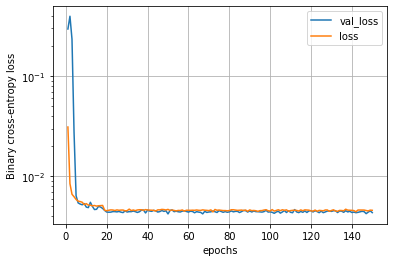

In [10]:
# Plot the Training Loss and Validation Loss
hist_dict = mod_history.history

val_loss = hist_dict['val_loss']
loss = hist_dict['loss']
# acc = hist_dict['acc']
# val_acc = hist_dict['val_acc']
print('loss:',loss)
print('val_loss:',val_loss)

epoch = np.arange(1, epochs + 1)

plt.semilogy(epoch,val_loss,label='val_loss')
plt.semilogy(epoch, loss, label='loss')

plt.legend(loc=0)
plt.grid('true')
plt.xlabel('epochs')
plt.ylabel('Binary cross-entropy loss')

plt.show()